In [1]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Literal

import numpy as np
from numpy.typing import NDArray

import sklearn as skl
import torch as pt

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns


sns.set_theme(style='darkgrid', palette='muted')

In [2]:
from sklearn.datasets import make_classification

from torch.utils import data


@dataclass()
class Dataset(data.Dataset):
    x: pt.Tensor
    y: pt.Tensor

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __iter__(self):
        return zip(self.x, self.y)

    def __len__(self):
        return self.x.shape[0]

    def __repr__(self):
        return f'{type(self)}({self.x.shape})'


def make_dataset(train: int, test: int, sample: int):
    n_samples = train + test + sample

    #generate dataset with n_sameples data and 20 features
    x, y = make_classification(n_samples, random_state=42)
    print(x.shape)

    x = pt.tensor(x, dtype=pt.float)
    #do the transpose
    y = pt.tensor(y[..., None], dtype=pt.float)
    # y = pt.tensor(y, dtype=pt.float)
    # print(x)
    # print(y)

    #do the dataset slice
    i_train = np.s_[:train]
    i_test = np.s_[train:train+test]
    i_sample = np.s_[train+test:]
    d_train = Dataset(x[i_train], y[i_train])
    d_test = Dataset(x[i_test], y[i_test])
    d_sample = Dataset(x[i_sample], y[i_sample])
    return d_train, d_test, d_sample


train, test, sample = make_dataset(100, 100, 2000)
print(train.x.shape)


(2200, 20)
torch.Size([100, 20])


In [3]:
from torch import nn, optim


class LogisticRegression(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x


model = LogisticRegression(train.x.shape[1], 1)
loss_list = []

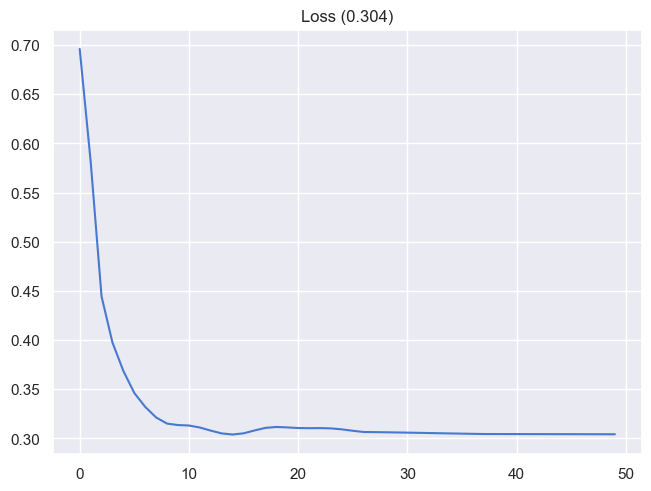

In [4]:
def draw_statistic(*args, mode: Literal['both', 'loss', 'acc'] = 'loss'):
    fig: plt.Figure
    ax: plt.Axes
    ax0: plt.Axes
    ax1: plt.Axes
    if mode == 'both':
        fig, (ax0, ax1) = plt.subplots(
            1, 2,
            sharex=True,
            figsize=(10, 5),
            layout='constrained'
        )
        ax0.plot(args[0], c='C0')
        ax1.plot(args[1], c='C1')
        ax0.set_title(f'Loss ({args[0][-1]:.3f})')
        ax1.set_title(f'Accuracy ({args[1][-1]:.1%})')
    elif mode == 'loss':
        fig, ax = plt.subplots(1, 1, layout='constrained')
        ax.plot(args[0])
        ax.set_title(f'Loss ({args[0][-1]:.3f})')
    elif mode == 'acc':
        fig, ax = plt.subplots(1, 1, layout='constrained')
        ax.plot(args[0])
        ax.set_title(f'Accuracy ({args[0][-1]:.1%})')
    else:
        raise ValueError('mode must be one of both, loss, or acc')


# def training(model: nn.Module, dataset: Dataset, max_epochs: int, loss_list: list | None = None):
def training(model: nn.Module, dataset: Dataset, max_epochs: int, loss_list: list = None):
    loss: pt.Tensor
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), 0.3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    model.train()
    for _ in range(max_epochs):
        outputs = model(dataset.x)
        optimizer.zero_grad()
        loss = criterion(outputs, dataset.y)
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        scheduler.step(loss)
        if loss_list is not None:
            loss_list.append(loss.item())
    model.eval()


training(model, train, 50, loss_list)
draw_statistic(loss_list, mode='loss')

In [56]:
class Recourse(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.action = nn.Parameter(pt.zeros(size))

    # def forward(self, x: pt.Tensor, weight: pt.Tensor | None = None):
    def forward(self, x: pt.Tensor, weight: pt.Tensor = None):
        a = self.action
        # print("a",a)

        #to be implement
        #add cost funtion weight

        if weight is not None:
            a = a * weight
        x = x + a
        return x


# def recourse(c_model: nn.Module, dataset: Dataset, max_epochs: int, weight: pt.Tensor | None = None, loss_list: list | None = None):
def recourse(c_model: nn.Module, dataset: Dataset, max_epochs: int, weight: pt.Tensor = None, loss_list: list = None):
    loss: pt.Tensor
    r_model = Recourse(dataset.x.shape)
    criterion = nn.HuberLoss()
    optimizer = optim.Adam(r_model.parameters(), 0.1)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    r_model.train()
    for _ in range(max_epochs):
        optimizer.zero_grad()
        x_hat = r_model(dataset.x, weight)
        y_hat = c_model(x_hat)
        loss = criterion(y_hat, dataset.y)
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        c_model.zero_grad()
        # scheduler.step(loss)
        if loss_list is not None:
            loss_list.append(loss.item())
    r_model.eval()

    with pt.no_grad():
        dataset.x = r_model(dataset.x)
    # draw_statistic(loss_list,mode='loss')

In [53]:
#Test weight Recourse


class Recourse(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.action = nn.Parameter(pt.zeros(size))

    # def forward(self, x: pt.Tensor, weight: pt.Tensor | None = None):
    def forward(self, x: pt.Tensor, weight: pt.Tensor = None):
        a = self.action
        # print("a",a)

        #to be implement
        #add cost funtion weight

        # if weight is not None:
        #     a = a * weight
        x = x + a
        cost = deepcopy(a)
        return x,cost


# def recourse(c_model: nn.Module, dataset: Dataset, max_epochs: int, weight: pt.Tensor | None = None, loss_list: list | None = None):
def recourse(c_model: nn.Module, dataset: Dataset, max_epochs: int, weight: pt.Tensor = None, loss_list: list = None):
    loss: pt.Tensor
    r_model = Recourse(dataset.x.shape)
    criterion = nn.HuberLoss()
    optimizer = optim.Adam(r_model.parameters(), 0.1)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    r_model.train()
    for _ in range(max_epochs):
        optimizer.zero_grad()
        x_hat,cost = r_model(dataset.x)
        y_hat = c_model(x_hat)
        loss = criterion(y_hat, dataset.y) + pt.pow(pt.sum(cost * cost * weight),1/2)
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        c_model.zero_grad()
        # scheduler.step(loss)
        if loss_list is not None:
            loss_list.append(loss.item())
    r_model.eval()

    with pt.no_grad():
        dataset.x,cost = r_model(dataset.x)
    draw_statistic(loss_list,mode='loss')

In [74]:
a = [7,14,20,66,99]
print(a[-1])
# s = np.random.gamma(2, 1, 20)
# print(pt.from_numpy(s))
# s = np.random.normal(1, 0.3, 20)
# print(s)

a = pt.ones(5)
print(a)
print(pt.sum(a))
print(pt.pow(pt.sum(a),1/2))
print(pt.pow(pt.tensor(8.),1/3))

99
tensor([1., 1., 1., 1., 1.])
tensor(5.)
tensor(2.2361)
tensor(2.)


In [7]:
from sklearn.decomposition import PCA

pca = PCA(2).fit(train.x)

In [73]:
from matplotlib.animation import FuncAnimation
from matplotlib.axes import Axes
from matplotlib.figure import Figure, SubFigure
from matplotlib.colors import ListedColormap
from matplotlib.collections import PathCollection
from matplotlib.container import BarContainer
from matplotlib.contour import QuadContourSet
from matplotlib.patches import Rectangle


class PlotHelper:

    palette = sns.color_palette('muted', 2)
    cmap = ListedColormap(palette)

    def __init__(self, model: nn.Module, pca: PCA, train: Dataset, test: Dataset, sample: Dataset):
        self.model = model
        self.pca = pca
        self.train = train
        self.test = test
        self.sample = sample
        self.PDt = []
        self.round = 0
        self.EFTdataframe =  pd.DataFrame(
            {
                'x':train.x.tolist(),
                'y':train.y.flatten(),
                # 'Predict':train.y.flatten(),
                'Predict':[[] for _ in range(len(train.x))],
                'flip_times':np.zeros(len(train.x)),
                'startRounds':np.zeros(len(train.x)),
                'updateRounds':np.zeros(len(train.x)),
                'EFT' : np.zeros(len(train.x)),
                'EFTList': [[] for _ in range(len(train.x))]
            }
        )
        self.failToRecourse = []

        self.validation_list = []
        self.Ajj_performance_list = []
        self.overall_acc_list = []
        self.memory_stability_list = []
        self.memory_plasticity_list = []
        self.Aj_tide_list = []

        self._hist: list[BarContainer]
        self._bins: NDArray
        self._sc_train: PathCollection
        self._sc_test: PathCollection
        self._ct_test: QuadContourSet

    # def draw_proba_hist(self, ax: Axes | None = None, *, label: bool = False):
    def draw_proba_hist(self, ax: Axes = None, *, label: bool = False):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 4))
        else:
            fig = ax.get_figure()

        x = self.test.x
        y = self.test.y

        n = x.shape[0]
        m = n - pt.count_nonzero(y)

        with pt.no_grad():
            y_prob: pt.Tensor = self.model(x)

        y = y.flatten()
        y_prob = y_prob.flatten()
        y_prob = y_prob[y.argsort()]

        w = np.broadcast_to(100 / n, n)

        self._hist: list[BarContainer]
        _, self._bins, self._hist = ax.hist(
            (y_prob[:m], y_prob[m:]),
            10,
            (0, 1),
            weights=(w[:m], w[m:]),
            rwidth=1,
            color=self.palette,
            label=(0, 1),
            ec='w',
            alpha=0.9,
        )

        ax.legend(loc='upper center', title='True label')
        ax.set_xlabel('mean predicted probabilty')
        ax.set_ylabel('percent')
        ax.set_title('Probability Distribution')

        if label:
            for c in self._hist:
                height = map(Rectangle.get_height, c.patches)
                ax.bar_label(
                    c,
                    [f'{h}%' if h else '' for h in height],
                    fontsize='xx-small'
                )
        return fig, ax

    # def draw_dataset_scatter(self, axes: tuple[Axes, Axes] | None = None):
    def draw_dataset_scatter(self, axes: [Axes, Axes] = None):
        if axes is None:
            fig, (ax0, ax1) = plt.subplots(
                1, 2,
                sharex=True,
                sharey=True,
                figsize=(8, 4),
                layout='compressed'
            )
        else:
            ax0, ax1 = axes
            fig = ax0.get_figure()

        prop = dict(cmap=self.cmap, s=40, vmin=0., vmax=1., lw=0.8, ec='w')

        self._sc_train = ax0.scatter(
            *pca.transform(self.train.x).T,
            c=self.train.y,
            **prop
        )
        ax0.legend(
            *self._sc_train.legend_elements(),
            loc='upper right',
            title='True label'
        )
        ax0.set_xlabel('pca0')
        ax0.set_ylabel('pca1')
        ax0.set_title('Train')

        with pt.no_grad():
            y_prob: pt.Tensor = self.model(test.x)

        y_prob = y_prob.flatten()
        y_pred = y_prob.greater(0.5)

        self._sc_test = ax1.scatter(
            *pca.transform(test.x).T,
            c=y_pred,
            **prop
        )
        ax1.legend(
            *self._sc_test.legend_elements(),
            loc='upper right',
            title='Predicted'
        )

        x0, x1 = ax0.get_xlim()
        y0, y1 = ax0.get_ylim()
        n = 32
        xy = np.mgrid[x0: x1: n * 1j, y0: y1: n * 1j]
        z = pca.inverse_transform(xy.reshape(2, n * n).T)

        z = pt.tensor(z, dtype=pt.float)
        with pt.no_grad():
            z: pt.Tensor = self.model(z)
        z = z.view(n, n)
        self._ct_test = ax1.contourf(
            *xy, z, 10,
            cmap='RdYlBu_r',
            vmin=0,
            vmax=1,
            alpha=0.9,
            zorder=0,
        )
        fig.colorbar(self._ct_test, ax=ax1, label='probability')
        ax1.grid(alpha=0.75)
        ax1.set_xlabel('pca0')
        ax1.set_title('Test')

        return fig, axes

    def draw_all(self):
        sf: list[SubFigure]
        fig = plt.figure(figsize=(8, 8), layout='constrained')
        sf = fig.subfigures(2, 1)
        ax0 = sf[0].subplots()
        ax1, ax2 = sf[1].subplots(1, 2, sharex=True, sharey=True)
        self.draw_proba_hist(ax0)
        self.draw_dataset_scatter((ax1, ax2))
        return fig, (ax0, ax1, ax2)

    def animate_all(self, frames: int = 120, fps: int = 10, *, inplace: bool = False):
        fig, (ax0, ax1, ax2) = self.draw_all()

        model = self.model if inplace else deepcopy(self.model)
        train = self.train if inplace else deepcopy(self.train)
        test = self.test
        sample = self.sample

        def init():
            return *ax0.patches, *ax1.collections, *ax2.collections

        def func(frame):
            fig.suptitle(f'No. {frame}', ha='left', x=0.01, size='small')

            if frame == 0:
                return ()

            self.update(model, train, sample)

            y = test.y.flatten()

            n = test.x.shape[0]
            m = n - pt.count_nonzero(y)

            with pt.no_grad():
                y_prob: pt.Tensor = model(test.x)

            y_prob = y_prob.flatten()
            y_pred = y_prob.greater(0.5)
            rank = y_prob[y.argsort()]

            for b, r in zip(self._hist, (rank[:m], rank[m:])):
                height, _ = np.histogram(r, self._bins)
                for r, h in zip(b.patches, height * (100 / n)):
                    r.set_height(h)

            self._sc_train.set_offsets(pca.transform(train.x))
            self._sc_train.set_array(train.y.flatten())
            self._sc_test.set_array(y_pred)

            ax1.relim()
            ax1.autoscale_view()

            for c in self._ct_test.collections:
                c.remove()

            x0, x1 = ax1.get_xlim()
            y0, y1 = ax1.get_ylim()
            n = 32
            xy = np.mgrid[x0: x1: n * 1j, y0: y1: n * 1j]
            z = pca.inverse_transform(xy.reshape(2, n * n).T)
            z = pt.tensor(z, dtype=pt.float)
            with pt.no_grad():
                z: pt.Tensor = model(z)
            z = z.view(n, n)

            self._ct_test: QuadContourSet = ax2.contourf(
                *xy, z, 10,
                cmap='RdYlBu_r',
                vmin=0,
                vmax=1,
                alpha=0.9,
                zorder=0,
            )

            return *ax0.patches, *ax1.collections, *ax2.collections

        return FuncAnimation(
            fig, func, frames, init,
            interval=1000 // fps,
            repeat=False,
            blit=True,
            cache_frame_data=False
        )

    def draw_PDt(self):

        #每一個round算出來的L2 distance
        tempList = deepcopy(self.PDt)
        # print("PDt: ",self.PDt)
        # print("tempList: ",tempList)
        # [1,2,3,4,5]
        for index,i in enumerate(range(len(self.PDt))):
            temp = 0.0
            #算出PDt
            for j in range(i + 1):
                temp = temp + tempList[j]
            temp = temp / (index + 1)
            # print("temp: ",temp)
            # print(type(temp))
            self.PDt[index] = temp

        # print("self.PDt: ",self.PDt)

        plt.figure()
        plt.plot(self.PDt)
        plt.xlabel('Round')
        plt.ylabel('PDt')
        plt.title('PDt during Rounds')
        plt.draw()

    def draw_EFT(self,epochs):
        data = []
        labels = [(epochs / 10 - 1) * (i+1) for i in range(10)]
        x = [1,2,3,4,5,6,7,8,9,10]
        print("EFT labels: ",labels)
        # labels = [8 * (i+1) for i in range(12)]
        # x = [1,2,3,4,5,6,7,8,9,10,11,12]
        for i in range((int(epochs / 10)-1),int(labels[-1]) + 1,(int(epochs / 10) - 1)):
        # for i in range(8,100,8):
            # print("i",i)
            roundData = []
            #只顯示經過2輪以上update的model的資料
            # dataframe = self.EFTdataframe[self.EFTdataframe['updateRounds'] > 2]
            dataframe = self.EFTdataframe[i - self.EFTdataframe['startRounds'] >= 2]
            # dataframe = self.EFTdataframe[self.EFTdataframe['flip_times'] > 0].head(10)
            for j in dataframe.index:
                # print("index: ",j)
                #判斷開始的Round是否合理
                if dataframe.at[j,'startRounds'] < i:
                    # print("index j append: ",j)
                    temp = dataframe.at[j,'EFTList']
                    roundData.append(temp[i - 1])
                # data.append([temp[i]])
                # self.EFTdataframe.at[i,'EFPList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
            # print(data)
            data.append(roundData)
        plt.figure()
        # sns.boxplot(x='rounds',y='EFPList',data = self.EFTdataframe)
        plt.boxplot(data)
        plt.xticks(x,labels)
        plt.xlabel('Round')
        plt.ylabel('EFT')

    def calculateR20EFT(self,tempPredict,updateRounds):
        last = tempPredict[0]
        flipTimes = 0
        for i in range(len(tempPredict) - 1):
            if(last != tempPredict[i + 1]):
                flipTimes += 1
            last = tempPredict[i + 1]
        # print("R20_EFT value: ",flipTimes / updateRounds)
        return flipTimes / updateRounds

    def draw_R20_EFT(self,epochs,intervalRounds):
        data = []
        labels = [i for i in range(intervalRounds,epochs,intervalRounds)]
        x = [i for i in range(1,len(labels) + 1)]
        # labels = [(int(epochs / 10) - 1) * (i+1) for i in range(10)]
        # x = [1,2,3,4,5,6,7,8,9,10]

        # for i in range((int(epochs / 10)-1),epochs - 1,(int(epochs / 10) - 1)):
        for i in range(intervalRounds,epochs - 1,intervalRounds):
            # print("i's round:",i)
            roundData = []
            # dataframe = self.EFTdataframe[self.EFTdataframe['updateRounds'] > 2]
            dataframe = self.EFTdataframe[i - self.EFTdataframe['startRounds'] >= 2]
            # print("R20's EFTdataframe")
            # display(dataframe)
            for j in dataframe.index:
                startRounds = int(dataframe.at[j,'startRounds'])
                if startRounds < i:
                    #dataframe['Predict'][0]代表從第predictRound開始做預測
                    # print("startRound : ",startRounds)

                    if startRounds >= i - intervalRounds:
                        startIndex = 0
                    else:
                        # startIndex = ((i - (int(epochs / 10) - 1)) - startRounds) - 1
                        startIndex = ((i - intervalRounds) - startRounds) - 1

                    endIndex = (i - startRounds)
                    # print("Predict array: ",dataframe.at[j,'Predict'])
                    # print("startIndex: ",startIndex)
                    # print("endIndex : ",endIndex)
                    tempPredict = dataframe.at[j,'Predict'][startIndex:endIndex]

                    roundData.append(self.calculateR20EFT(tempPredict,len(tempPredict)))


            data.append(roundData)
        plt.figure()
        # sns.boxplot(x='rounds',y='EFPList',data = self.EFTdataframe)
        plt.boxplot(data)
        plt.xticks(x,labels)
        plt.xlabel('Round')
        plt.ylabel('R' + str(intervalRounds) + '_EFT')

    def draw_Fail_to_Recourse(self):
        plt.figure()
        plt.plot(self.failToRecourse)
        plt.xlabel('Round')
        plt.ylabel('Fail_to_Recourse')
        plt.title('FtR during Rounds')
        plt.draw()

    #紀錄新增進來的sample資料
    def addEFTDataFrame(self,index):
        if self.EFTdataframe.at[0,'updateRounds'] != 0:
            sampleDataframe =  pd.DataFrame(
                {
                    'x':self.train.x[index].tolist(),
                    'y':self.train.y[index].flatten(),
                    # 'Predict':np.nan,
                    # 'Predict':self.train.y[index].flatten(),
                    'Predict':[ [] for _ in range(len(train.y[index]))],
                    'flip_times':np.zeros(len(self.train.y[index])),
                    'startRounds':np.full(len(self.train.y[index]),int(self.EFTdataframe.at[0,'updateRounds'])),
                    'updateRounds':np.zeros(len(self.train.y[index])),
                    'EFT' : np.zeros(len(self.train.y[index])),
                    # 'EFPList': [np.zeros(int(self.EFTdataframe.at[0,'rounds'])) for _ in range(len(train.y[index]))]
                    'EFTList': [ [0.0] * int(self.EFTdataframe.at[0,'updateRounds']) for _ in range(len(self.train.y[index]))]
                }
            )
        else:
            sampleDataframe =  pd.DataFrame(
                {
                    'x':self.train.x[index].tolist(),
                    'y':self.train.y[index].flatten(),
                    # 'Predict':np.nan,
                    # 'Predict':self.train.y[index].flatten(),
                    'Predict':[ [] for _ in range(len(train.y[index]))],
                    'flip_times':np.zeros(len(self.train.y[index])),
                    'startRounds':np.zeros(len(self.train.y[index])),
                    'updateRounds':np.zeros(len(self.train.y[index])),
                    'EFT' : np.zeros(len(self.train.y[index])),
                    'EFTList': [ [] for _ in range(len(self.train.y[index]))]
                }
            )
        # display(sampleDataframe)
        self.EFTdataframe = pd.concat([self.EFTdataframe,sampleDataframe],ignore_index=True)

    def calculate_accuracy(self, predicted_results, actual_labels, threshold=0.5):
      # Convert probabilities to binary predictions based on the threshold
      binary_predictions = []
      for prob in predicted_results:
        pred_label = 0
        if prob >= threshold:
          pred_label = 1
        else:
          pred_label = 0
        binary_predictions.append(pred_label)

      # Compare binary predictions to actual labels
      correct_predictions = []
      for i in range(0, len(binary_predictions)):
        if(binary_predictions[i] == actual_labels[i]):
          correct_predictions.append(1)
        else:
          correct_predictions.append(0)

      # Calculate accuracy as the ratio of correct predictions to total predictions
      if len(correct_predictions) == 0:
        return 0
      accuracy = sum(correct_predictions) / len(correct_predictions)
      return accuracy

    def calculate_AA(self, kth_model: nn.Module, jth_data_after_recourse: list):
      if jth_data_after_recourse:
        kth_model.eval()
        sum = 0

        # do each historical task
        for j in jth_data_after_recourse:
          pred = kth_model(j.x)
          acc = self.calculate_accuracy(pred, j.y)
          sum += acc

        return sum / len(jth_data_after_recourse)

      print("jth_data_after_recourse cannot be empty")
      return None

    def calculate_BWT(self, kth_model: nn.Module, jth_data_after_recourse, Ajj_performance_list):
      kth_model.eval()
      sum = 0

      for i in range (0, len(jth_data_after_recourse)):
        # if is the last loop, calculate A(j,j) and store it
        if i == len(jth_data_after_recourse) - 1:
          pred = kth_model(jth_data_after_recourse[i].x)
          Ajj_performance_list.append(self.calculate_accuracy(pred, jth_data_after_recourse[-1].y))
        # else we calculate A(k,j) - A(j,j)
        else:
          pred = kth_model(jth_data_after_recourse[i].x)
          acc = self.calculate_accuracy(pred, jth_data_after_recourse[i].y) - Ajj_performance_list[i]
          sum += acc

      if len(jth_data_after_recourse) == 1:
        return sum
      return sum / (len(jth_data_after_recourse) - 1)

    def calculate_FWT(self, Ajj_performance_list, Aj_tide_list):
      sum = 0

      for i in range(1, len(Ajj_performance_list)):
        sum +=  Ajj_performance_list[i] - Aj_tide_list[i]
        # print(Ajj_performance_list[i], Aj_tide_list[i])
      if len(Aj_tide_list) == 1:
        return sum
      return sum / (len(Aj_tide_list) - 1)

    def plot_matricsA(self):
      # Create a figure and subplots
      fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

      # Plot data on each subplot and draw
      axs[0].plot(self.overall_acc_list)
      axs[0].set_title('avarage accuracy')
      axs[0].set_xlabel('Round')
      axs[0].set_ylabel('accuracy')

      axs[1].plot(self.memory_stability_list)
      axs[1].set_title('memory stability (BWT)')
      axs[1].set_xlabel('Round')
      axs[1].set_ylabel('memory stability')

      axs[2].plot(self.memory_plasticity_list)
      axs[2].set_title('memory plasticity')
      axs[2].set_xlabel('Round')
      axs[2].set_ylabel('memory plasticity')

      # Adjust layout
      plt.tight_layout()

      # Show plot
      plt.show()

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        raise NotImplementedError()


# helper = PlotHelper(model, pca, train, test, sample)
# helper.draw_all()
# plt.show()

round:  0
~y_pred :  tensor([False,  True,  True, False, False,  True,  True, False,  True, False,
         True, False, False, False, False,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True])
round:  1
~y_pred :  tensor([ True, False, False, False, False, False,  True, False, False, False,
         True, False, False, False, False,  True,  True, False, False, False,
        False, False, False,  True,  True])
round:  2
~y_pred :  tensor([False,  True,  True,  True,  True, False, False,  True,  True,  True,
        False, False, False,  True,  True,  True, False,  True, False,  True,
         True, False, False,  True,  True])
round:  3
~y_pred :  tensor([False,  True,  True, False, False, False,  True,  True,  True, False,
         True, False,  True,  True,  True,  True, False, False,  True,  True,
         True,  True, False,  True,  True])
round:  4
~y_pred :  tensor([ True,  True, False,  True, False,  True,  True,  True, False,  True,
         True,  T

x    y  \
0     [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1     [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2     [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3     [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4     [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
...                                                 ...  ...   
1070  [0.05197172611951828, 0.6752124428749084, 0.03...  0.0   
1071  [1.4538590908050537, -0.31241732835769653, -0....  1.0   
1072  [0.8583512306213379, 0.9979543089866638, 0.166...  1.0   
1073  [-1.0168944597244263, -1.700072169303894, -0.8...  0.0   
1074  [-0.7930728197097778, 1.0084487199783325, 1.18...  1.0   

                                                Predict  flip_times  \
0     [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...         3.0   
1     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
2     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1.0   
3     [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...         3.0   
4     [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...         3.0   
...                                                 ...         ...   
1070                                              [0.0]         0.0   
1071                                              [0.0]         0.0   
1072                                              [0.0]         0.0   
1073                                              [0.0]         0.0   
1074                                              [0.0]         0.0   

      startRounds  updateRounds       EFT  \
0             0.0          39.0  0.078947   
1             0.0          39.0  0.184211   
2             0.0          39.0  0.026316   
3             0.0          39.0  0.078947   
4             0.0          39.0  0.078947   
...           ...           ...       ...   
1070         38.0           1.0  0.000000   
1071         38.0           1.0  0.000000   
1072         38.0           1.0  0.000000   
1073         38.0           1.0  0.000000   
1074         38.0           1.0  0.000000   

                                                EFTList  
0     [0.0, 0.5, 0.6666666666666666, 0.5, 0.4, 0.333...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666,...  
2     [1.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
3     [0.0, 0.0, 0.3333333333333333, 0.25, 0.2, 0.16...  
4     [0.0, 0.0, 0.0, 0.25, 0.2, 0.3333333333333333,...  
...                                                 ...  
1070  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1071  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1072  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1073  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1074  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[1075 rows x 8 columns]

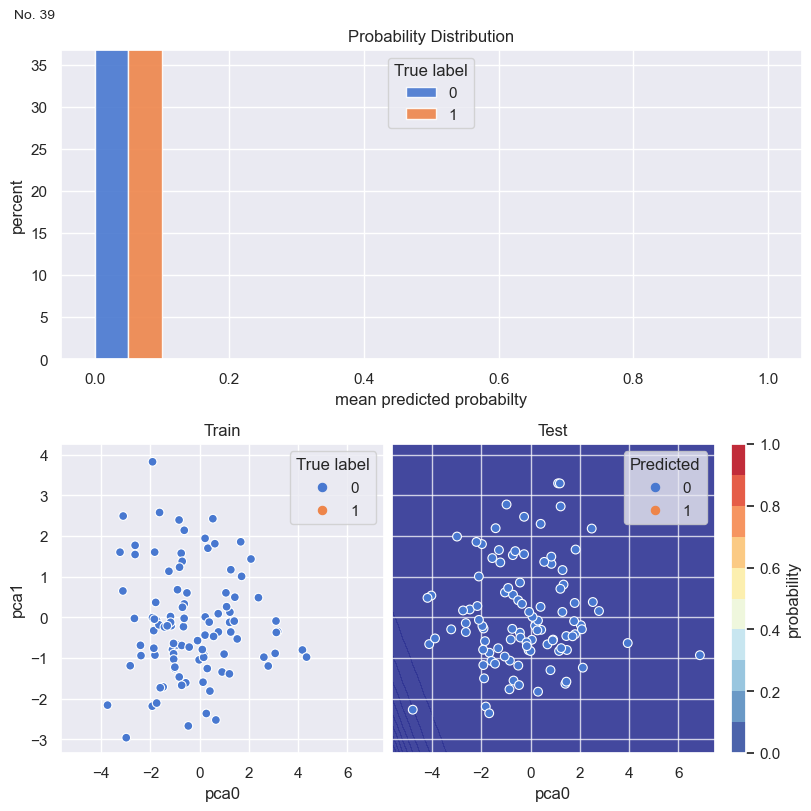

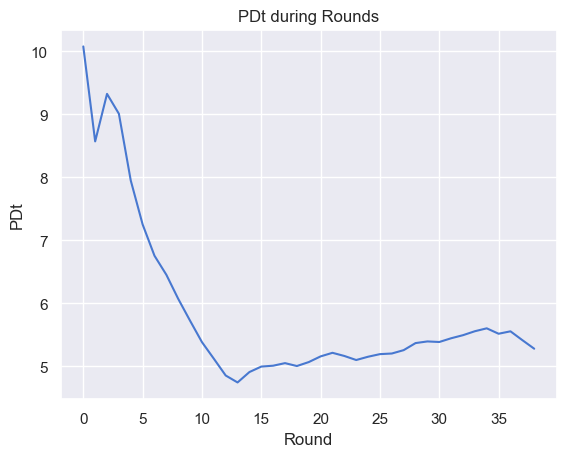

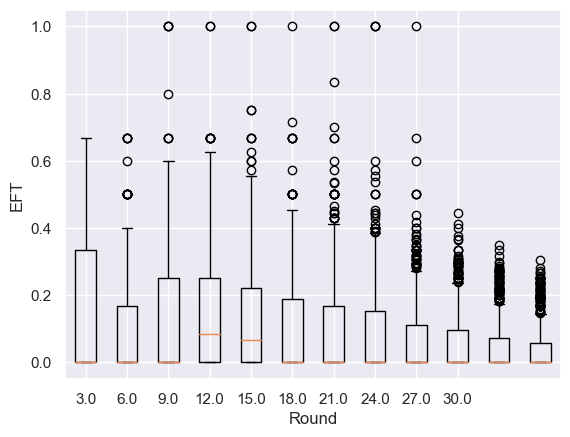

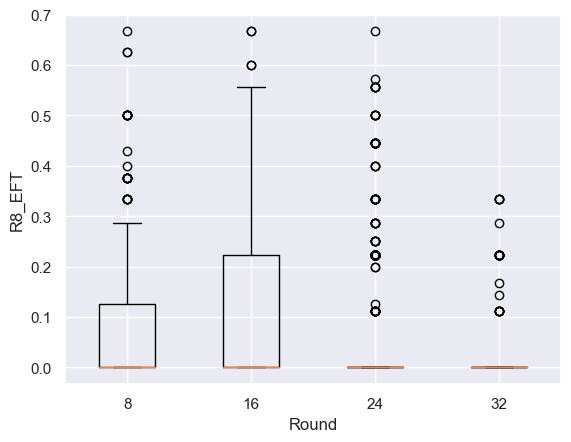

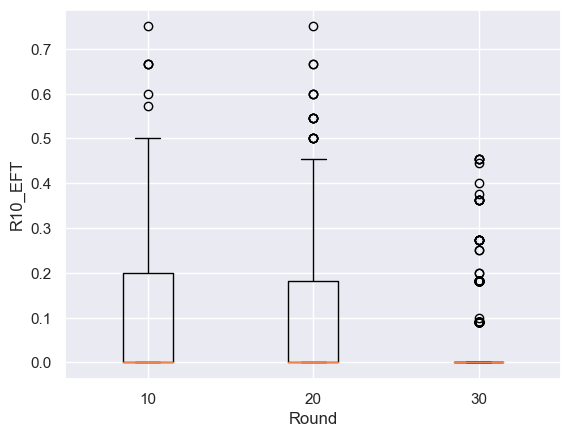

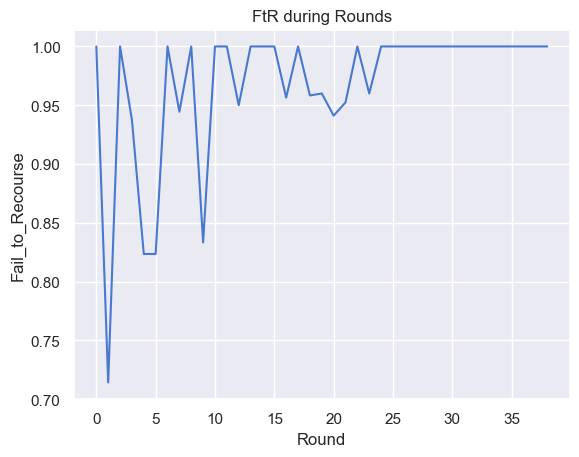

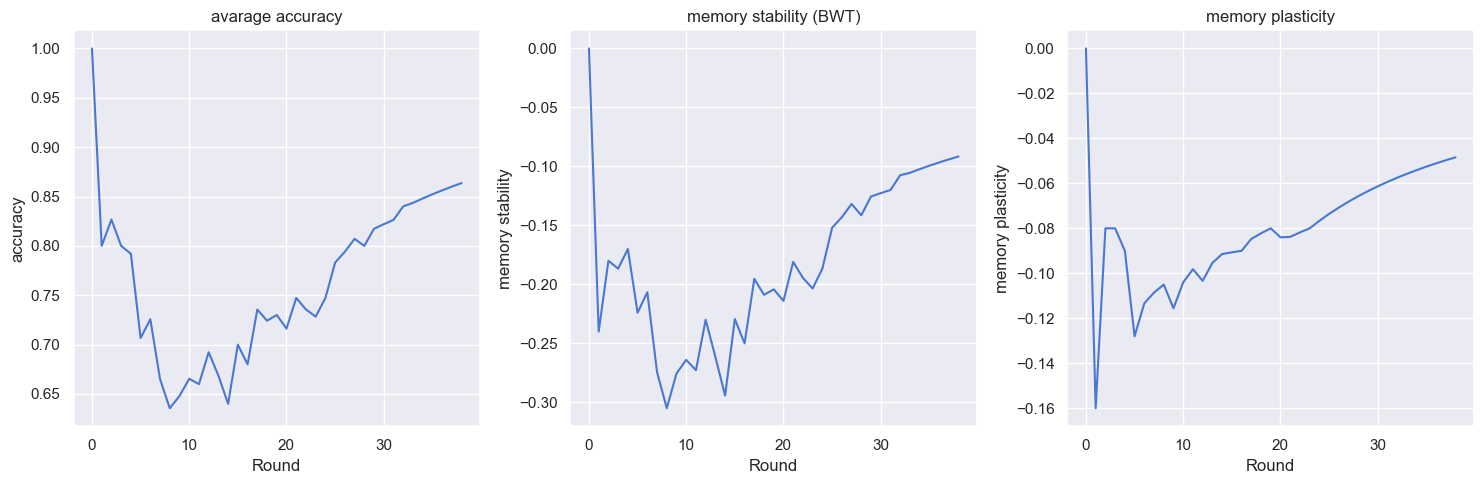

In [65]:
class Example1(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a approximately size of `train.size * 0.02`.
    2. Performs recourse on the selected subset of 'sample' while preserving their original labels.
    3. Replaces a corresponding part of the training set with the updated samples.
    4. Refits the model with the modified training data.
    '''

    #add first k              k maybe 40% 80% 100%

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        print("round: ",self.round)
        #get model parameters before model updated
        modelParams = list(model.parameters())
        weights = deepcopy(modelParams[0].data.reshape(-1))
        bias = deepcopy(modelParams[1].data)
        # print("Before update: ")
        # print(modelParams)
        # print(weights,bias)


        size = train.x.shape[0] // 4
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]
        # print("x:",x)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        # print("predict: ",y_prob.data)
        y_pred = y_prob.flatten() < 0.5
        print("~y_pred : ",y_pred)
        sub_sample = Dataset(x[y_pred], pt.ones((y_pred.count_nonzero(), 1)))

        # recourse(model, sub_sample, 10,weight,loss_list=[])
        recourse(model, sub_sample, 10)

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)
        train.x[j] = x
        train.y[j, 0] = (~y_pred).float()
        
        # index = y_prob.flatten() > 0.5
        # k = round(len(index) * 0.4)
        # index = y_prob[index].numpy().argpartition(k)
        # train.y[]

        val_data = Dataset(train.x[j], train.y[j])
        self.validation_list.append(val_data)
        sample_model = LogisticRegression(val_data.x.shape[1], 1)
        sample_model.train()
        training(sample_model, val_data, 30)
        self.Aj_tide_list.append(self.calculate_accuracy(sample_model(val_data.x), val_data.y))

        #紀錄新增進來的sample資料
        self.addEFTDataFrame(j)


        training(model, train, 50)

        # calculate the overall accuracy
        self.overall_acc_list.append(self.calculate_AA(model, self.validation_list))
        # evaluate memory stability
        self.memory_stability_list.append(self.calculate_BWT(model, self.validation_list, self.Ajj_performance_list))
        # evaluate memory plasticity
        self.memory_plasticity_list.append(self.calculate_FWT(self.Ajj_performance_list, self.Aj_tide_list))


        #紀錄Fail_to_Recourse
        with pt.no_grad():
            y_prob: pt.Tensor = model(x[y_pred])

        # print("x[y_pred] : ",x[y_pred])
        # print("after model update:")
        # print("y_prob:",y_prob)
        # print("y_prob[y_prob < 0.5]",y_prob[y_prob < 0.5])
        recourseFailCnt = len(y_prob[y_prob < 0.5])
        # print("recourseFailCnt",recourseFailCnt)
        recourseFailRate = recourseFailCnt / len(x[y_pred])
        # print("recourseFailRate : ",recourseFailRate)
        self.failToRecourse.append(recourseFailRate)

        self.EFTdataframe = self.EFTdataframe.assign(updateRounds = self.EFTdataframe['updateRounds'] + 1)
        self.round = self.round + 1


        #updated model predict the data with new sample
        data = np.vstack(self.EFTdataframe['x'])
        with pt.no_grad():
            y_pred = model(pt.tensor(data,dtype = pt.float))

        #set prob 0.5 as threshold
        predictValue = deepcopy(y_pred.data)
        predictValue[predictValue > 0.5] = 1.0
        predictValue[predictValue < 0.5] = 0.0
        predictValue = predictValue.numpy().T.reshape(-1)
        # print("predictValue: ",predictValue)
        # print("data type: ",type(predictValue))

        #store the updated model predict value
        for i in self.EFTdataframe.index:
            self.EFTdataframe.at[i,'Predict'].append(predictValue[i])
         # self.EFTdataframe.loc[predictValue.numpy().T.reshape(-1) != self.EFTdataframe['Predict'],['flip_times']] += 1

         #check whether the output flip out
        for i in self.EFTdataframe.index:
            predictLength = len(self.EFTdataframe.at[i,'Predict'])
            # if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][predictLength - 2] != self.EFTdataframe.at[i,'Predict'][predictLength - 1]):
            if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][-2] != self.EFTdataframe.at[i,'Predict'][-1]):
                # self.EFTdataframe.loc[(self.EFTdataframe['rounds'] - self.EFTdataframe['startRounds'] > 1) and self.EFTdataframe['Predict'][self.round - 2] != self.EFTdataframe['Predict'][self.round - 1] ,['flip_times']] += 1
                self.EFTdataframe.at[i,'flip_times'] += 1

        #update EFP values
        self.EFTdataframe.loc[(self.EFTdataframe['updateRounds'] - 1) > 0,['EFT']] = self.EFTdataframe['flip_times'] / (self.EFTdataframe['updateRounds'] - 1)

        for i in self.EFTdataframe.index:
            if len(self.EFTdataframe.at[i,'Predict']) > 1:
                # self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
                self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'EFT'])

        # display(self.EFTdataframe)
        #calculate the PDt
        modelParams = list(model.parameters())
        modelParameter = np.concatenate((weights,bias))
        resultParameter = np.concatenate((modelParams[0].data.reshape(-1),modelParams[1].data))
        # print("Before update: ")
        # print(weights,bias)
        # print("After update: ")
        # print(modelParams[0].data.reshape(-1),modelParams[1].data)

        parameterL2 = np.linalg.norm(resultParameter - modelParameter)

        self.PDt.append(parameterL2)

# weight = pt.from_numpy(np.random.gamma(3,1,20))
# print(train.x)
# print(train.y)
ex1 = Example1(model, pca, train, test, sample)
# ani1 = ex1.animate_all(240)
ani1 = ex1.animate_all(40)
ani1.save('ex1.gif')

# ex1.draw_PDt()
ex1.draw_PDt()
ex1.draw_EFT(40)
ex1.draw_R20_EFT(40,8)
ex1.draw_R20_EFT(40,10)

# ex1.draw_EFT(240)
# ex1.draw_R20_EFT(240,23)
# ex1.draw_R20_EFT(240,40)
# ex1.draw_R20_EFT(240,58)
ex1.draw_Fail_to_Recourse()
display(ex1.EFTdataframe)
ex1.plot_matricsA()


In [ ]:
#binomial Recourse distribution    Prob = 0.6    Test firsk k

round:  0
binomial data:  [False  True  True  True  True  True  True  True  True  True]
before binomial tensor([False,  True,  True, False, False,  True, False, False, False,  True,
         True, False, False,  True,  True, False, False, False, False,  True,
        False,  True,  True, False, False])
binomial y_pred tensor([False,  True,  True, False, False,  True, False, False, False,  True,
         True, False, False,  True,  True, False, False, False, False,  True,
        False,  True,  True, False, False])
after recourse
check eq : tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,

x    y  \
0     [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1     [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2     [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3     [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4     [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
...                                                 ...  ...   
2070  [-0.1075042188167572, 1.3706083297729492, 1.06...  0.0   
2071  [0.05304703116416931, 0.8849626779556274, -1.4...  1.0   
2072  [0.2447846233844757, -2.9538235664367676, 0.20...  1.0   
2073  [-0.37439003586769104, -1.5144140720367432, -0...  0.0   
2074  [-0.8128235936164856, -2.074486255645752, 1.62...  0.0   

                                                Predict  flip_times  \
0     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         1.0   
1     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         5.0   
2     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         1.0   
3     [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...         5.0   
4     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         1.0   
...                                                 ...         ...   
2070                                              [0.0]         0.0   
2071                                              [0.0]         0.0   
2072                                              [0.0]         0.0   
2073                                              [0.0]         0.0   
2074                                              [0.0]         0.0   

      startRounds  updateRounds       EFT  \
0             0.0          79.0  0.012821   
1             0.0          79.0  0.064103   
2             0.0          79.0  0.012821   
3             0.0          79.0  0.064103   
4             0.0          79.0  0.012821   
...           ...           ...       ...   
2070         78.0           1.0  0.000000   
2071         78.0           1.0  0.000000   
2072         78.0           1.0  0.000000   
2073         78.0           1.0  0.000000   
2074         78.0           1.0  0.000000   

                                                EFTList  
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111...  
3     [0.0, 0.0, 0.3333333333333333, 0.25, 0.2, 0.16...  
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                 ...  
2070  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2071  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2072  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2073  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2074  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[2075 rows x 8 columns]

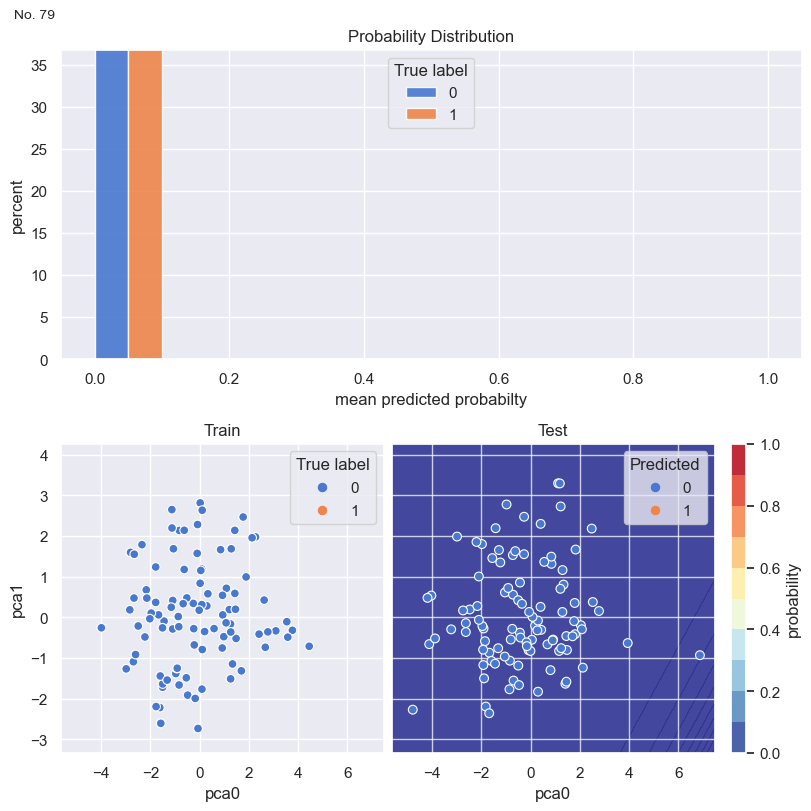

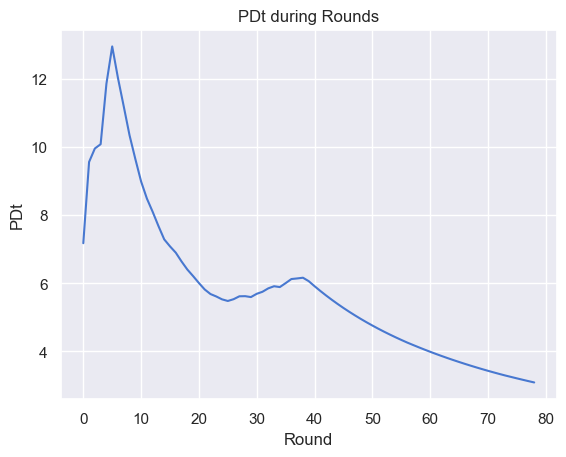

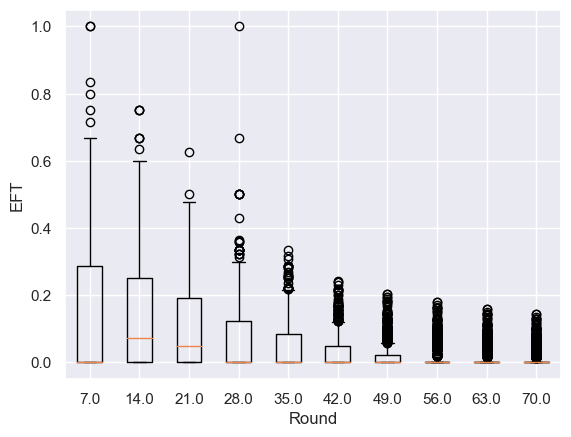

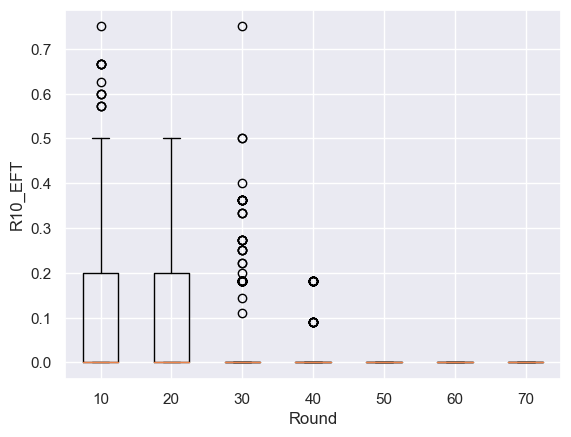

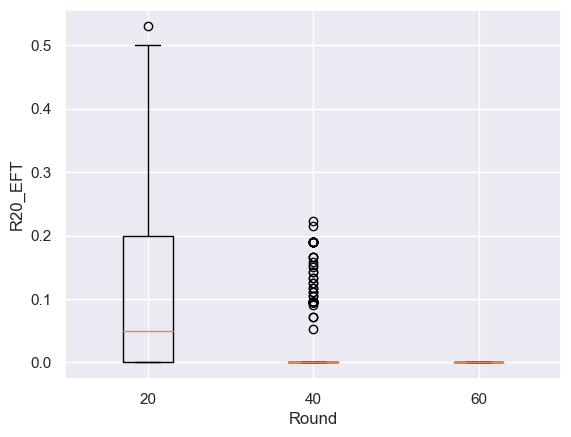

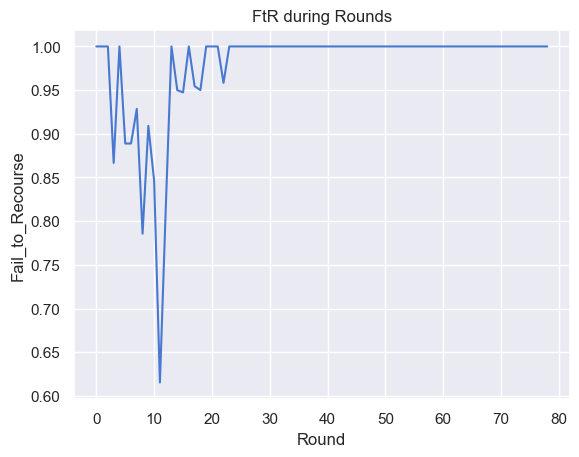

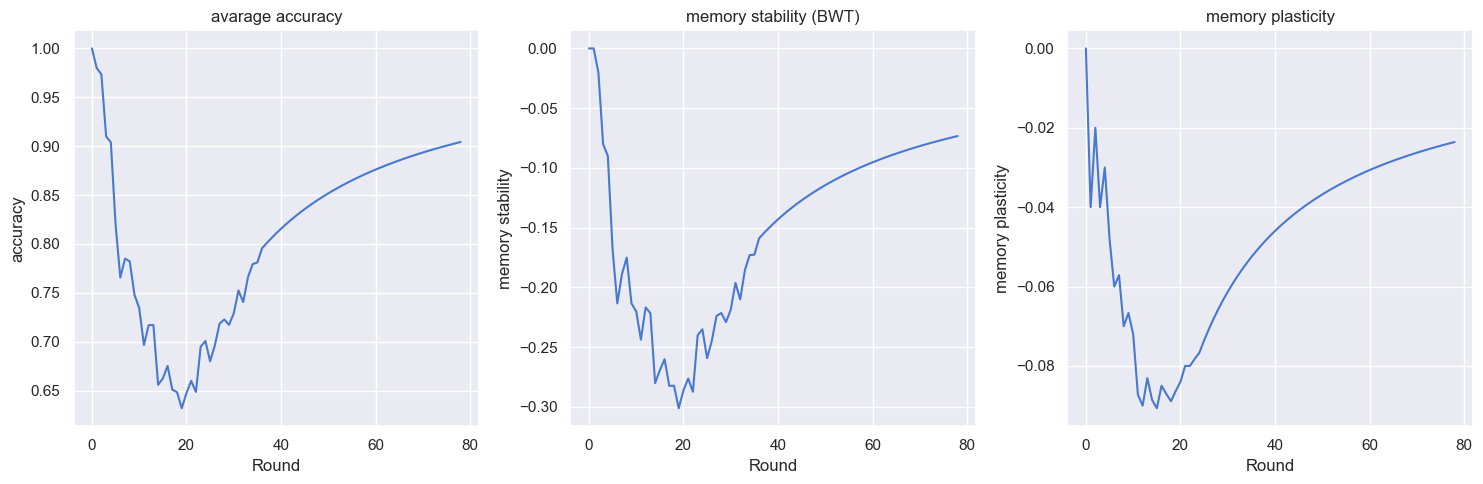

In [100]:
#binomial Recourse distribution    Prob = 0.6
class Example1(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a approximately size of `train.size * 0.02`.
    2. Performs recourse on the selected subset of 'sample' with binomial distribution and preserve their original labels.
    3. Replaces a corresponding part of the training set with the updated samples.
    4. Refits the model with the modified training data.
    '''

    #add first k              k maybe 40% 80% 100%

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        print("round: ",self.round)
        #get model parameters before model updated
        modelParams = list(model.parameters())
        weights = deepcopy(modelParams[0].data.reshape(-1))
        bias = deepcopy(modelParams[1].data)
        # print("Before update: ")
        # print(modelParams)
        # print(weights,bias)


        size = train.x.shape[0] // 4
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]
        # print("x:",x)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        # print("predict: ",y_prob.data)
        y_pred = y_prob.flatten() < 0.5
        
        # Performs recourse on the selected samples with binomial distributed destination.
        binomialData = np.random.binomial(1,BinomialProb,np.count_nonzero(y_pred)).astype(bool)
        print("binomial data: ",binomialData)
        recourseIndex = deepcopy(y_pred)
        print("before binomial",recourseIndex)
        recourseIndex[recourseIndex == True] = pt.from_numpy(binomialData)
        # y_pred[y_pred == True] = pt.from_numpy(binomialData)
        print("binomial y_pred",y_pred)
        sub_sample = Dataset(x[recourseIndex], pt.full((recourseIndex.count_nonzero(), 1),1.0))

        # recourse(model, sub_sample, 10,weight,loss_list=[])
        if len(sub_sample) > 0:
            recourse(model, sub_sample, 10)
            test = deepcopy(x)
        
            #change the attributes that performed recourse
            x[recourseIndex] = sub_sample.x
            
            print("after recourse")
            print("check eq :",pt.eq(test,x))

        j = np.random.choice(train.x.shape[0], size, False)
        
        # #pseudou-labeling(based on j-1's model and recourse)
        # with pt.no_grad():
        #     y_prob: pt.Tensor = model(x)
            
        # y_pred = y_prob.flatten() < 0.5
        train.x[j] = x
        # train.y[j, 0] = (~y_pred).float()
        train.y[j, 0] = (~y_pred).float()
        
        # index = y_prob.flatten() > 0.5
        # k = round(len(index) * 0.4)
        # index = y_prob[index].numpy().argpartition(k)
        # train.y[]

        val_data = Dataset(train.x[j], train.y[j])
        self.validation_list.append(val_data)
        sample_model = LogisticRegression(val_data.x.shape[1], 1)
        sample_model.train()
        training(sample_model, val_data, 30)
        self.Aj_tide_list.append(self.calculate_accuracy(sample_model(val_data.x), val_data.y))

        #紀錄新增進來的sample資料
        self.addEFTDataFrame(j)


        training(model, train, 50)

        # calculate the overall accuracy
        self.overall_acc_list.append(self.calculate_AA(model, self.validation_list))
        # evaluate memory stability
        self.memory_stability_list.append(self.calculate_BWT(model, self.validation_list, self.Ajj_performance_list))
        # evaluate memory plasticity
        self.memory_plasticity_list.append(self.calculate_FWT(self.Ajj_performance_list, self.Aj_tide_list))


        #紀錄Fail_to_Recourse
        if len(x[y_pred]) > 0:
            with pt.no_grad():
                y_prob: pt.Tensor = model(x[y_pred])

            # print("x[y_pred] : ",x[y_pred])
            # print("after model update:")
            # print("y_prob:",y_prob)
            # print("y_prob[y_prob < 0.5]",y_prob[y_prob < 0.5])
            recourseFailCnt = len(y_prob[y_prob < 0.5])
            # print("recourseFailCnt",recourseFailCnt)
            recourseFailRate = recourseFailCnt / len(x[y_pred])
            # print("recourseFailRate : ",recourseFailRate)
            self.failToRecourse.append(recourseFailRate)
        else:
            print("no Recourse:")
            self.failToRecourse.append(0)

        self.EFTdataframe = self.EFTdataframe.assign(updateRounds = self.EFTdataframe['updateRounds'] + 1)
        self.round = self.round + 1


        #updated model predict the data with new sample
        data = np.vstack(self.EFTdataframe['x'])
        with pt.no_grad():
            y_pred = model(pt.tensor(data,dtype = pt.float))

        #set prob 0.5 as threshold
        predictValue = deepcopy(y_pred.data)
        predictValue[predictValue > 0.5] = 1.0
        predictValue[predictValue < 0.5] = 0.0
        predictValue = predictValue.numpy().T.reshape(-1)
        # print("predictValue: ",predictValue)
        # print("data type: ",type(predictValue))

        #store the updated model predict value
        for i in self.EFTdataframe.index:
            self.EFTdataframe.at[i,'Predict'].append(predictValue[i])
         # self.EFTdataframe.loc[predictValue.numpy().T.reshape(-1) != self.EFTdataframe['Predict'],['flip_times']] += 1

         #check whether the output flip out
        for i in self.EFTdataframe.index:
            predictLength = len(self.EFTdataframe.at[i,'Predict'])
            # if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][predictLength - 2] != self.EFTdataframe.at[i,'Predict'][predictLength - 1]):
            if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][-2] != self.EFTdataframe.at[i,'Predict'][-1]):
                # self.EFTdataframe.loc[(self.EFTdataframe['rounds'] - self.EFTdataframe['startRounds'] > 1) and self.EFTdataframe['Predict'][self.round - 2] != self.EFTdataframe['Predict'][self.round - 1] ,['flip_times']] += 1
                self.EFTdataframe.at[i,'flip_times'] += 1

        #update EFP values
        self.EFTdataframe.loc[(self.EFTdataframe['updateRounds'] - 1) > 0,['EFT']] = self.EFTdataframe['flip_times'] / (self.EFTdataframe['updateRounds'] - 1)

        for i in self.EFTdataframe.index:
            if len(self.EFTdataframe.at[i,'Predict']) > 1:
                # self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
                self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'EFT'])

        # display(self.EFTdataframe)
        #calculate the PDt
        modelParams = list(model.parameters())
        modelParameter = np.concatenate((weights,bias))
        resultParameter = np.concatenate((modelParams[0].data.reshape(-1),modelParams[1].data))
        # print("Before update: ")
        # print(weights,bias)
        # print("After update: ")
        # print(modelParams[0].data.reshape(-1),modelParams[1].data)

        parameterL2 = np.linalg.norm(resultParameter - modelParameter)

        self.PDt.append(parameterL2)

# weight = pt.from_numpy(np.random.gamma(3,1,20))
# print(train.x)
# print(train.y)
BinomialProb = 0.7
ex1 = Example1(model, pca, train, test, sample)
ani1 = ex1.animate_all(80)

# ani1 = ex1.animate_all(240)
ani1.save('ex1_binomial70.mp4')

# ex1.draw_PDt()
ex1.draw_PDt()
ex1.draw_EFT(80)
ex1.draw_R20_EFT(80,10)
ex1.draw_R20_EFT(80,20)

# ex1.draw_EFT(240)
# ex1.draw_R20_EFT(240,23)
# ex1.draw_R20_EFT(240,40)
# ex1.draw_R20_EFT(240,58)
ex1.draw_Fail_to_Recourse()
display(ex1.EFTdataframe)
ex1.plot_matricsA()


round:  0
y_pred:  tensor([False, False,  True,  True,  True,  True, False,  True,  True, False,
         True, False, False, False, False,  True,  True, False,  True, False,
        False,  True, False, False,  True])
~y_pred:  tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 1., 0., 1., 1., 0.])
binomial data:  [False False False False False False False False False False False False]
before binomial tensor([False, False,  True,  True,  True,  True, False,  True,  True, False,
         True, False, False, False, False,  True,  True, False,  True, False,
        False,  True, False, False,  True])
binomial y_pred tensor([False, False,  True,  True,  True,  True, False,  True,  True, False,
         True, False, False, False, False,  True,  True, False,  True, False,
        False,  True, False, False,  True])
binomial recourseIndex tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, Fa

x    y  \
0     [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1     [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2     [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3     [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4     [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
...                                                 ...  ...   
2070  [1.2175480127334595, 0.31977805495262146, 1.39...  1.0   
2071  [-0.3117977976799011, -1.7473630905151367, 0.2...  1.0   
2072  [0.7020303010940552, 0.4283529222011566, -0.46...  0.0   
2073  [-0.6081535220146179, -1.2433587312698364, -0....  1.0   
2074  [0.7854825854301453, 1.4801831245422363, -0.34...  0.0   

                                                Predict  flip_times  \
0     [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...        10.0   
1     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         6.0   
2     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         0.0   
3     [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...         1.0   
4     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         3.0   
...                                                 ...         ...   
2070                                              [1.0]         0.0   
2071                                              [0.0]         0.0   
2072                                              [0.0]         0.0   
2073                                              [0.0]         0.0   
2074                                              [1.0]         0.0   

      startRounds  updateRounds       EFT  \
0             0.0          79.0  0.128205   
1             0.0          79.0  0.076923   
2             0.0          79.0  0.000000   
3             0.0          79.0  0.012821   
4             0.0          79.0  0.038462   
...           ...           ...       ...   
2070         78.0           1.0  0.000000   
2071         78.0           1.0  0.000000   
2072         78.0           1.0  0.000000   
2073         78.0           1.0  0.000000   
2074         78.0           1.0  0.000000   

                                                EFTList  
0     [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111...  
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3     [0.0, 0.0, 0.0, 0.0, 0.2, 0.16666666666666666,...  
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111...  
...                                                 ...  
2070  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2071  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2072  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2073  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2074  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[2075 rows x 8 columns]

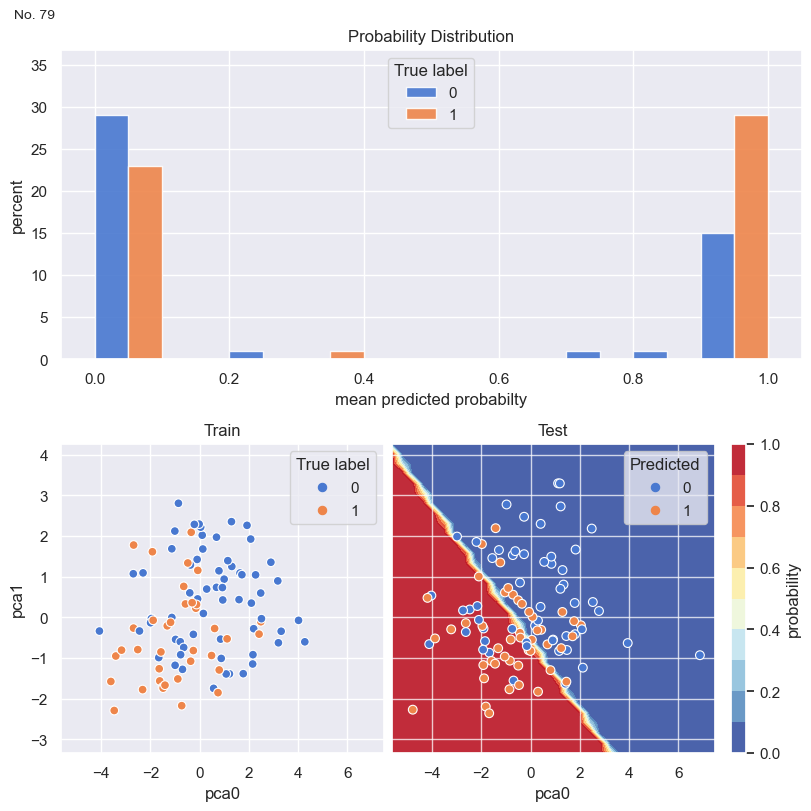

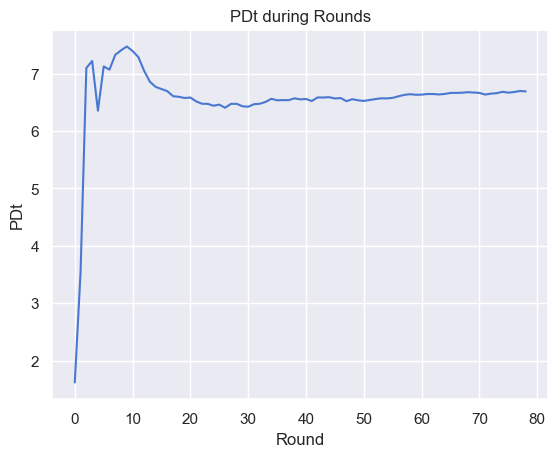

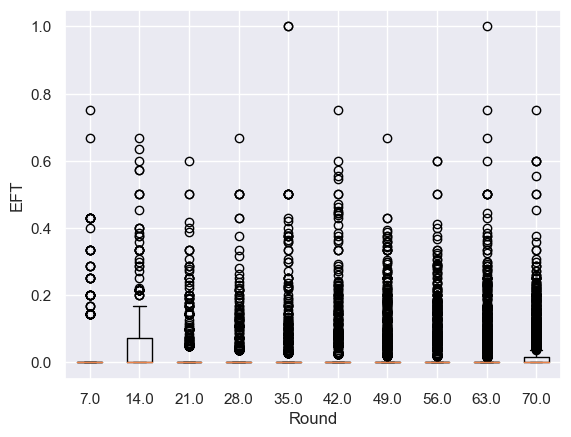

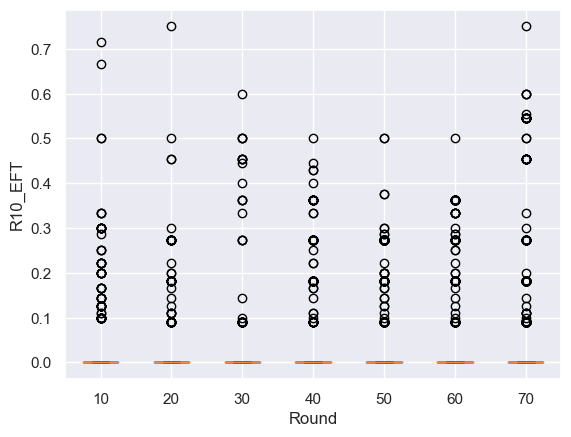

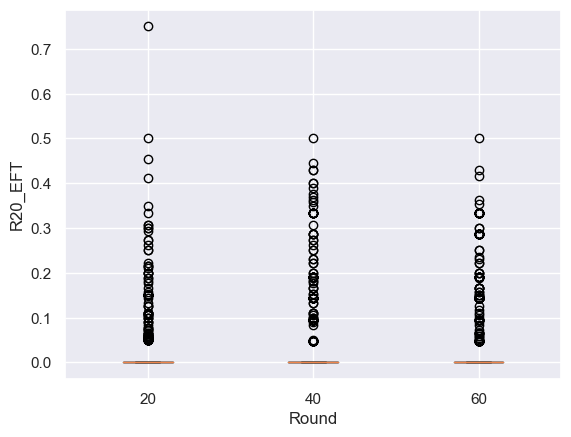

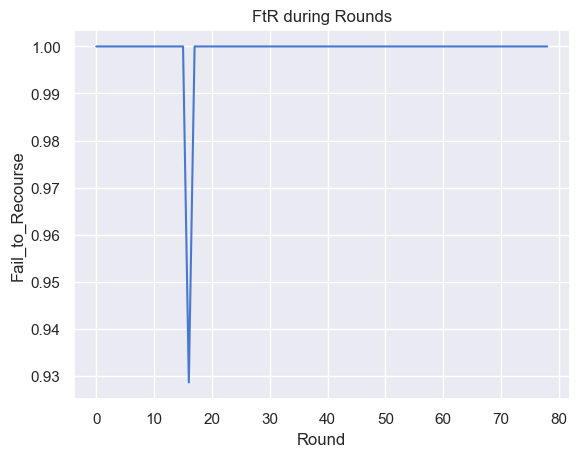

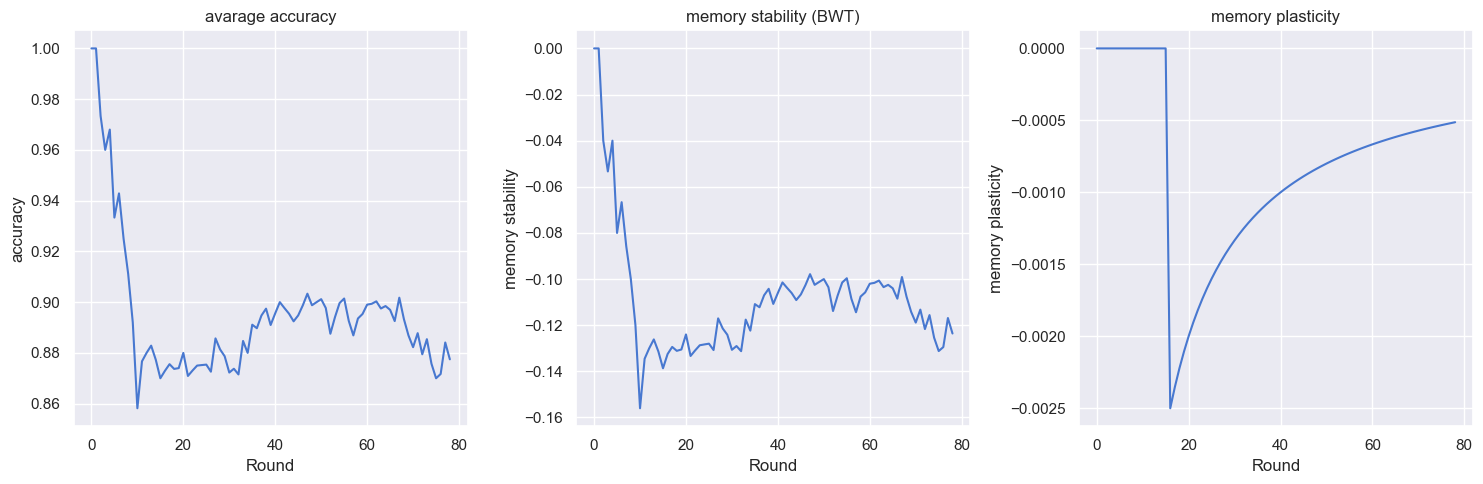

In [101]:
#binomial Recourse distribution    Prob = 0.01
class Example1(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a approximately size of `train.size * 0.02`.
    2. Performs recourse on the selected subset of 'sample' while preserving their original labels.
    3. Replaces a corresponding part of the training set with the updated samples.
    4. Refits the model with the modified training data.
    '''

    #add first k              k maybe 40% 80% 100%

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        print("round: ",self.round)
        #get model parameters before model updated
        modelParams = list(model.parameters())
        weights = deepcopy(modelParams[0].data.reshape(-1))
        bias = deepcopy(modelParams[1].data)
        # print("Before update: ")
        # print(modelParams)
        # print(weights,bias)


        size = train.x.shape[0] // 4
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]
        # print("x:",x)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        # print("predict: ",y_prob.data)
        y_pred = y_prob.flatten() < 0.5
        print("y_pred: ",y_pred)
        print("~y_pred: ",(~y_pred).float())
        
        # Performs recourse on the selected samples with binomial distributed destination.
        binomialData = np.random.binomial(1,BinomialProb,np.count_nonzero(y_pred)).astype(bool)
        print("binomial data: ",binomialData)
        # y_pred[y_pred == True] = pt.from_numpy(binomialData)
        recourseIndex = deepcopy(y_pred)
        print("before binomial",recourseIndex)
        recourseIndex[recourseIndex == True] = pt.from_numpy(binomialData)
        print("binomial y_pred",y_pred)
        print("binomial recourseIndex",recourseIndex)
        sub_sample = Dataset(x[recourseIndex], pt.full((recourseIndex.count_nonzero(), 1),1.0))
        
        print("do the recourse")
        print("len subsample",len(sub_sample))
        # recourse(model, sub_sample, 10,weight,loss_list=[])
        if len(sub_sample) > 0:
            recourse(model, sub_sample, 10)
        
            print("sub_sample x:",sub_sample.x)
            print("sub_sample y:",sub_sample.y)
            test = deepcopy(x)
            print("x : ",test)

            x[recourseIndex] = sub_sample.x
            
            print("after recourse")
            print("check eq :",pt.eq(test,x))

        j = np.random.choice(train.x.shape[0], size, False)
        train.x[j] = x
        train.y[j, 0] = (~y_pred).float()
        
        # index = y_prob.flatten() > 0.5
        # k = round(len(index) * 0.4)
        # index = y_prob[index].numpy().argpartition(k)
        # train.y[]

        val_data = Dataset(train.x[j], train.y[j])
        self.validation_list.append(val_data)
        sample_model = LogisticRegression(val_data.x.shape[1], 1)
        sample_model.train()
        training(sample_model, val_data, 30)
        self.Aj_tide_list.append(self.calculate_accuracy(sample_model(val_data.x), val_data.y))

        #紀錄新增進來的sample資料
        self.addEFTDataFrame(j)


        training(model, train, 50)

        # calculate the overall accuracy
        self.overall_acc_list.append(self.calculate_AA(model, self.validation_list))
        # evaluate memory stability
        self.memory_stability_list.append(self.calculate_BWT(model, self.validation_list, self.Ajj_performance_list))
        # evaluate memory plasticity
        self.memory_plasticity_list.append(self.calculate_FWT(self.Ajj_performance_list, self.Aj_tide_list))


        #紀錄Fail_to_Recourse
        if len(x[y_pred]) > 0:
            with pt.no_grad():
                y_prob: pt.Tensor = model(x[y_pred])

            # print("x[y_pred] : ",x[y_pred])
            # print("after model update:")
            # print("y_prob:",y_prob)
            # print("y_prob[y_prob < 0.5]",y_prob[y_prob < 0.5])
            recourseFailCnt = len(y_prob[y_prob < 0.5])
            # print("recourseFailCnt",recourseFailCnt)
            recourseFailRate = recourseFailCnt / len(x[y_pred])
            # print("recourseFailRate : ",recourseFailRate)
            self.failToRecourse.append(recourseFailRate)
        else:
            print("no Recourse:")
            self.failToRecourse.append(0)

        self.EFTdataframe = self.EFTdataframe.assign(updateRounds = self.EFTdataframe['updateRounds'] + 1)
        self.round = self.round + 1


        #updated model predict the data with new sample
        data = np.vstack(self.EFTdataframe['x'])
        with pt.no_grad():
            y_pred = model(pt.tensor(data,dtype = pt.float))

        #set prob 0.5 as threshold
        predictValue = deepcopy(y_pred.data)
        predictValue[predictValue > 0.5] = 1.0
        predictValue[predictValue < 0.5] = 0.0
        predictValue = predictValue.numpy().T.reshape(-1)
        # print("predictValue: ",predictValue)
        # print("data type: ",type(predictValue))

        #store the updated model predict value
        for i in self.EFTdataframe.index:
            self.EFTdataframe.at[i,'Predict'].append(predictValue[i])
         # self.EFTdataframe.loc[predictValue.numpy().T.reshape(-1) != self.EFTdataframe['Predict'],['flip_times']] += 1

         #check whether the output flip out
        for i in self.EFTdataframe.index:
            predictLength = len(self.EFTdataframe.at[i,'Predict'])
            # if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][predictLength - 2] != self.EFTdataframe.at[i,'Predict'][predictLength - 1]):
            if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][-2] != self.EFTdataframe.at[i,'Predict'][-1]):
                # self.EFTdataframe.loc[(self.EFTdataframe['rounds'] - self.EFTdataframe['startRounds'] > 1) and self.EFTdataframe['Predict'][self.round - 2] != self.EFTdataframe['Predict'][self.round - 1] ,['flip_times']] += 1
                self.EFTdataframe.at[i,'flip_times'] += 1

        #update EFP values
        self.EFTdataframe.loc[(self.EFTdataframe['updateRounds'] - 1) > 0,['EFT']] = self.EFTdataframe['flip_times'] / (self.EFTdataframe['updateRounds'] - 1)

        for i in self.EFTdataframe.index:
            if len(self.EFTdataframe.at[i,'Predict']) > 1:
                # self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
                self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'EFT'])

        # display(self.EFTdataframe)
        #calculate the PDt
        modelParams = list(model.parameters())
        modelParameter = np.concatenate((weights,bias))
        resultParameter = np.concatenate((modelParams[0].data.reshape(-1),modelParams[1].data))
        # print("Before update: ")
        # print(weights,bias)
        # print("After update: ")
        # print(modelParams[0].data.reshape(-1),modelParams[1].data)

        parameterL2 = np.linalg.norm(resultParameter - modelParameter)

        self.PDt.append(parameterL2)

# weight = pt.from_numpy(np.random.gamma(3,1,20))
# print(train.x)
# print(train.y)
BinomialProb = 0.01
ex1 = Example1(model, pca, train, test, sample)
ani1 = ex1.animate_all(80)
ani1.save('ex1_binomial1.gif')

# ex1.draw_PDt()
ex1.draw_PDt()
ex1.draw_EFT(80)
ex1.draw_R20_EFT(80,10)
ex1.draw_R20_EFT(80,20)
# ex1.draw_R20_EFT(80,58)
ex1.draw_Fail_to_Recourse()
display(ex1.EFTdataframe)
ex1.plot_matricsA()


In [ ]:
class Example6(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.02`.
    2. Performs recourse on the selected samples.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        y_pred = y_prob.flatten() < 0.5
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))

        recourse(model, sub_sample, 5)

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()

        training(model, train, 20)


ex6 = Example6(model, pca, train, test, sample)
ani5 = ex6.animate_all(200)
ani5.save('output/ex5.mp4')

outside:  tensor([0.3677, 0.2117, 0.4254, 0.3385, 0.3672, 0.2777, 0.3093, 0.3041, 0.1783,
        0.1412, 0.2686, 0.2681, 0.2728, 0.3979, 0.2907, 0.2103, 0.2808, 0.3028,
        0.3417, 0.2547], dtype=torch.float64)
weights:  tensor([0.3677, 0.2117, 0.4254, 0.3385, 0.3672, 0.2777, 0.3093, 0.3041, 0.1783,
        0.1412, 0.2686, 0.2681, 0.2728, 0.3979, 0.2907, 0.2103, 0.2808, 0.3028,
        0.3417, 0.2547], dtype=torch.float64)
weights:  tensor([0.3677, 0.2117, 0.4254, 0.3385, 0.3672, 0.2777, 0.3093, 0.3041, 0.1783,
        0.1412, 0.2686, 0.2681, 0.2728, 0.3979, 0.2907, 0.2103, 0.2808, 0.3028,
        0.3417, 0.2547], dtype=torch.float64)
weights:  tensor([0.3677, 0.2117, 0.4254, 0.3385, 0.3672, 0.2777, 0.3093, 0.3041, 0.1783,
        0.1412, 0.2686, 0.2681, 0.2728, 0.3979, 0.2907, 0.2103, 0.2808, 0.3028,
        0.3417, 0.2547], dtype=torch.float64)
weights:  tensor([0.3677, 0.2117, 0.4254, 0.3385, 0.3672, 0.2777, 0.3093, 0.3041, 0.1783,
        0.1412, 0.2686, 0.2681, 0.2728, 0.3979

C:\Users\user\AppData\Local\Temp\ipykernel_53380\1941710507.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, layout='constrained')


weights:  tensor([0.3677, 0.2117, 0.4254, 0.3385, 0.3672, 0.2777, 0.3093, 0.3041, 0.1783,
        0.1412, 0.2686, 0.2681, 0.2728, 0.3979, 0.2907, 0.2103, 0.2808, 0.3028,
        0.3417, 0.2547], dtype=torch.float64)
weights:  tensor([0.3677, 0.2117, 0.4254, 0.3385, 0.3672, 0.2777, 0.3093, 0.3041, 0.1783,
        0.1412, 0.2686, 0.2681, 0.2728, 0.3979, 0.2907, 0.2103, 0.2808, 0.3028,
        0.3417, 0.2547], dtype=torch.float64)
weights:  tensor([0.3677, 0.2117, 0.4254, 0.3385, 0.3672, 0.2777, 0.3093, 0.3041, 0.1783,
        0.1412, 0.2686, 0.2681, 0.2728, 0.3979, 0.2907, 0.2103, 0.2808, 0.3028,
        0.3417, 0.2547], dtype=torch.float64)
weights:  tensor([0.3677, 0.2117, 0.4254, 0.3385, 0.3672, 0.2777, 0.3093, 0.3041, 0.1783,
        0.1412, 0.2686, 0.2681, 0.2728, 0.3979, 0.2907, 0.2103, 0.2808, 0.3028,
        0.3417, 0.2547], dtype=torch.float64)
weights:  tensor([0.3677, 0.2117, 0.4254, 0.3385, 0.3672, 0.2777, 0.3093, 0.3041, 0.1783,
        0.1412, 0.2686, 0.2681, 0.2728, 0.3979

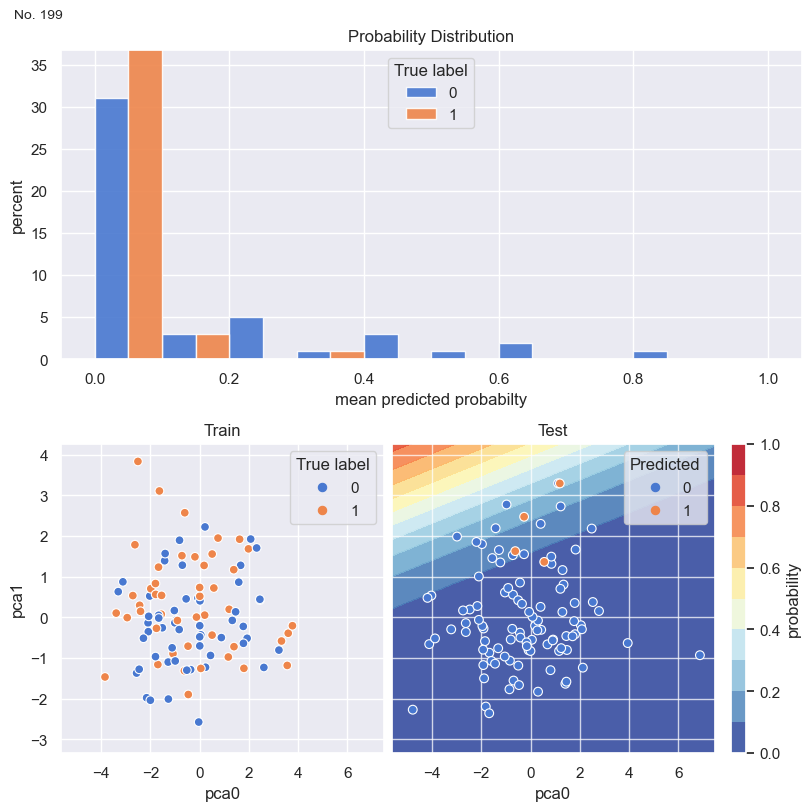

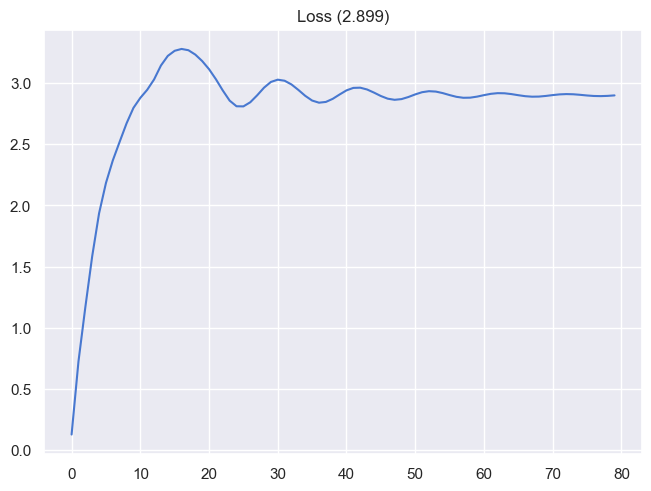

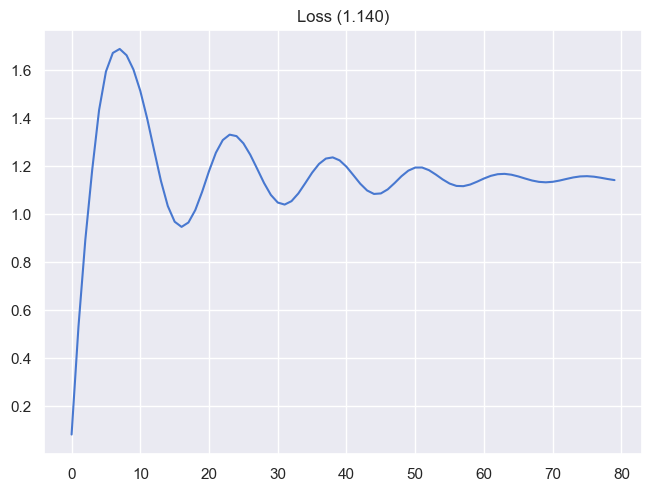

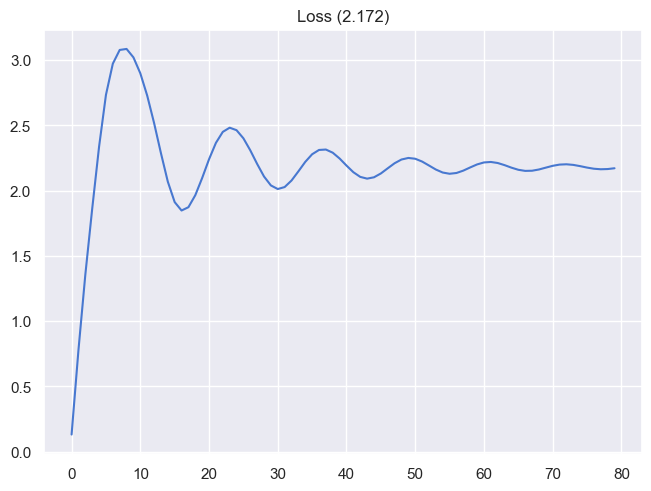

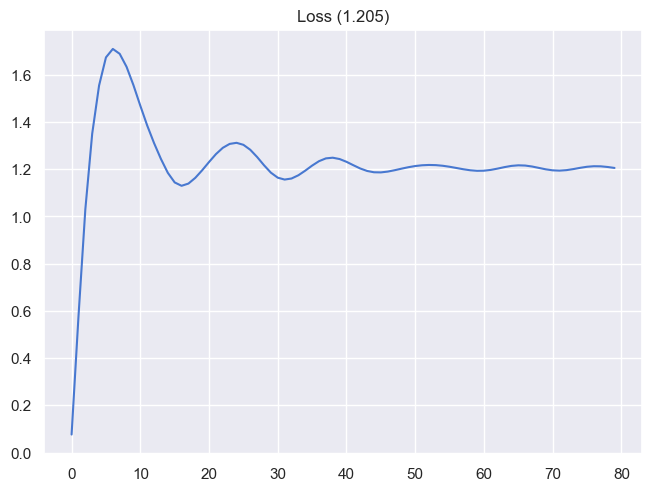

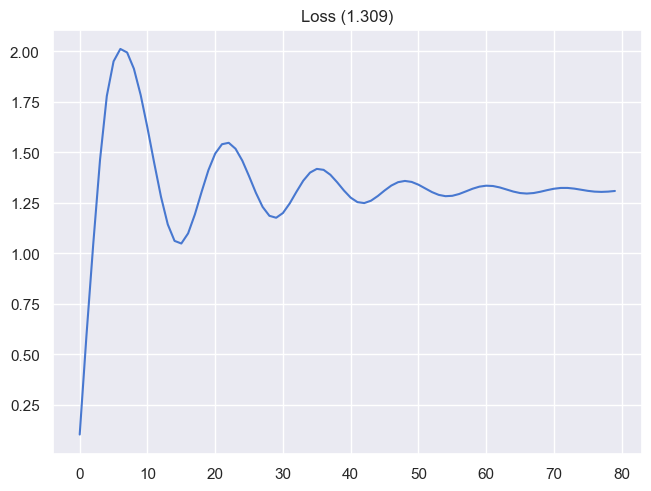

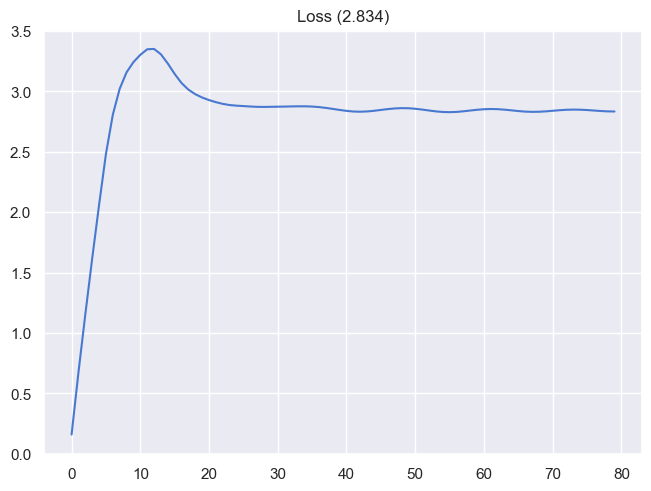

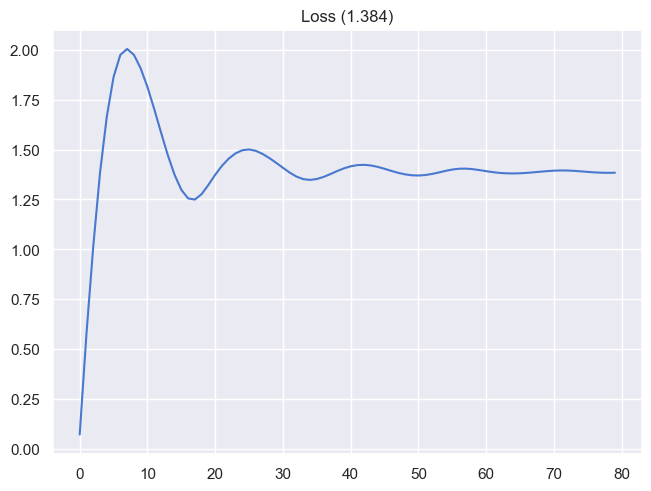

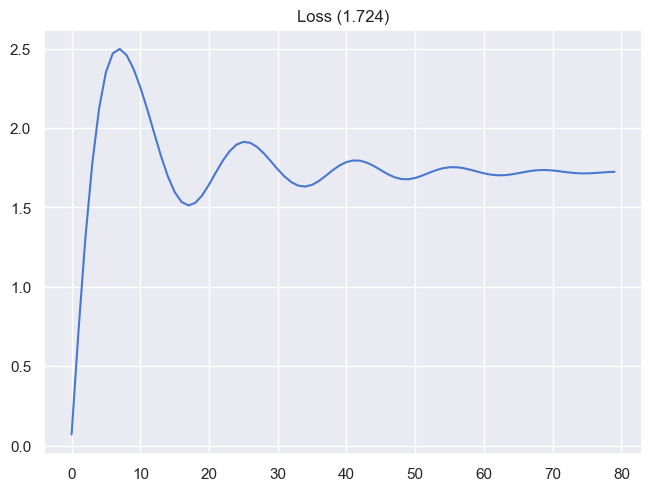

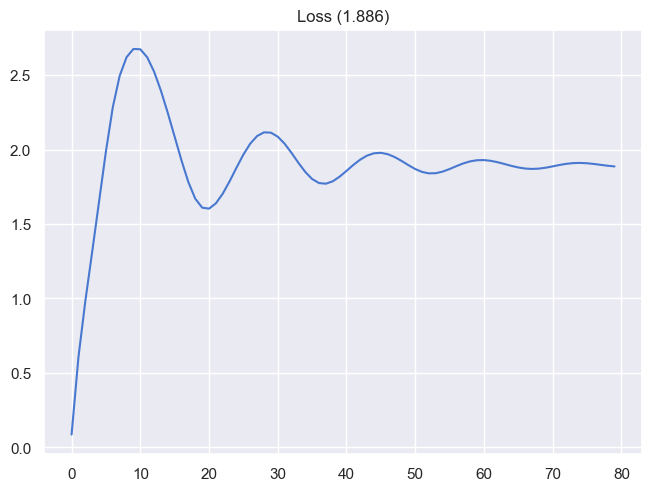

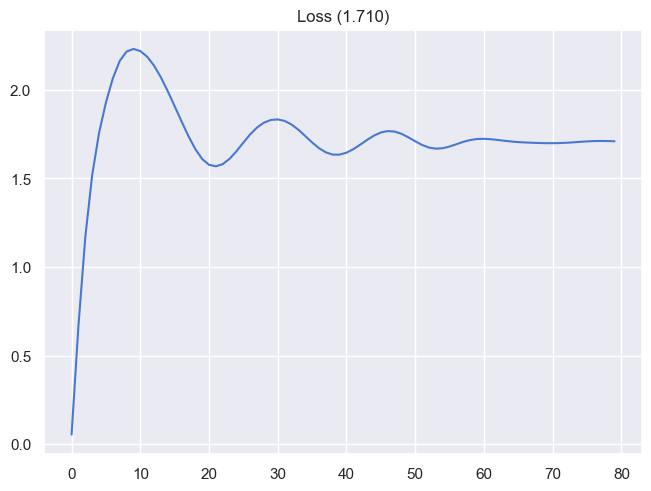

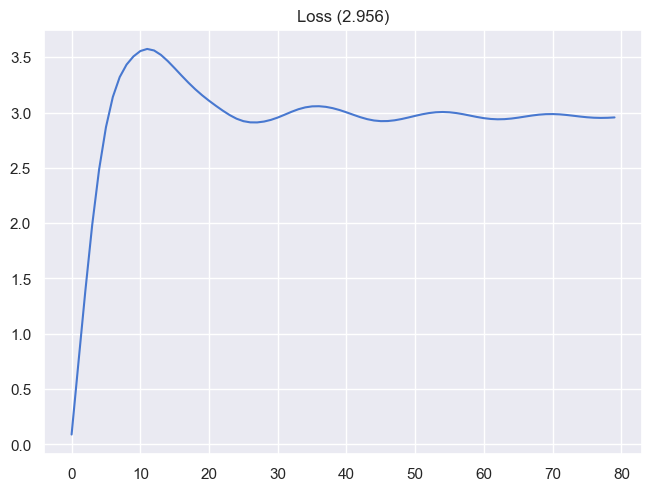

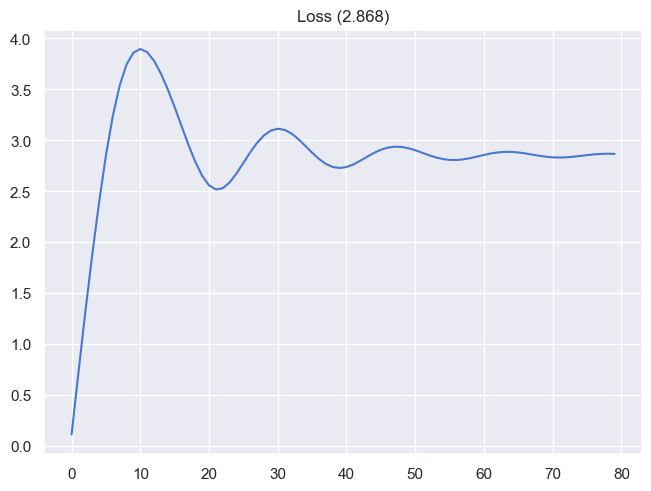

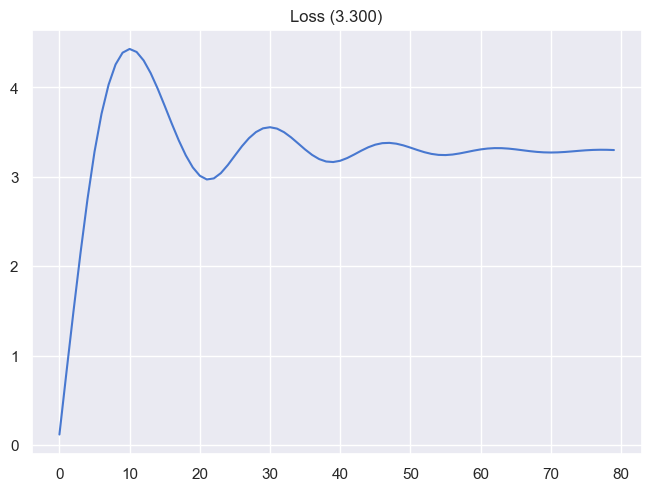

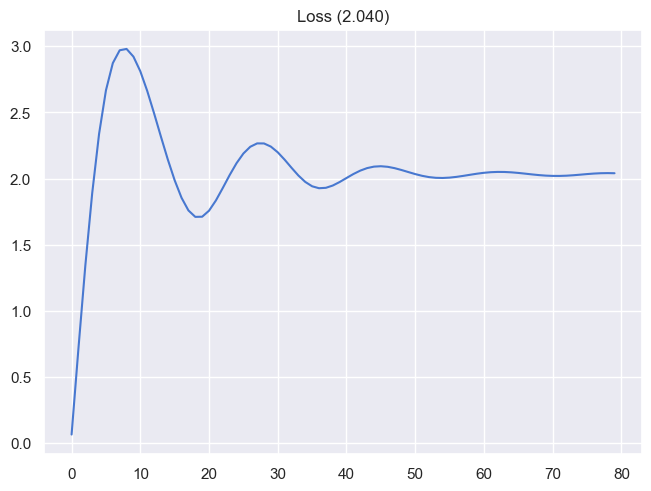

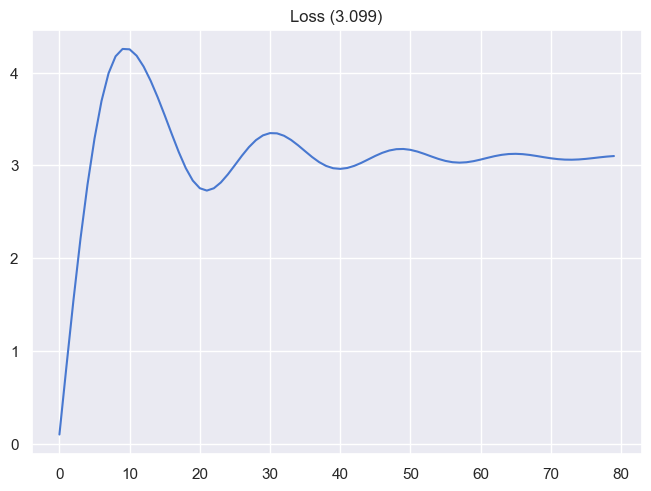

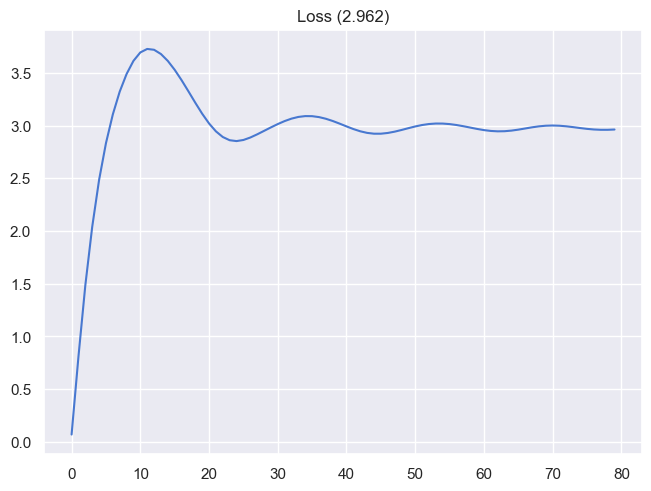

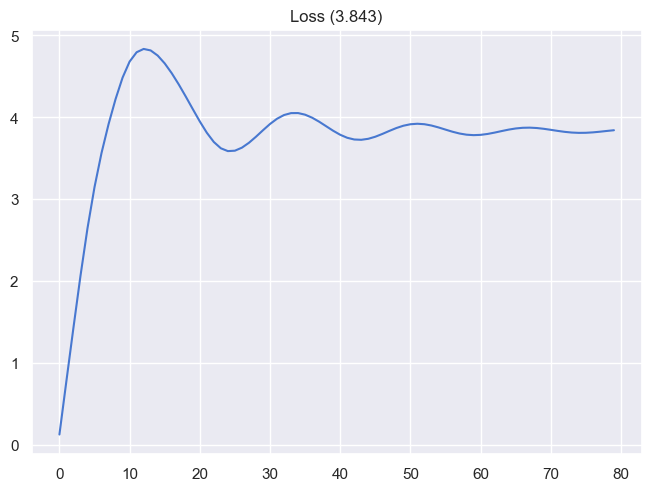

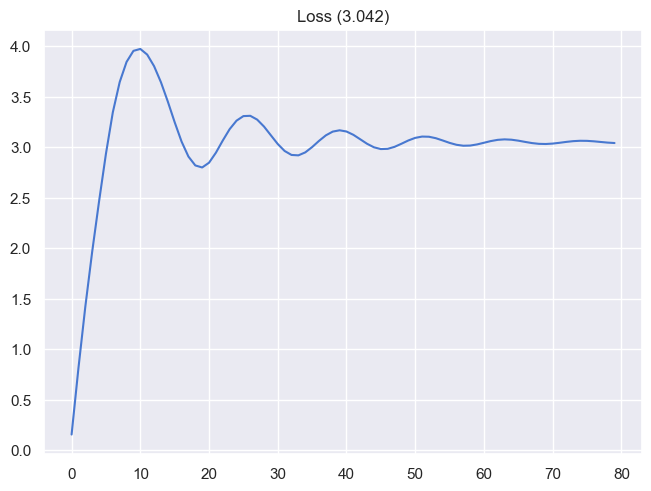

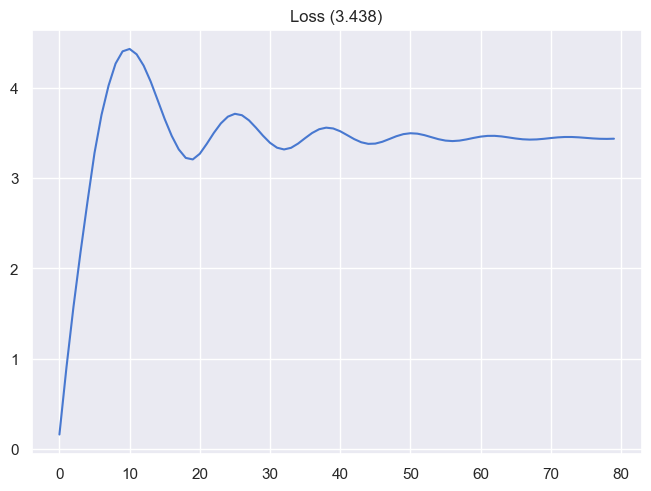

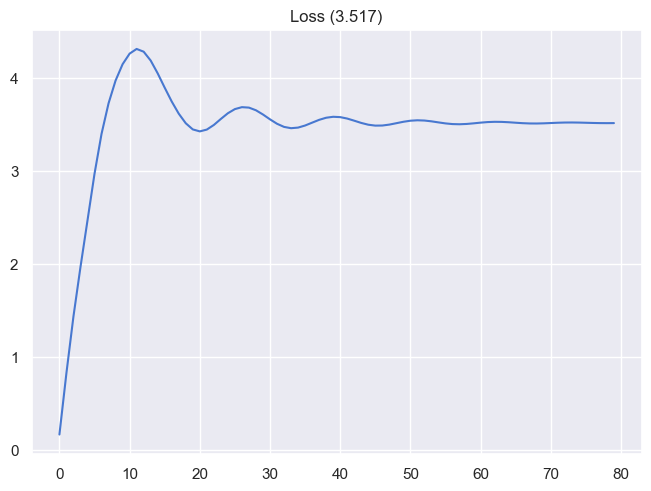

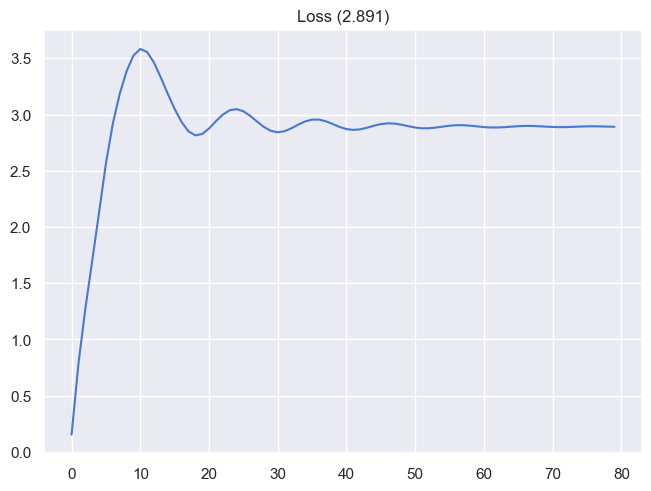

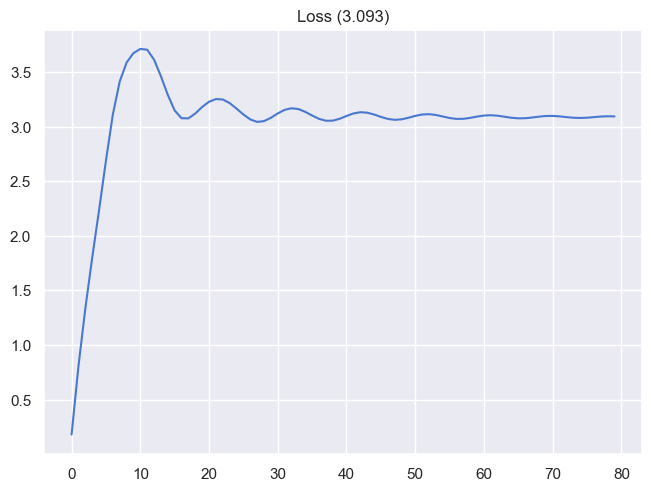

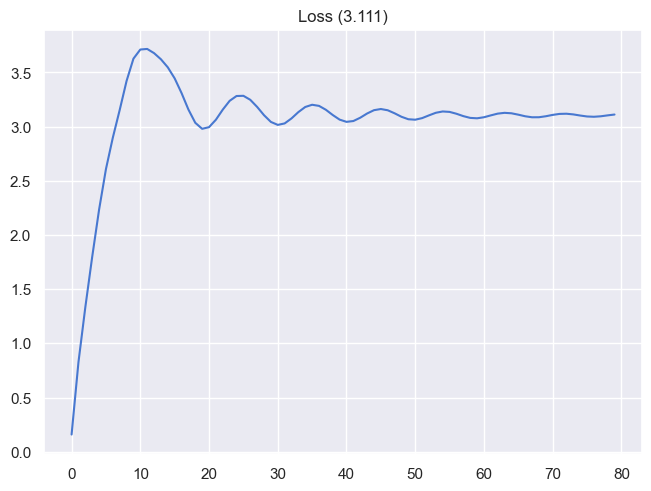

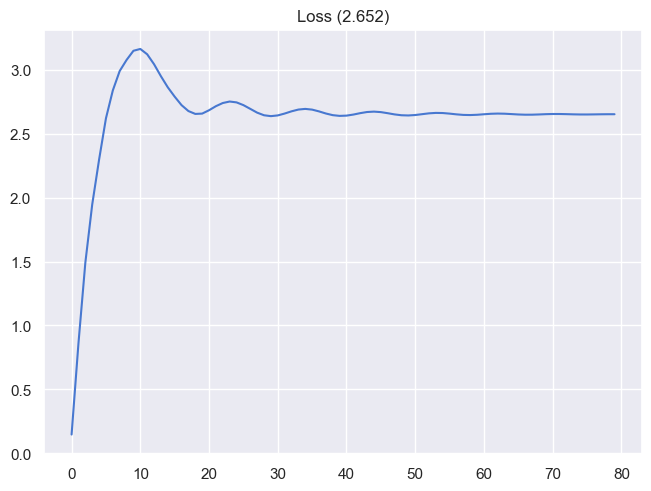

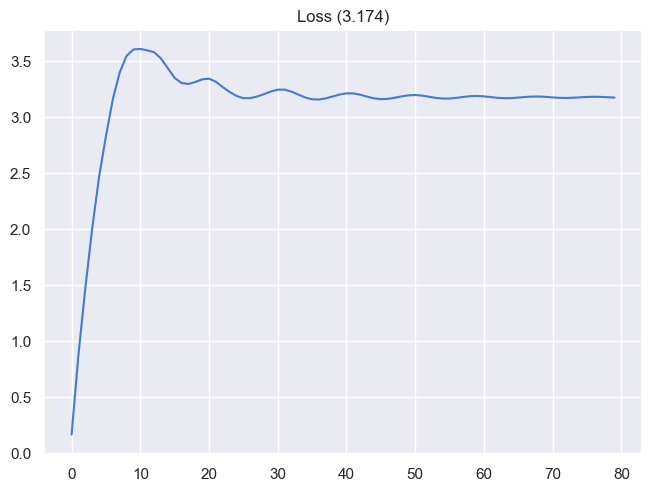

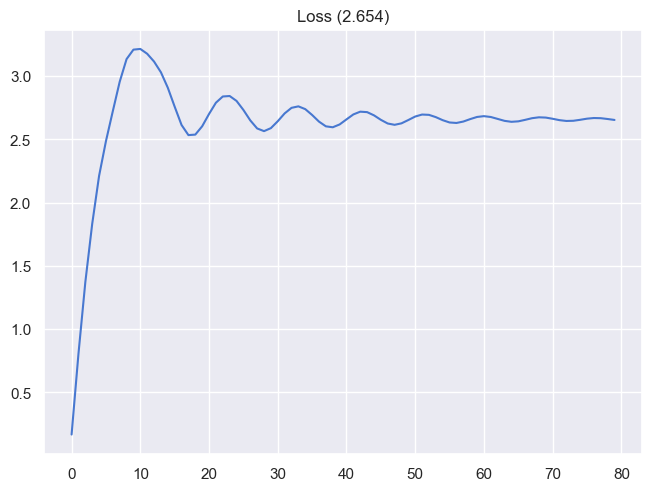

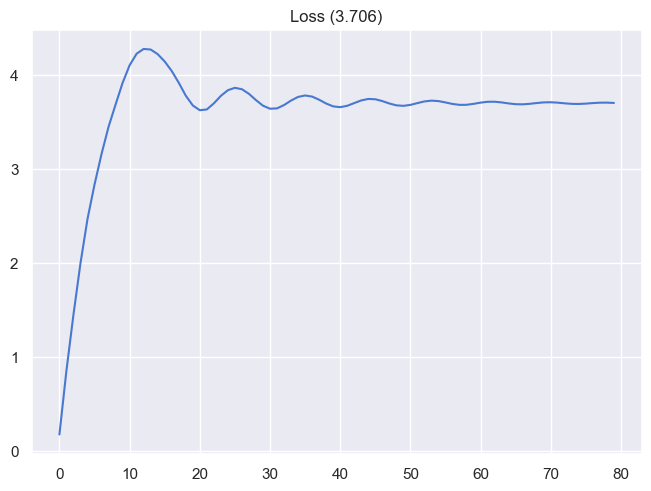

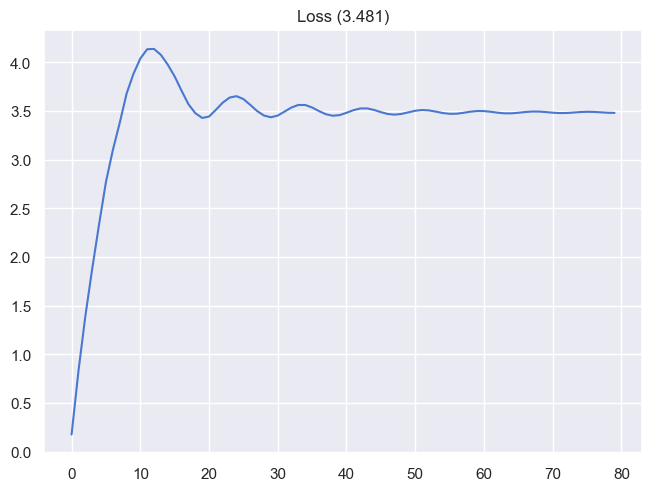

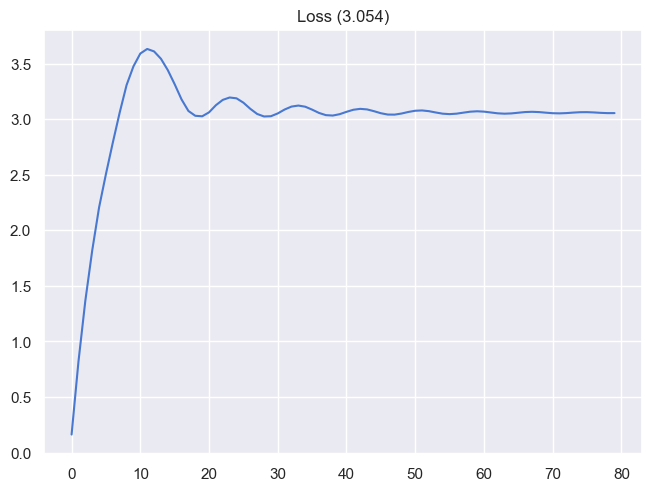

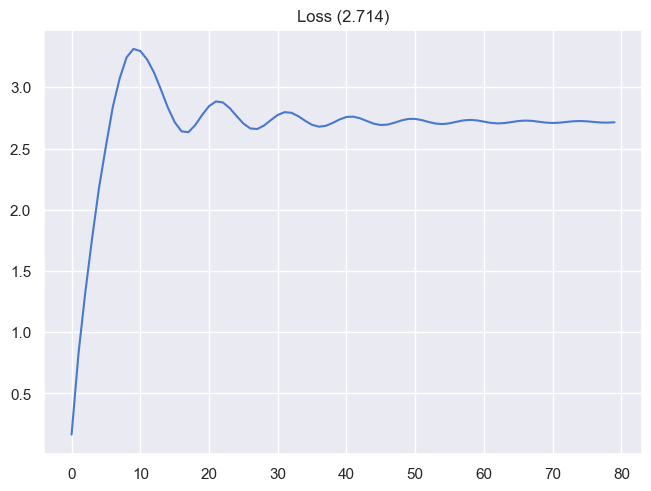

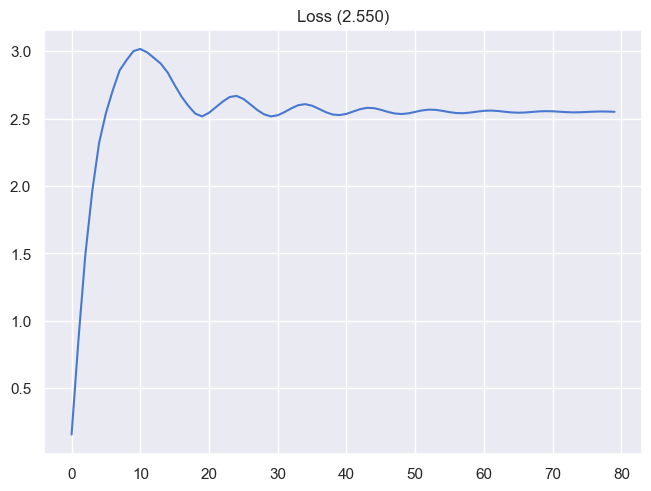

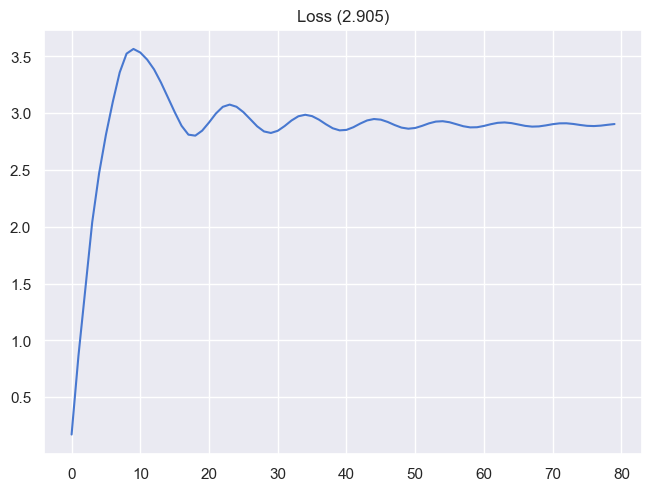

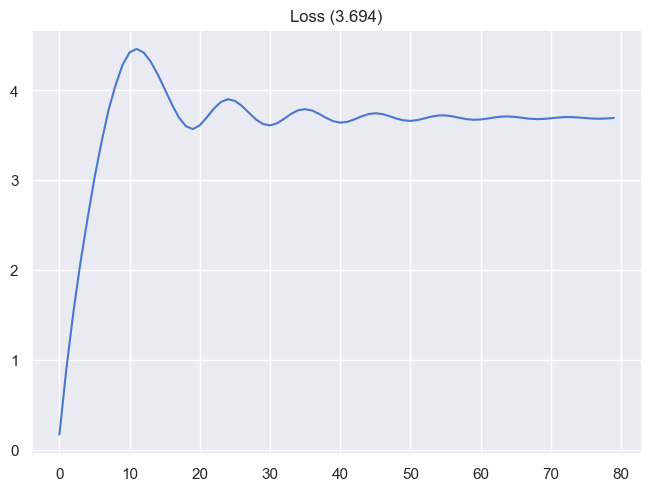

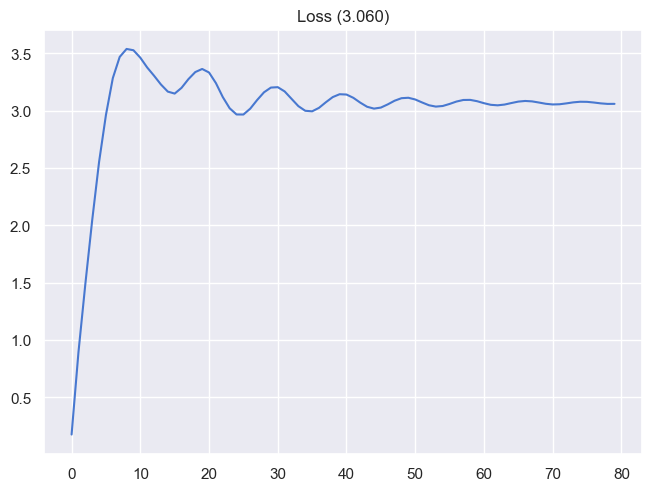

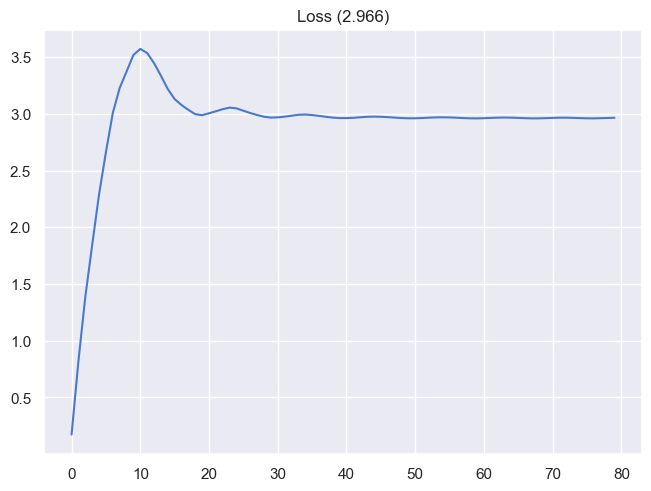

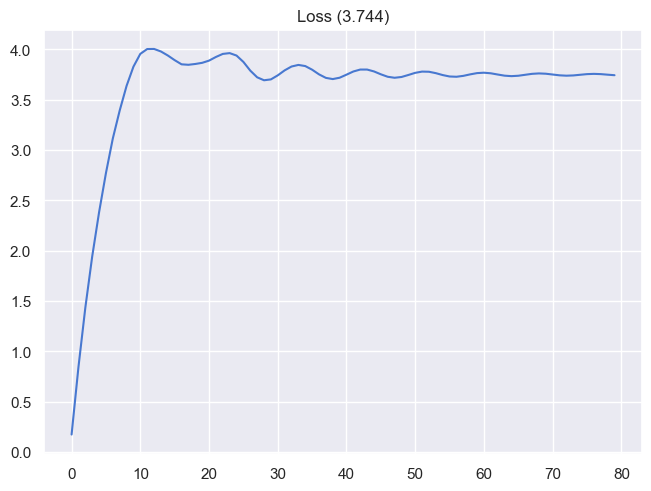

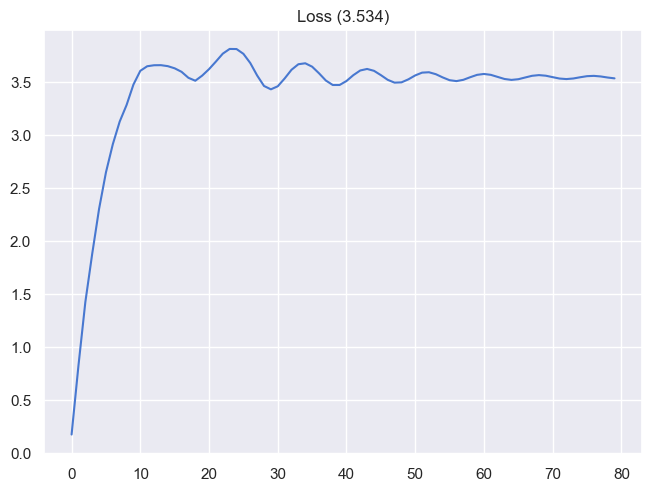

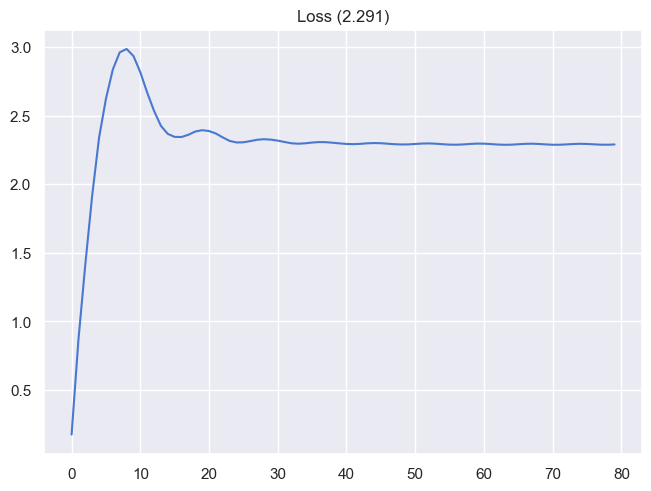

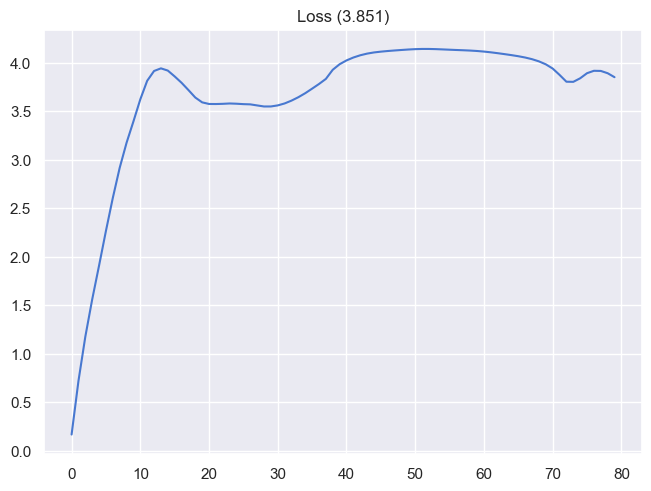

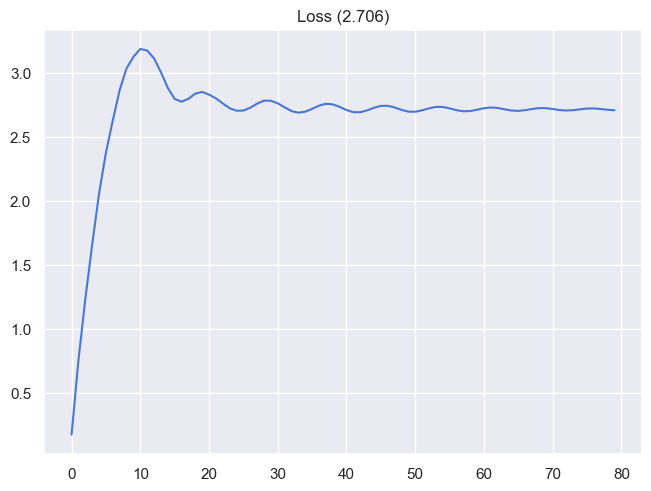

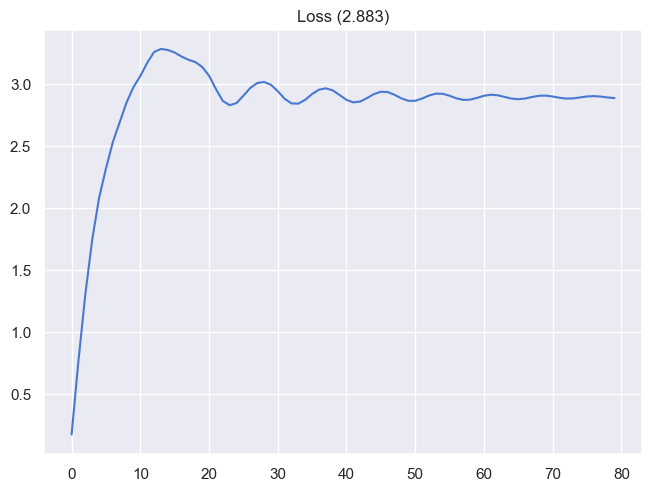

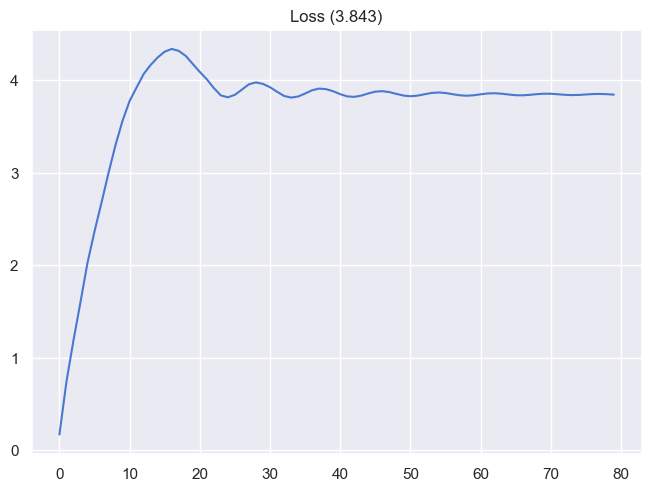

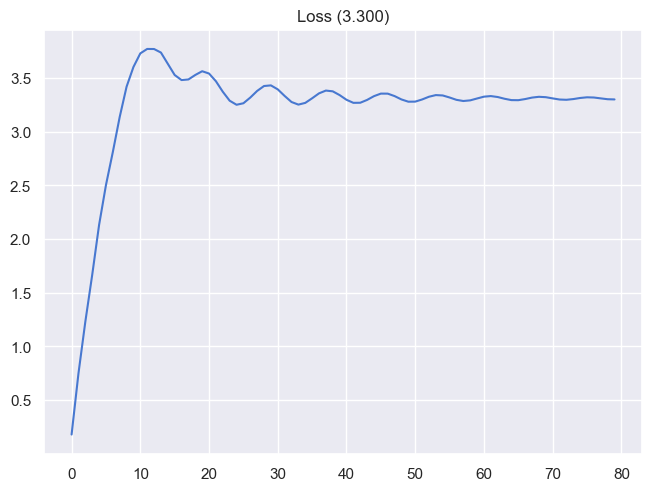

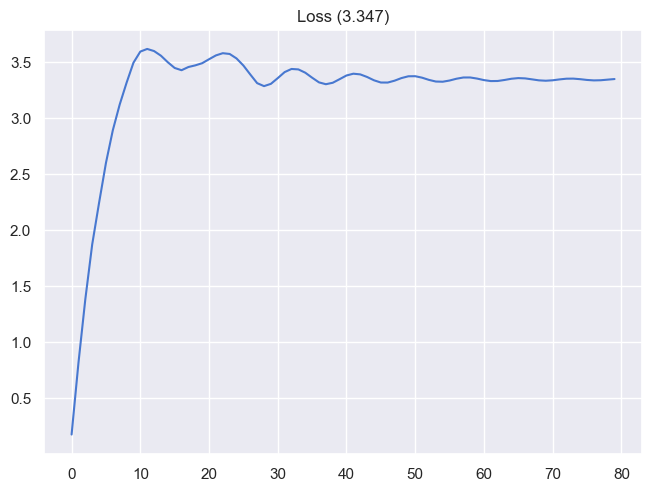

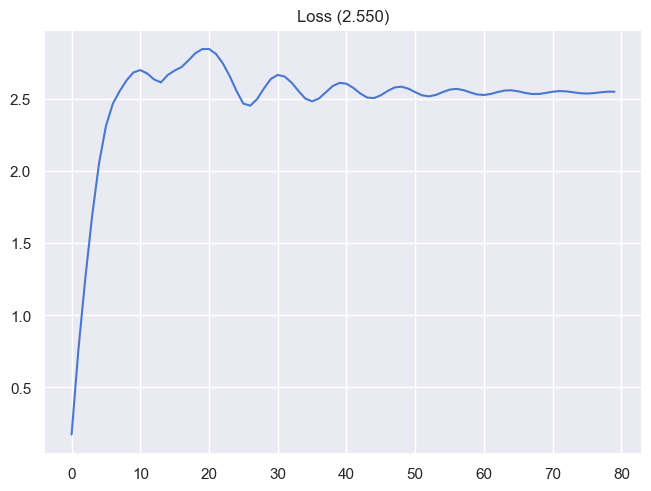

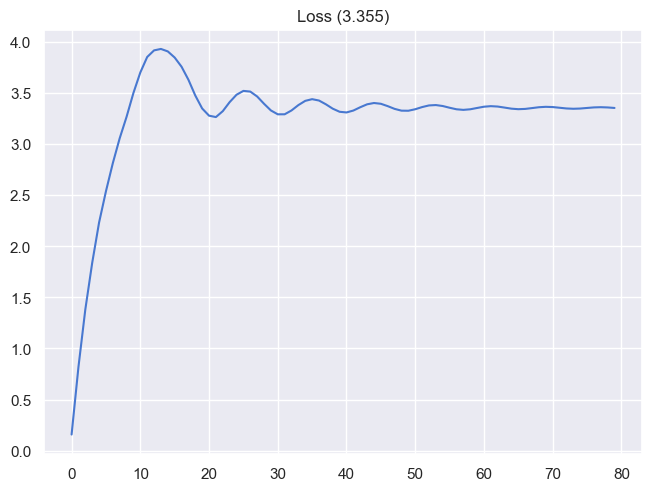

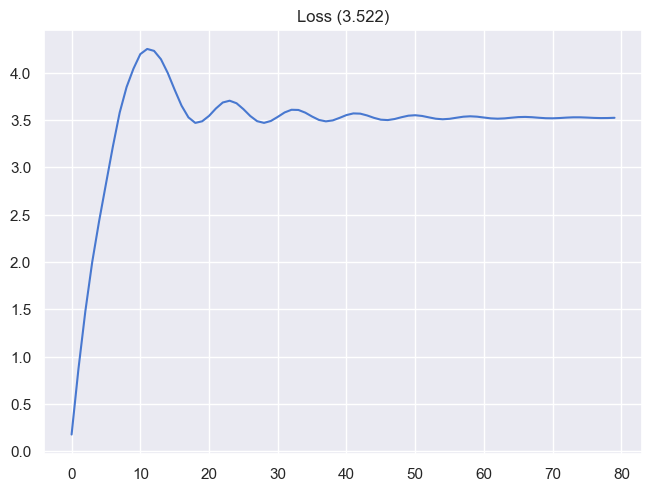

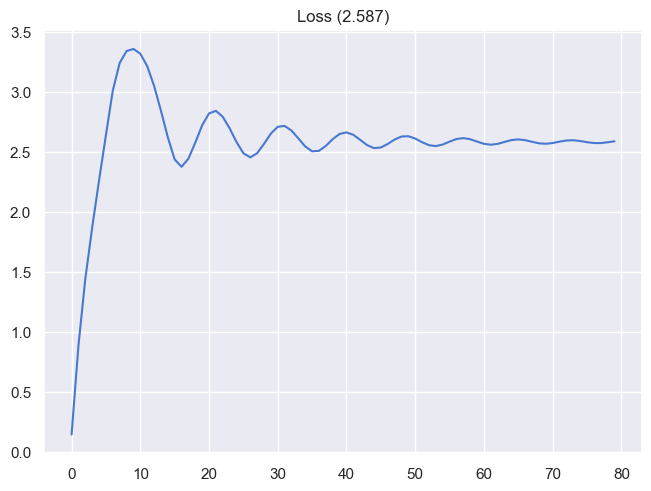

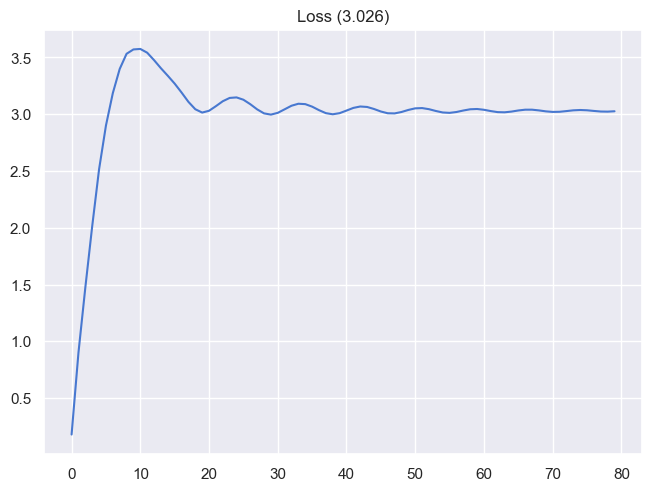

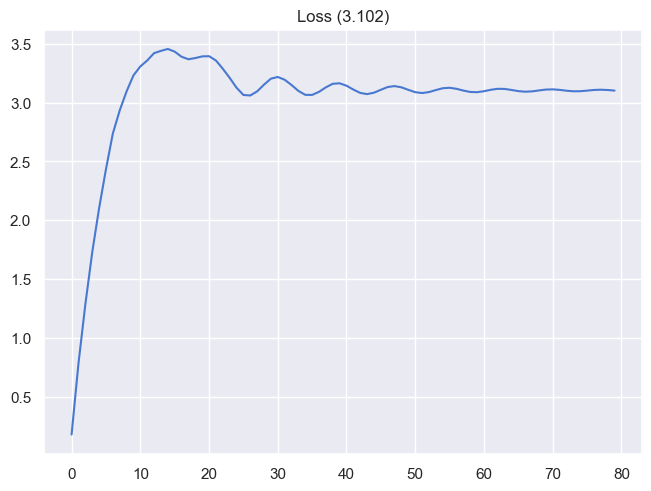

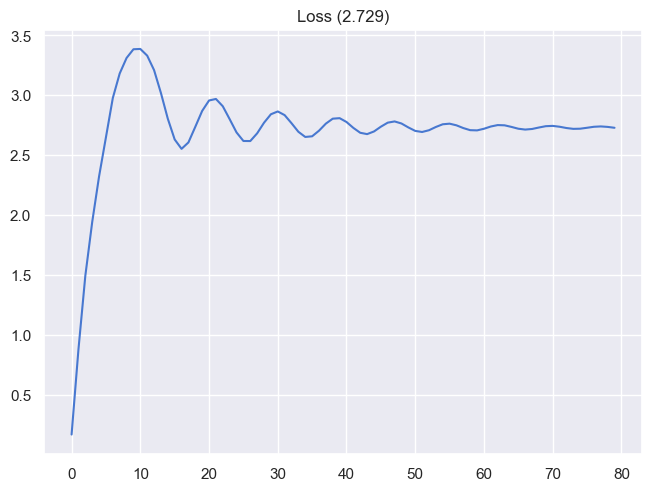

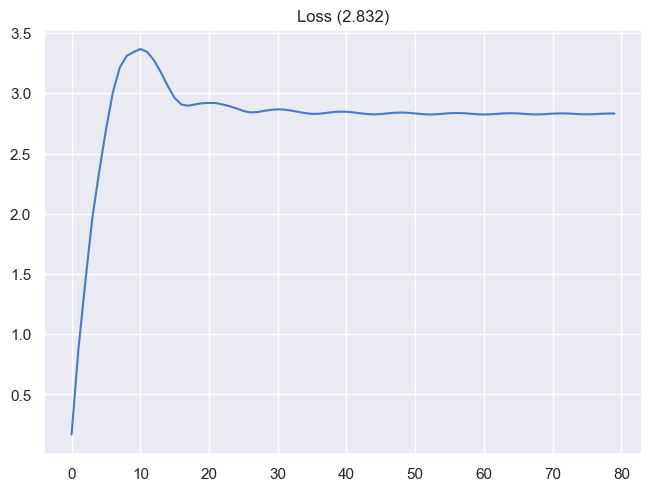

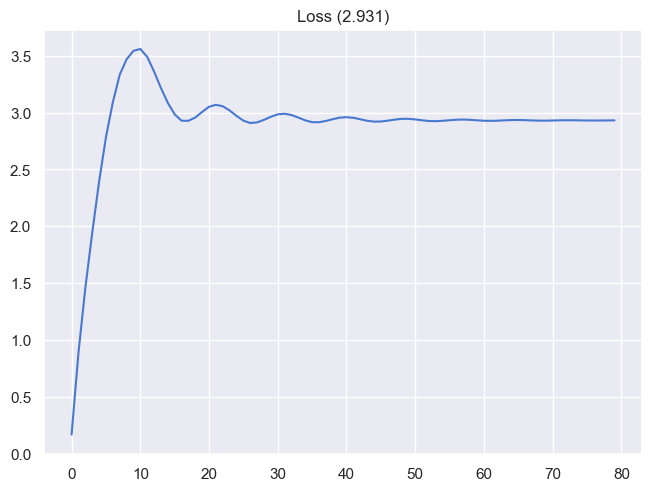

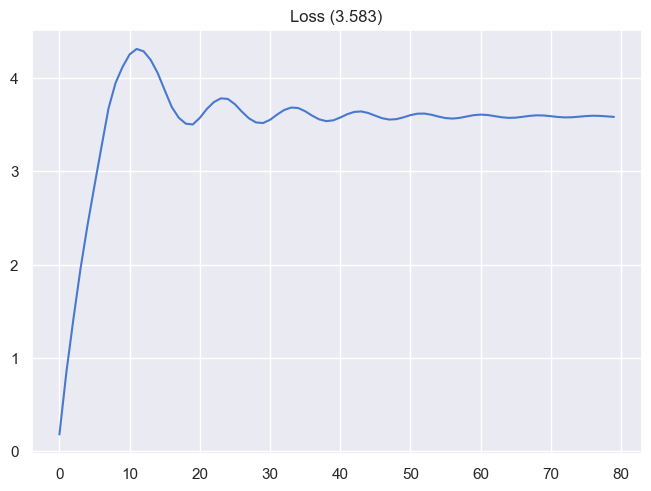

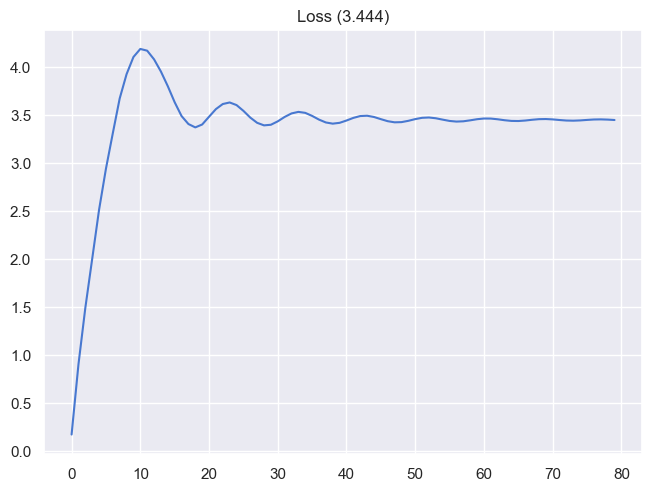

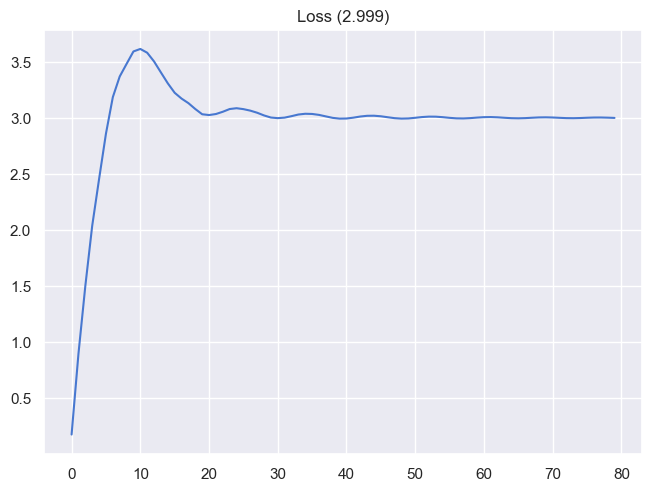

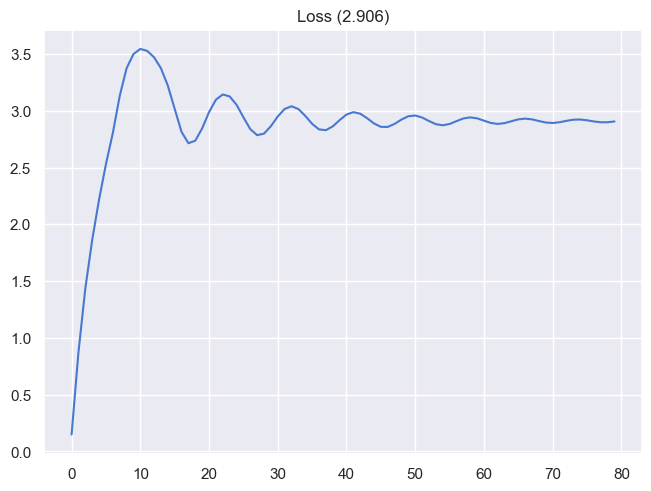

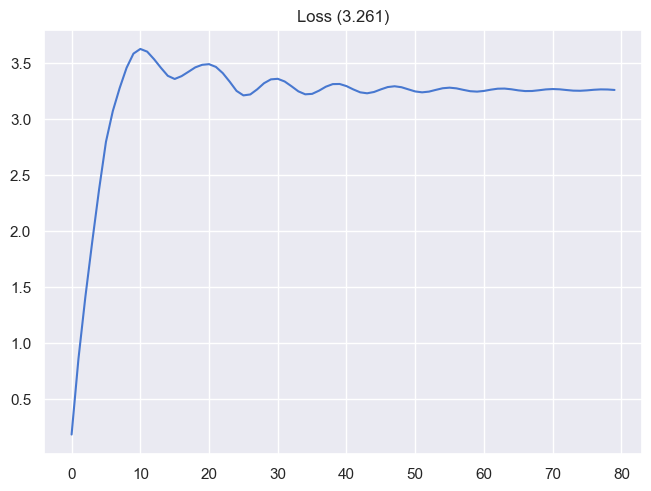

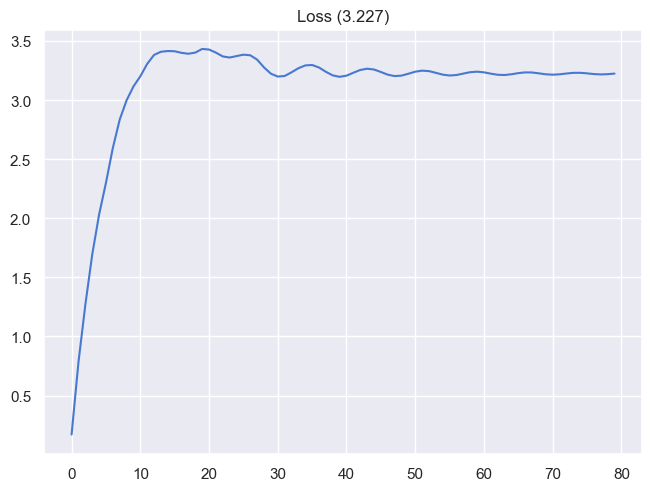

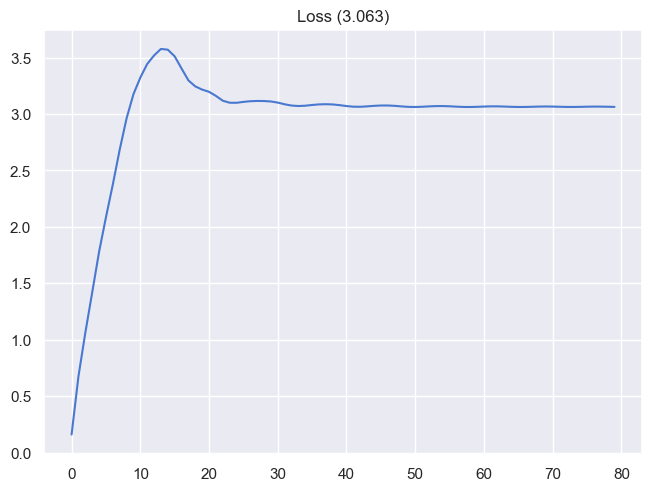

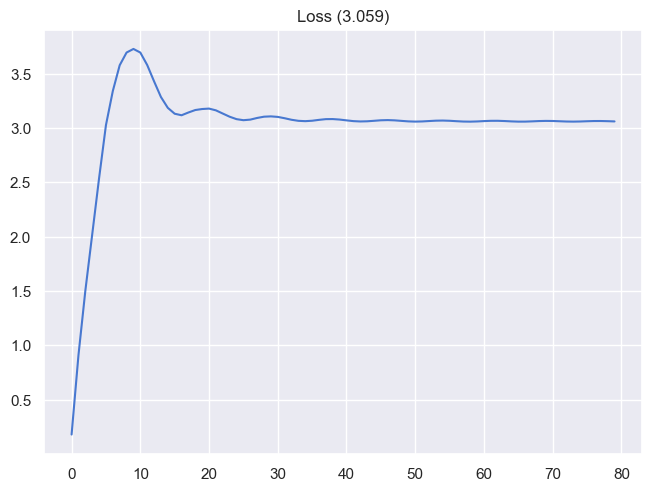

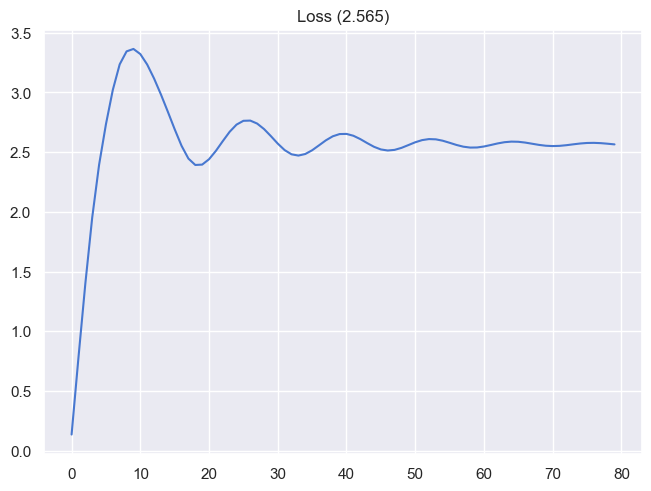

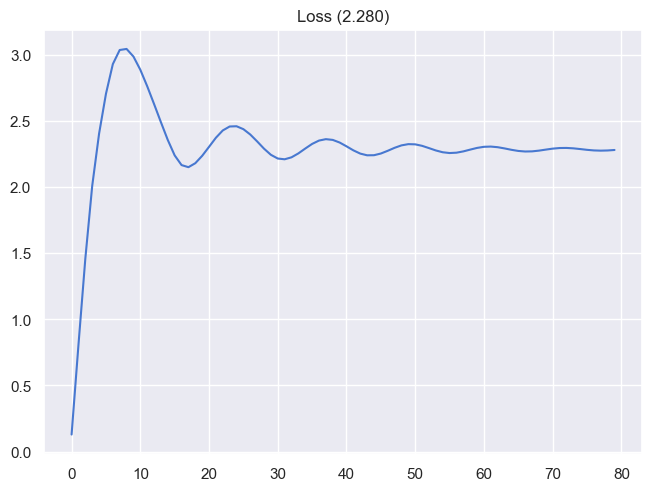

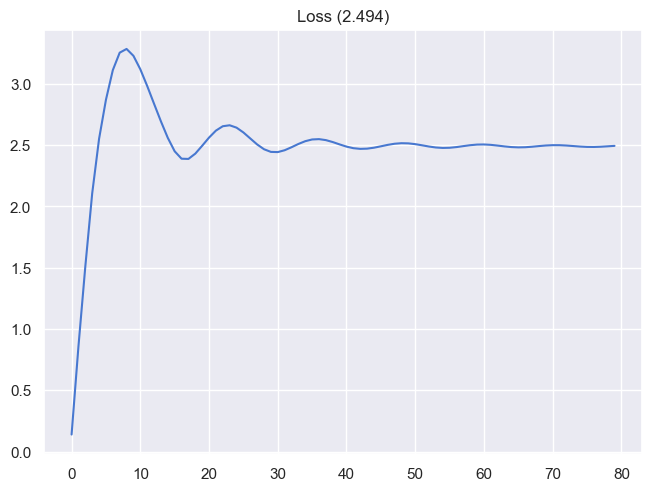

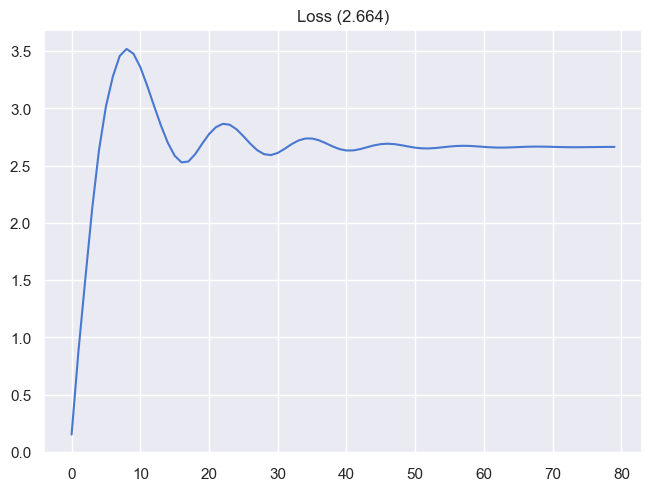

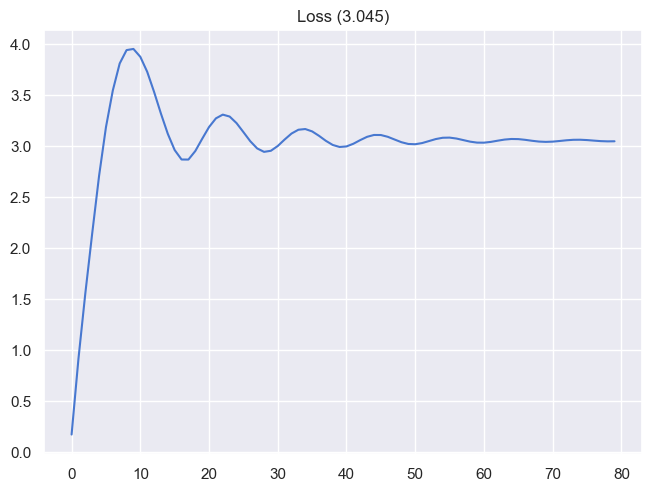

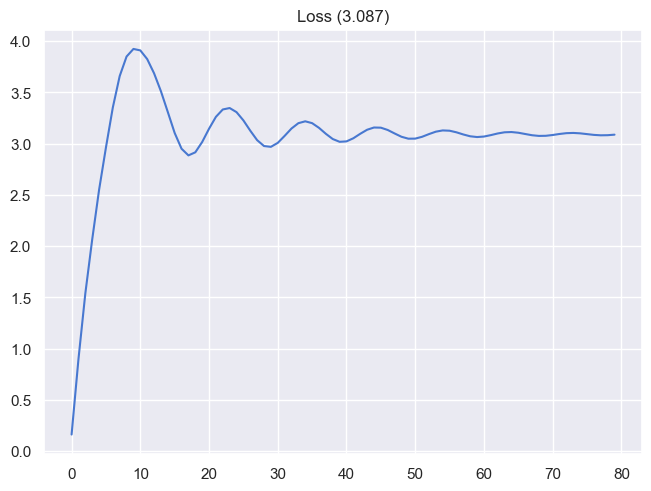

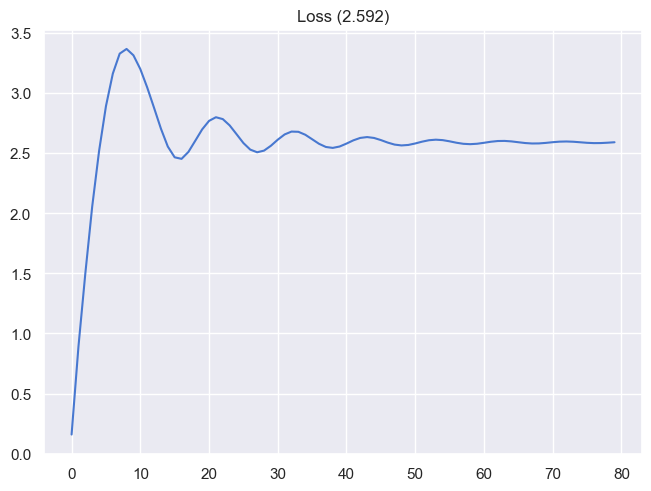

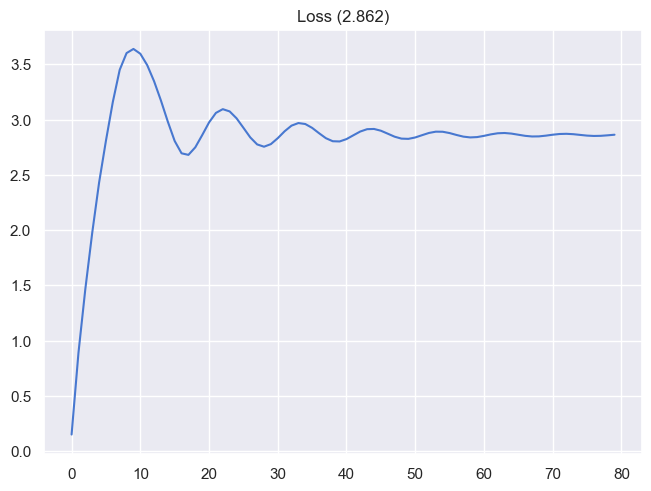

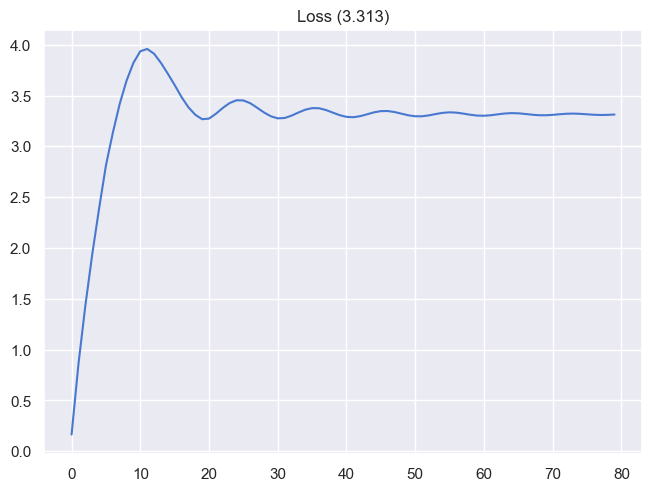

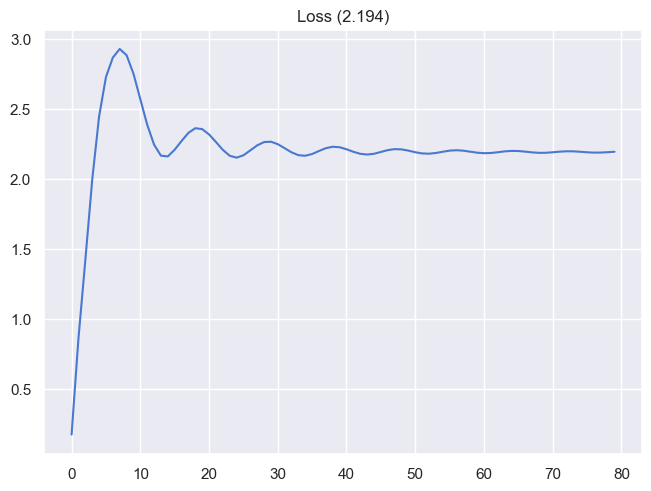

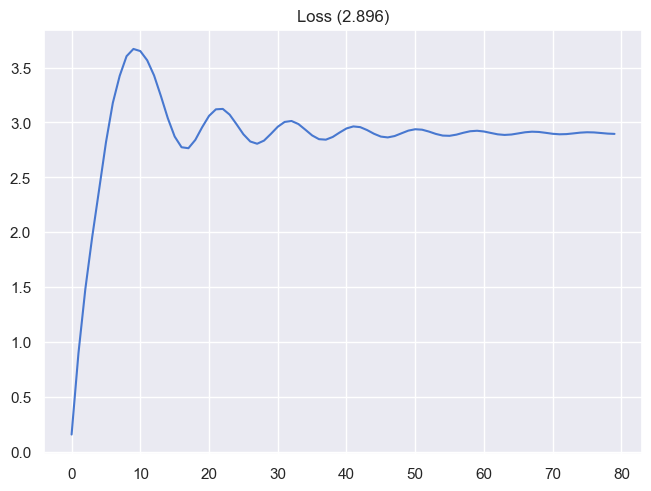

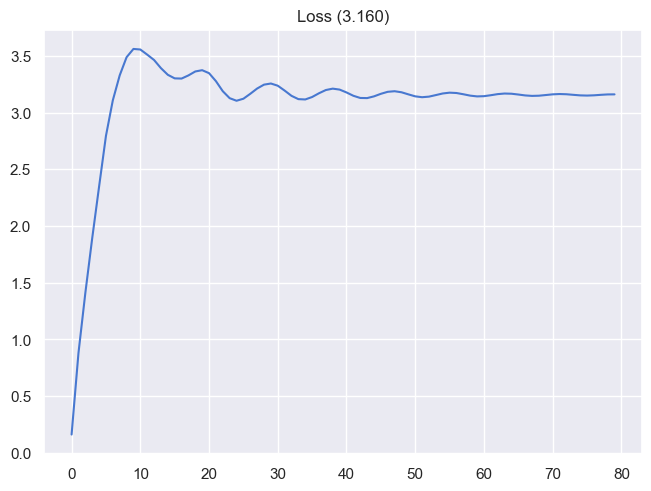

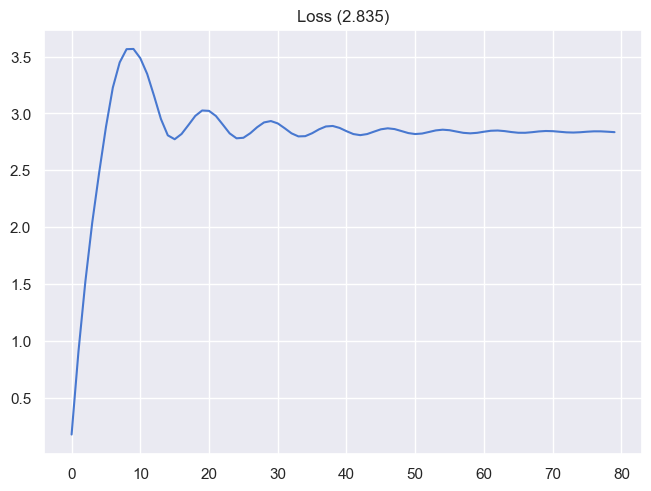

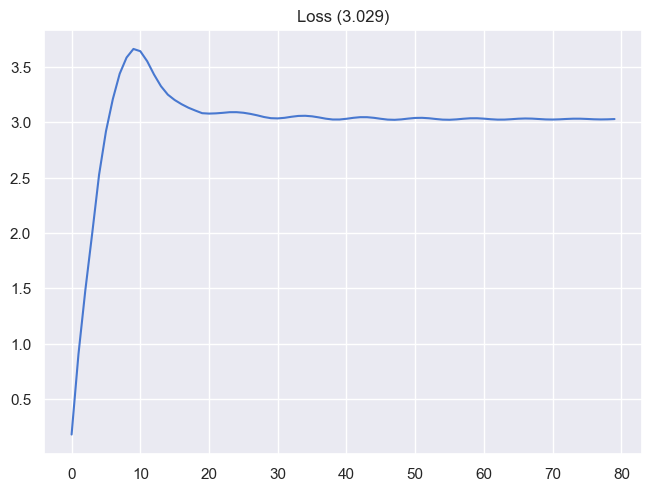

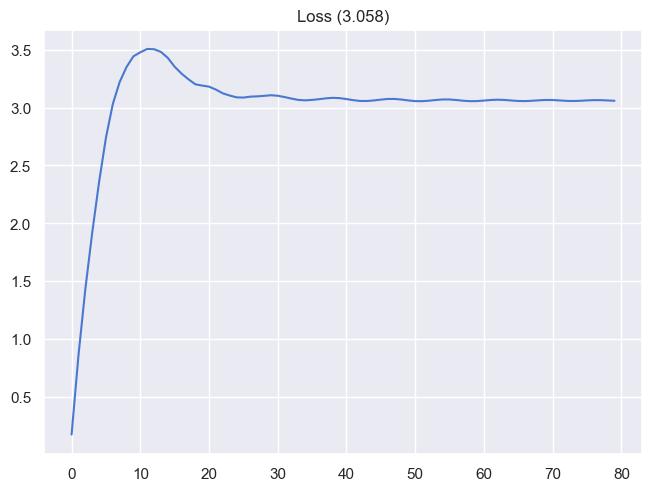

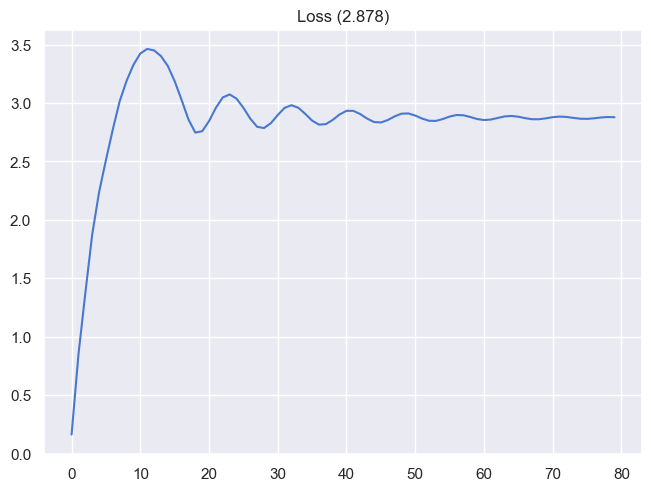

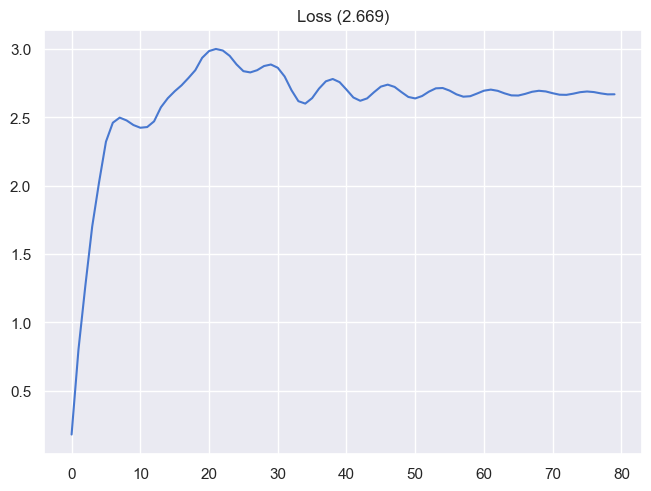

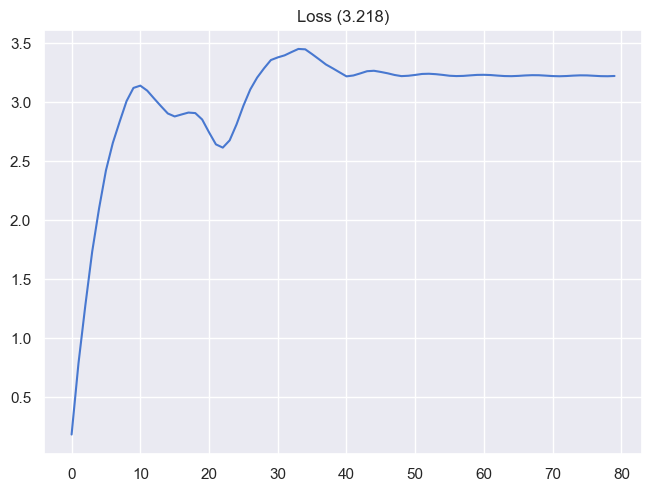

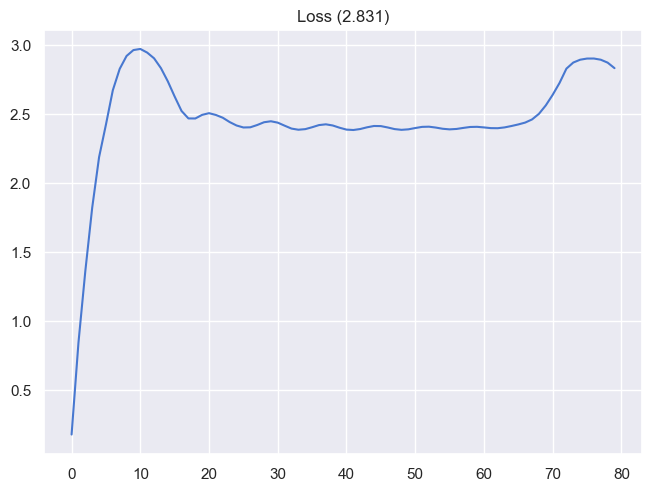

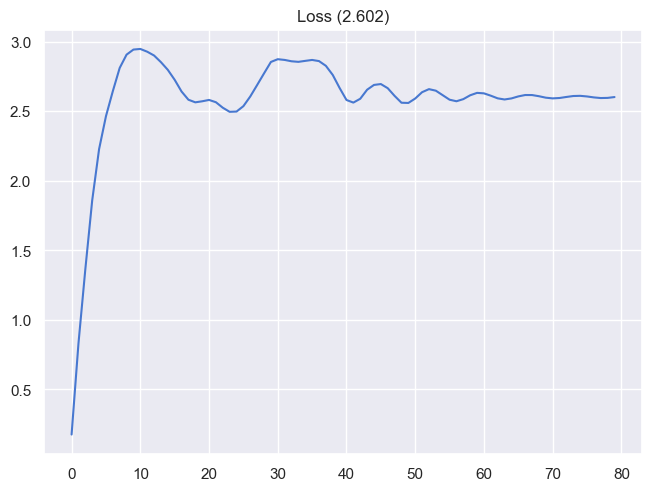

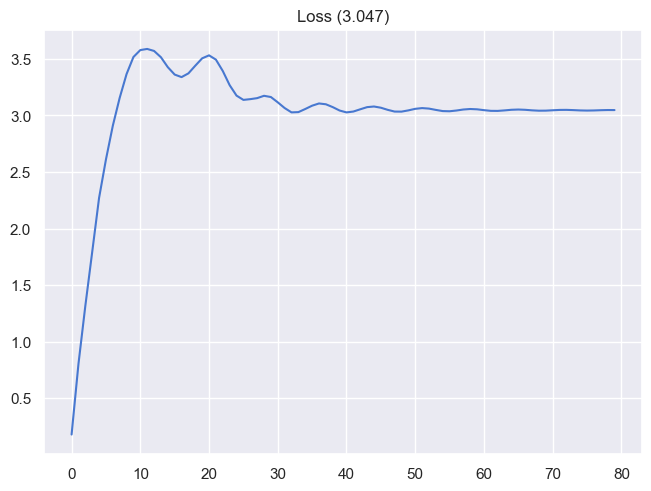

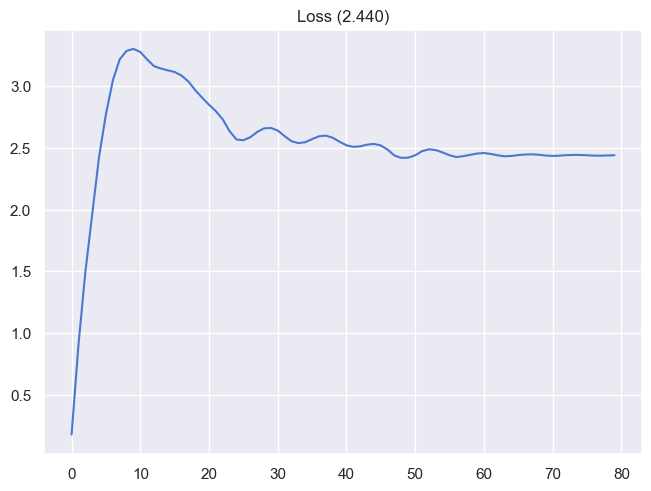

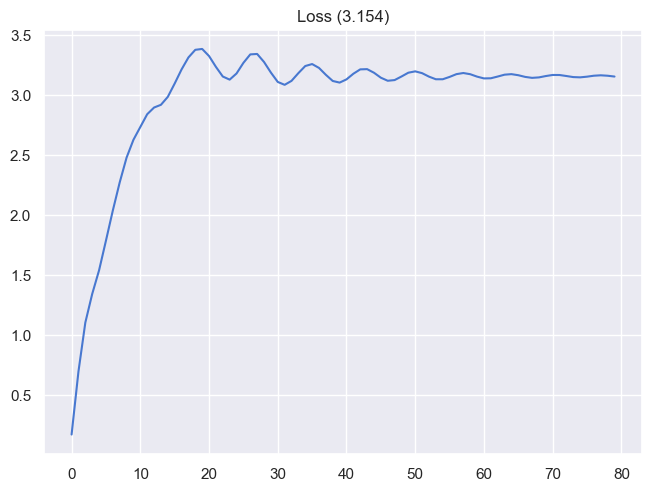

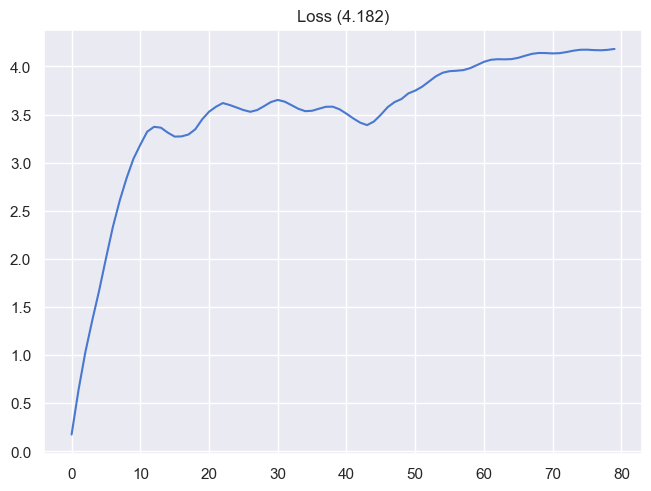

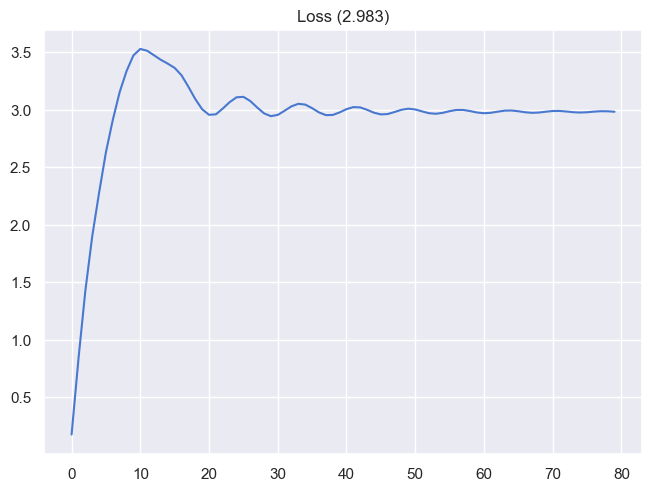

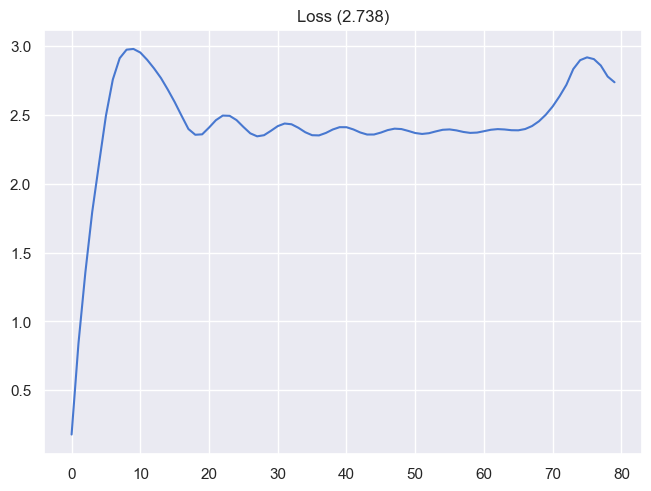

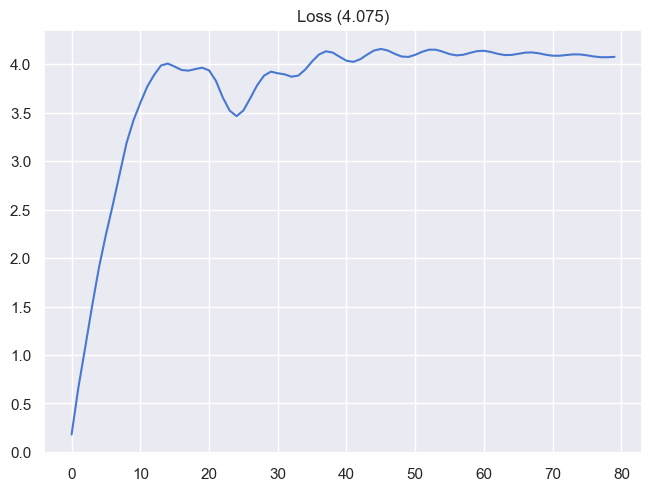

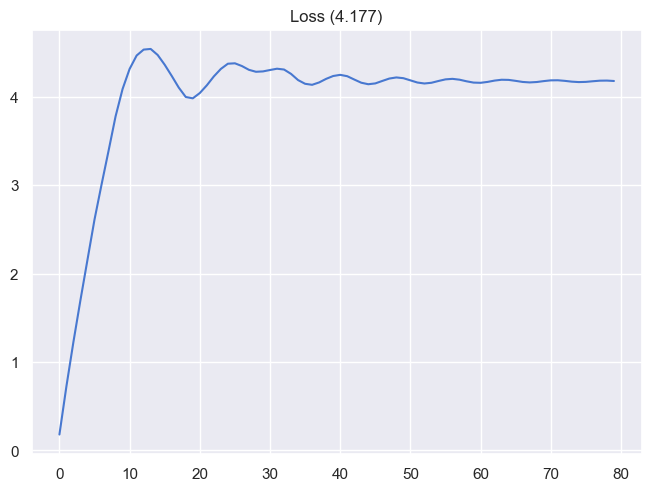

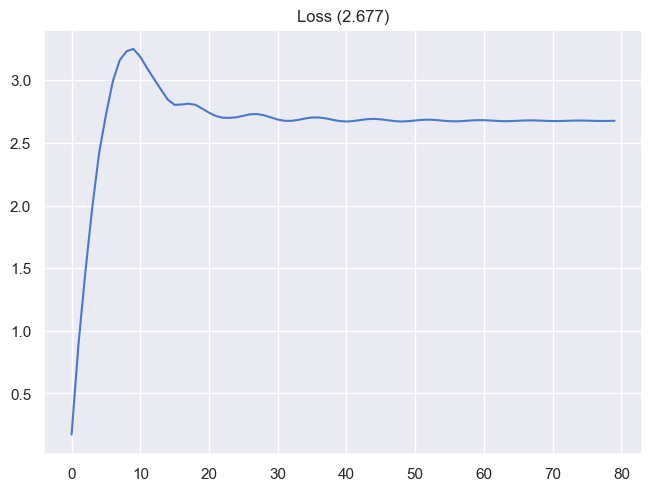

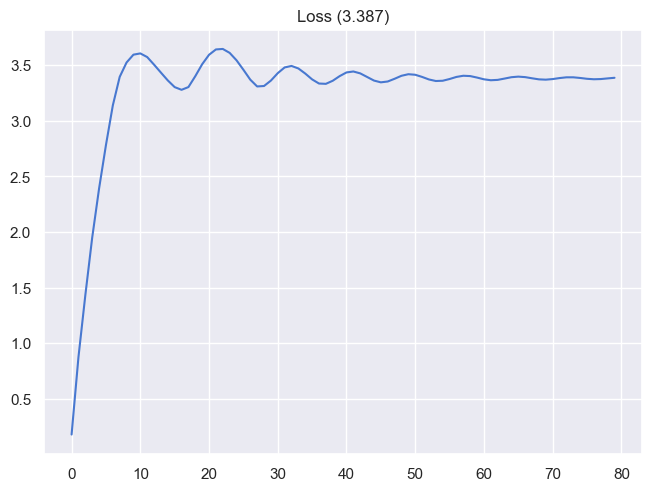

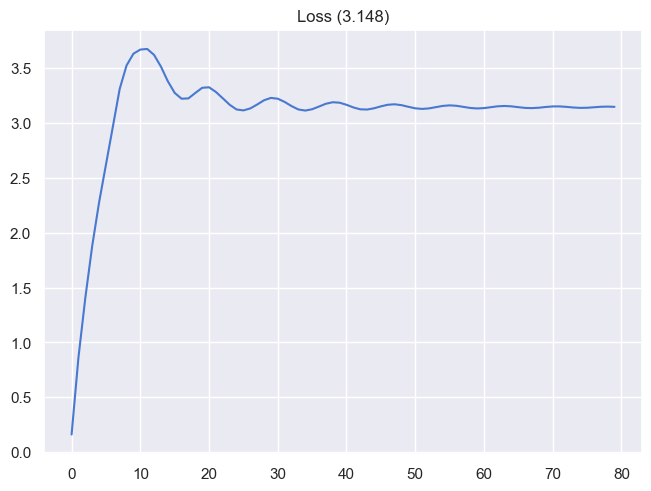

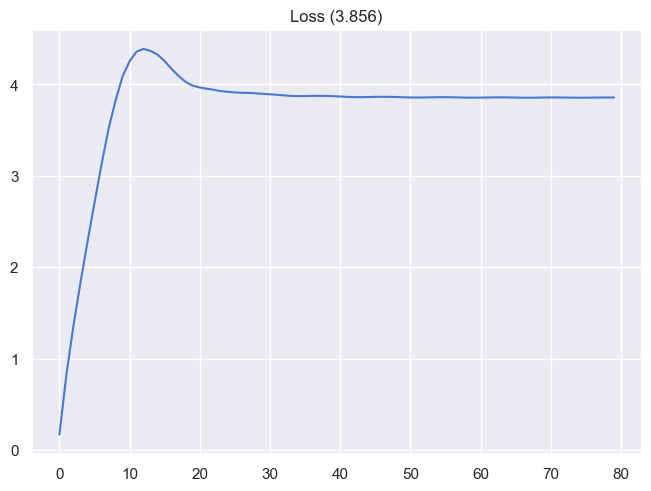

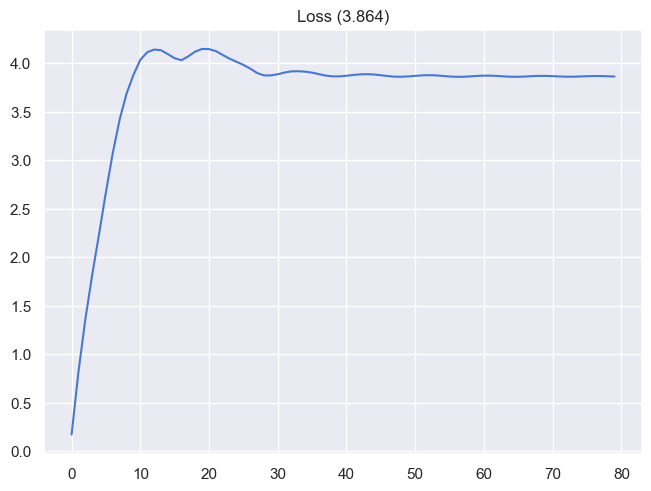

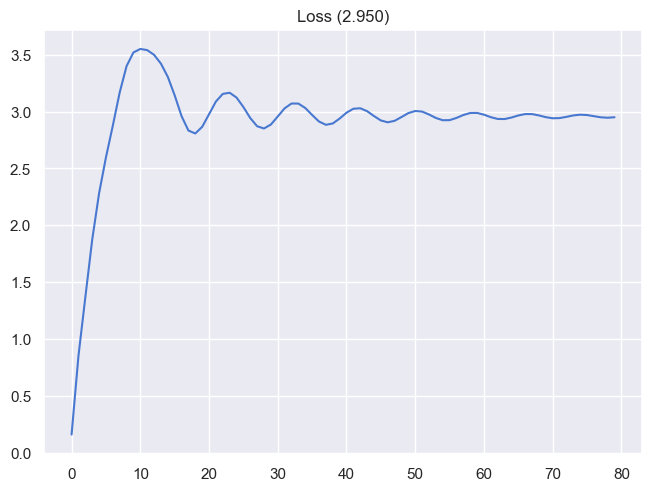

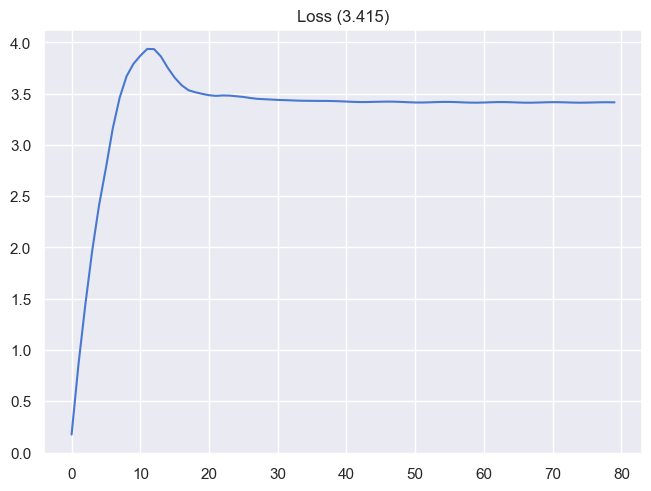

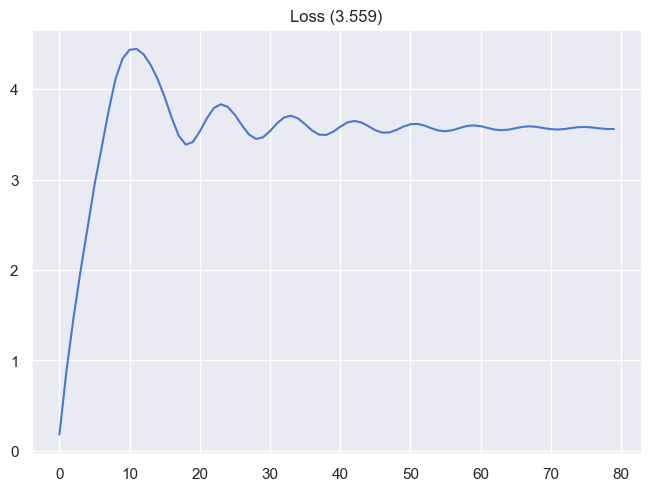

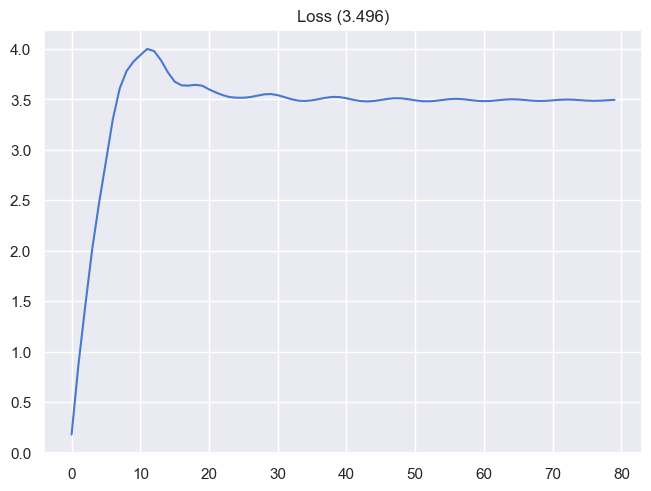

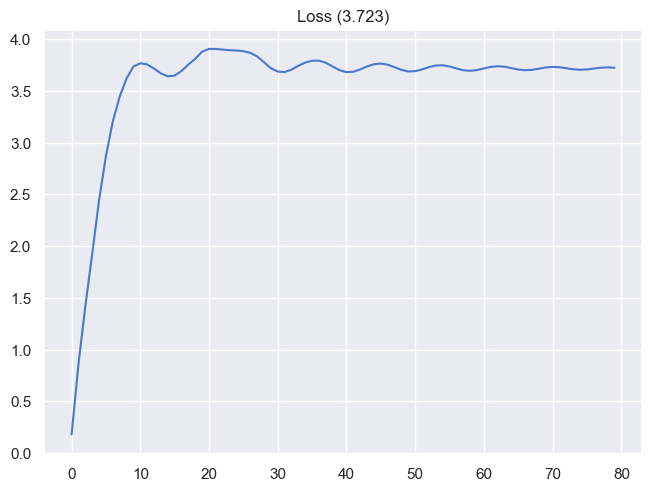

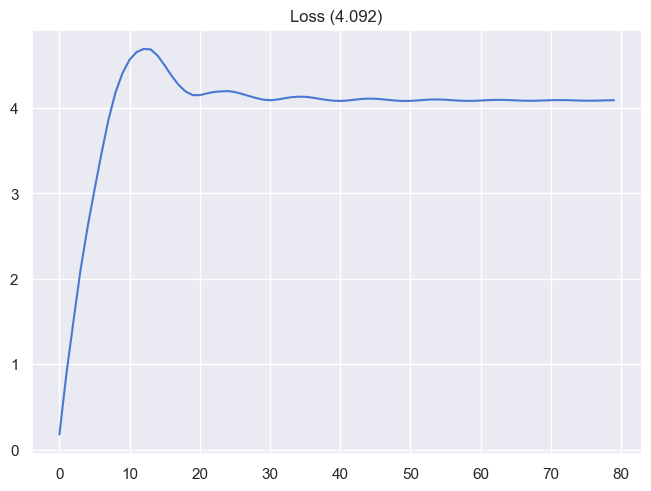

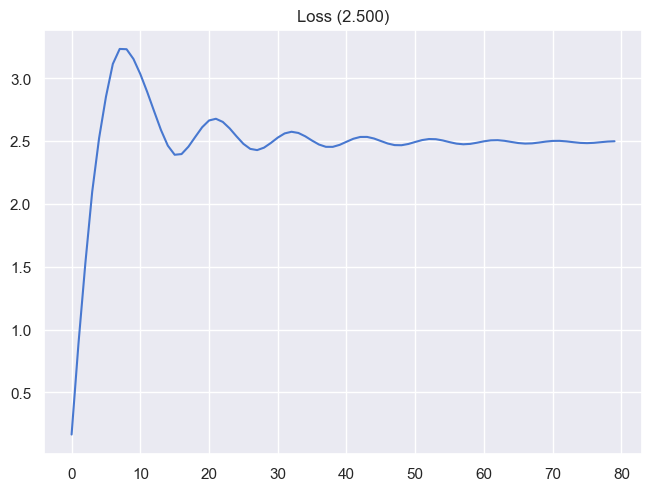

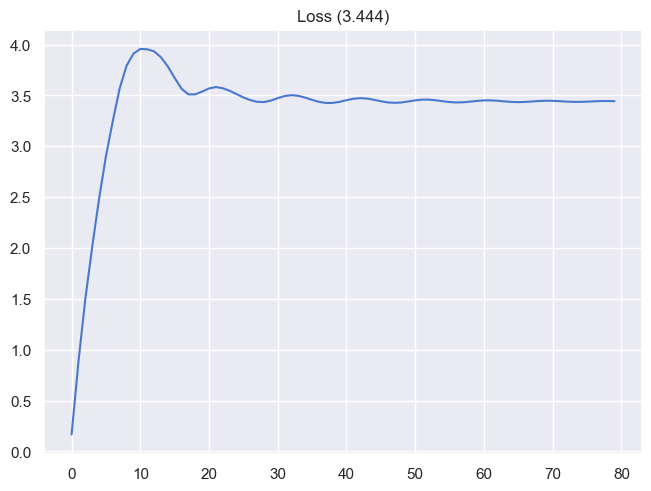

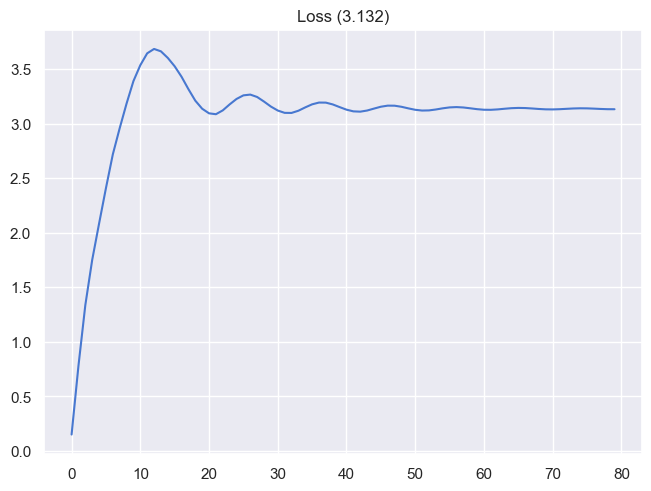

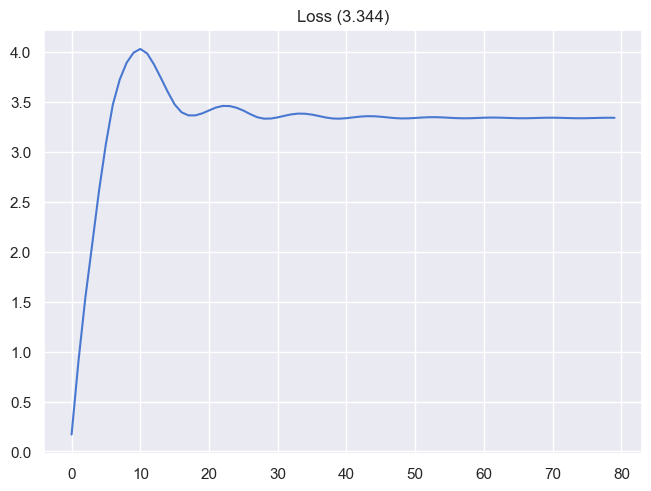

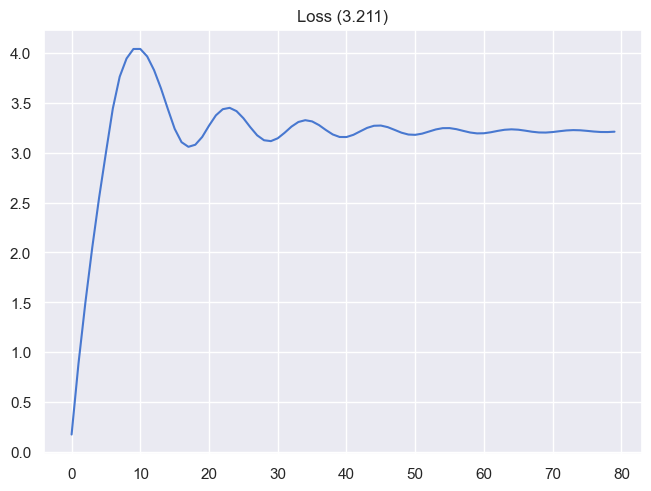

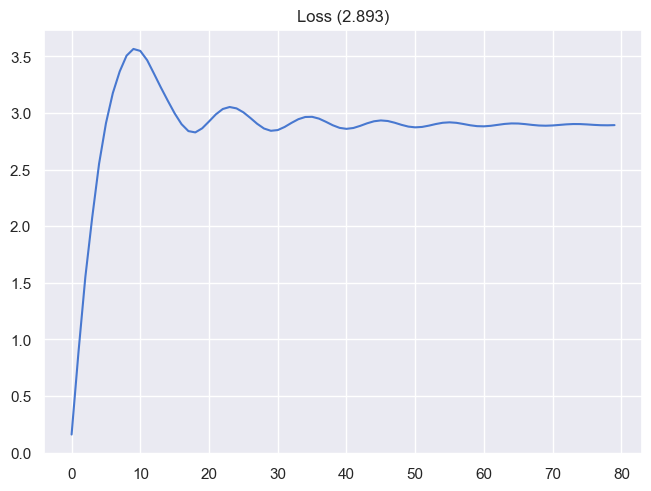

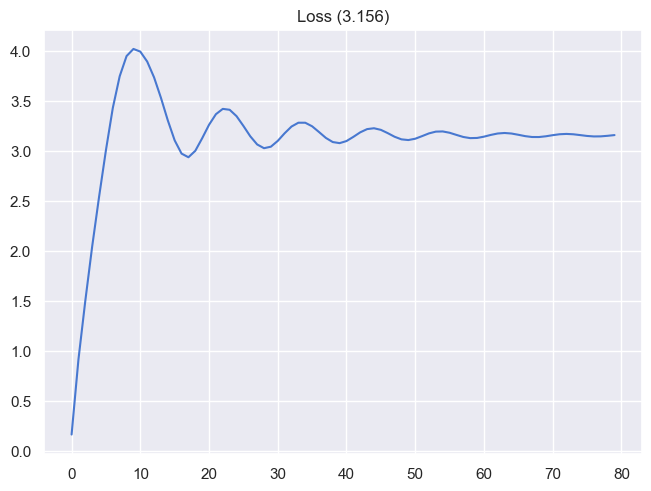

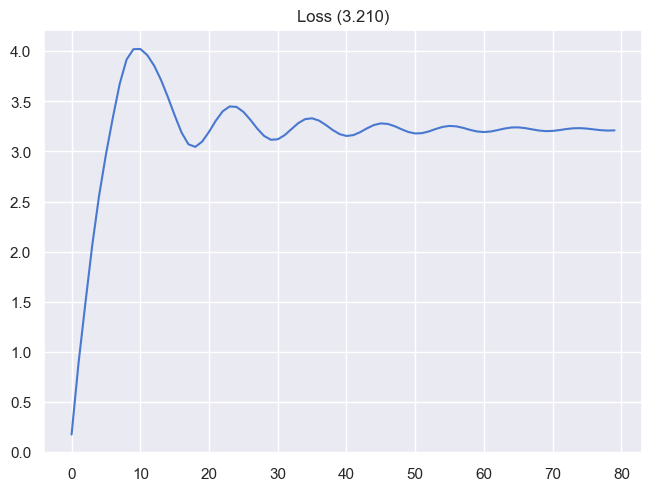

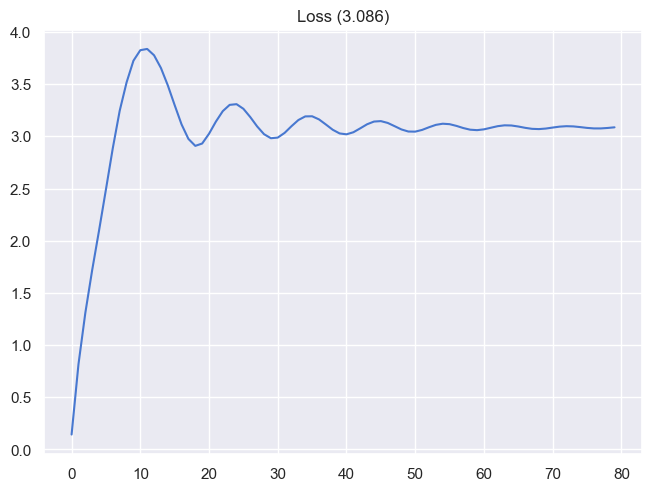

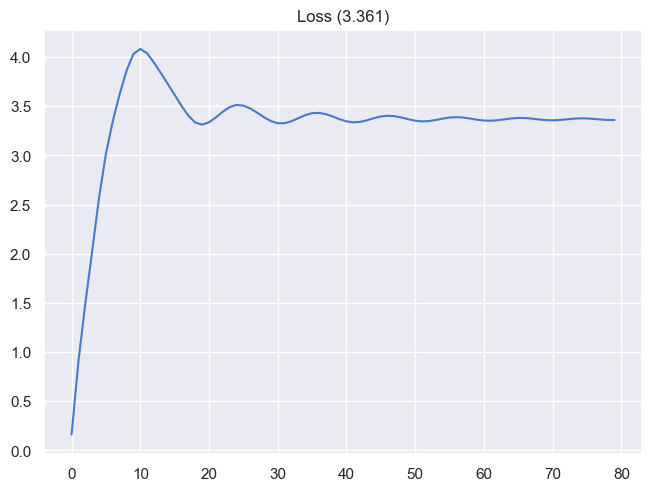

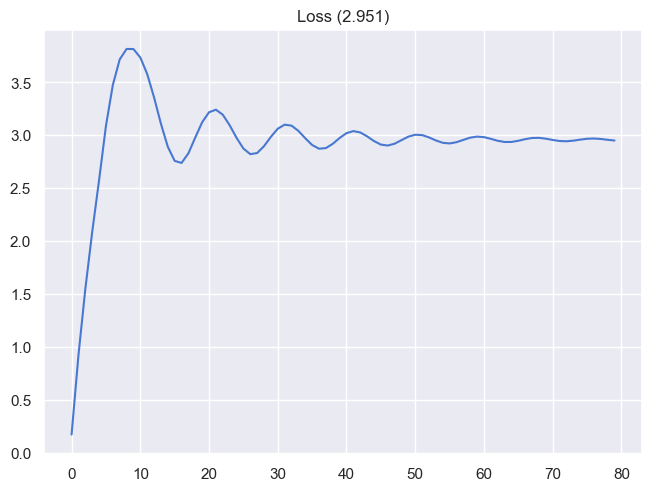

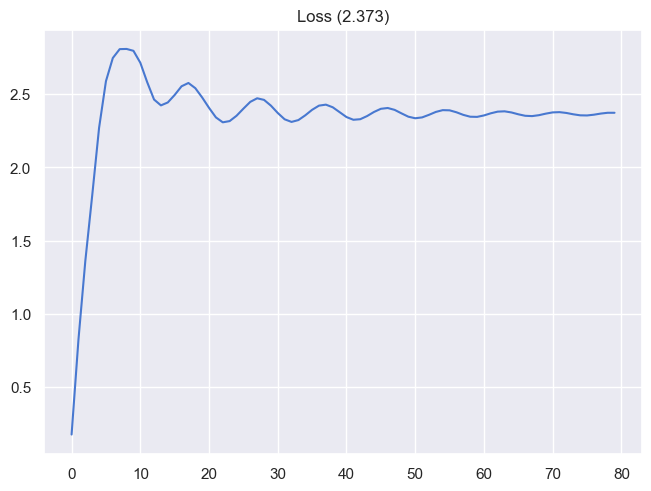

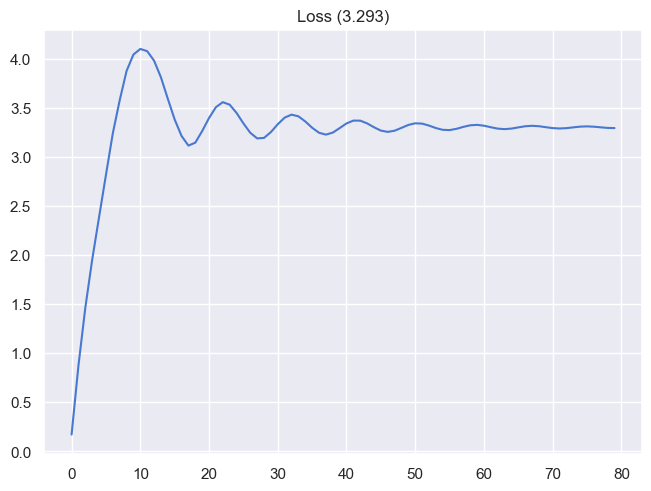

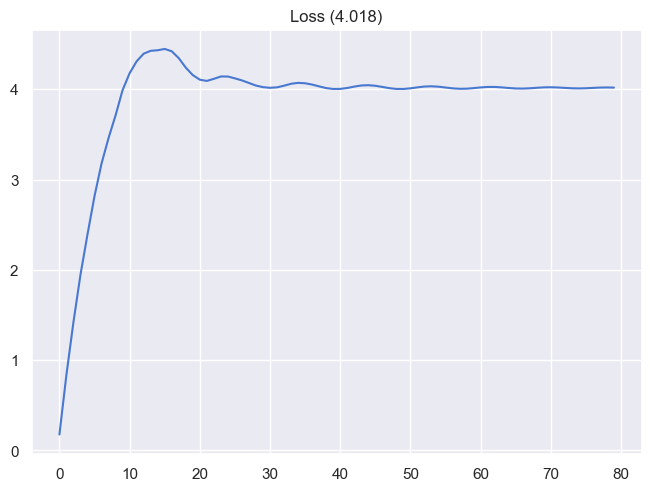

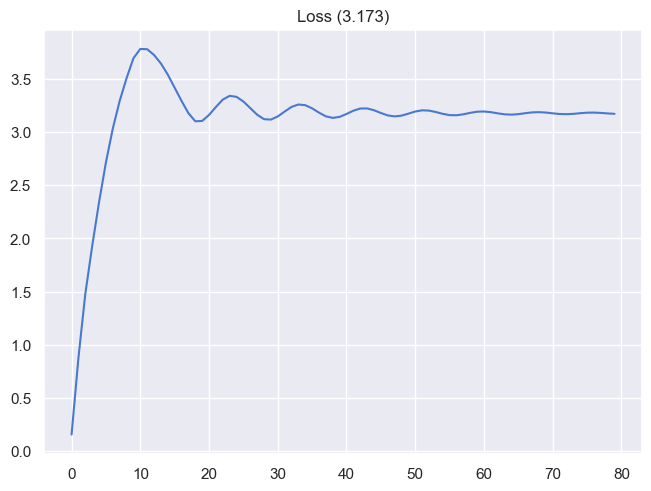

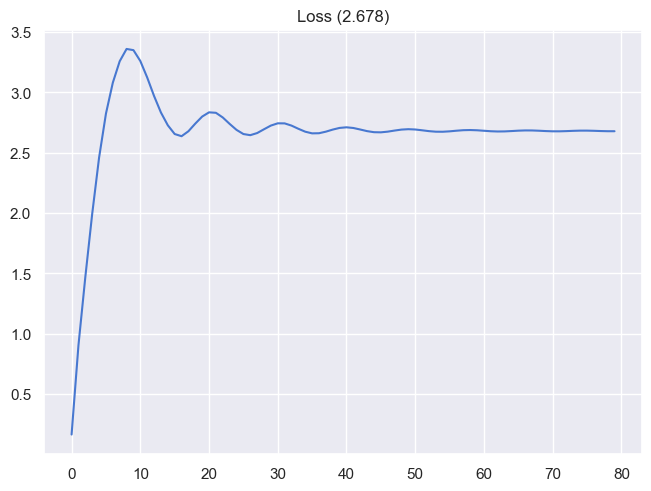

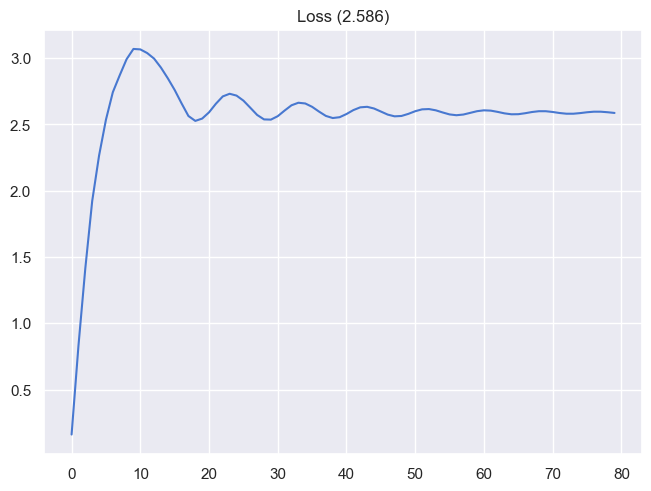

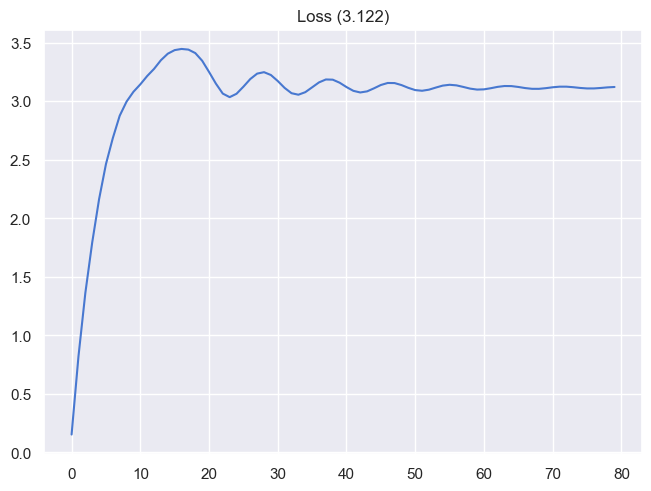

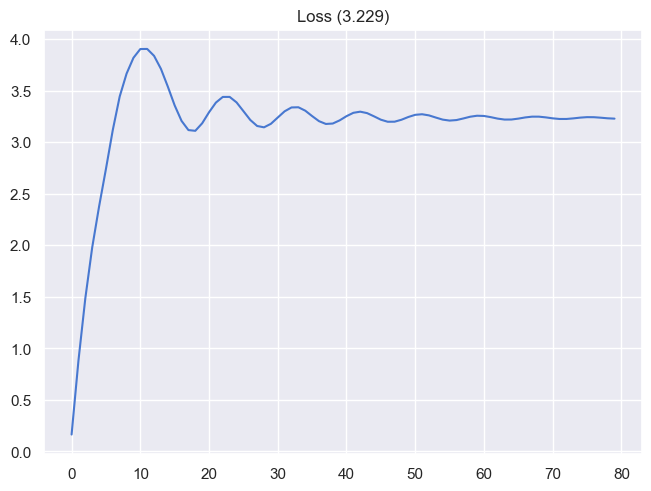

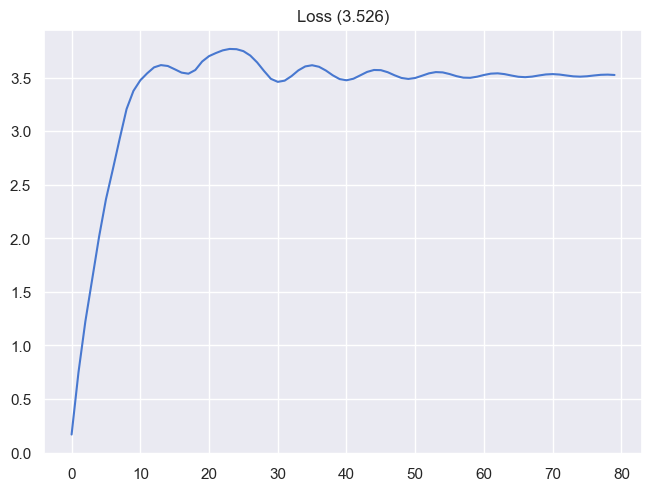

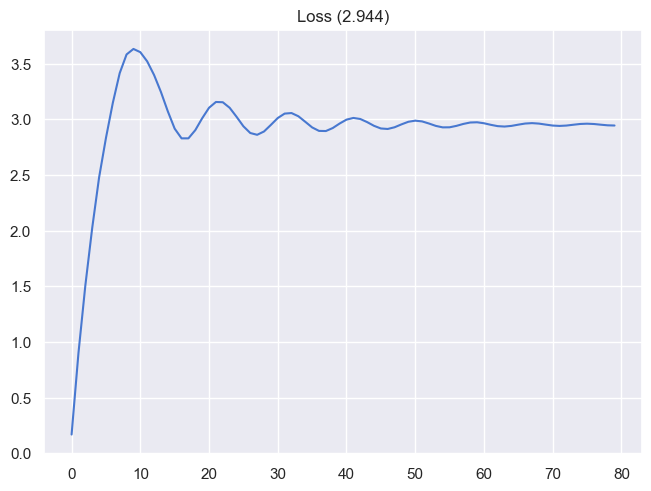

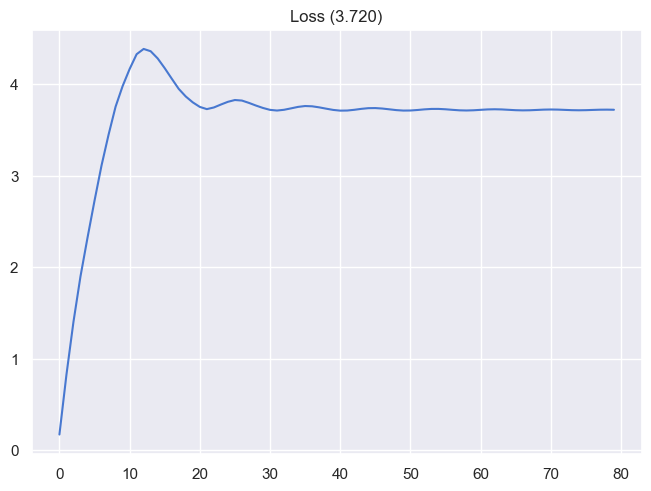

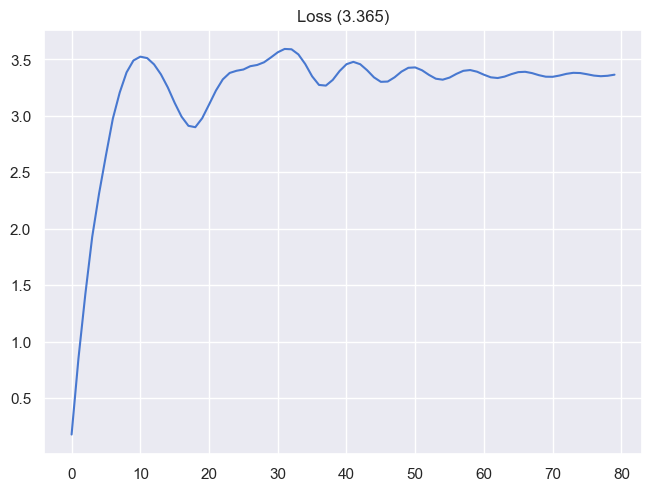

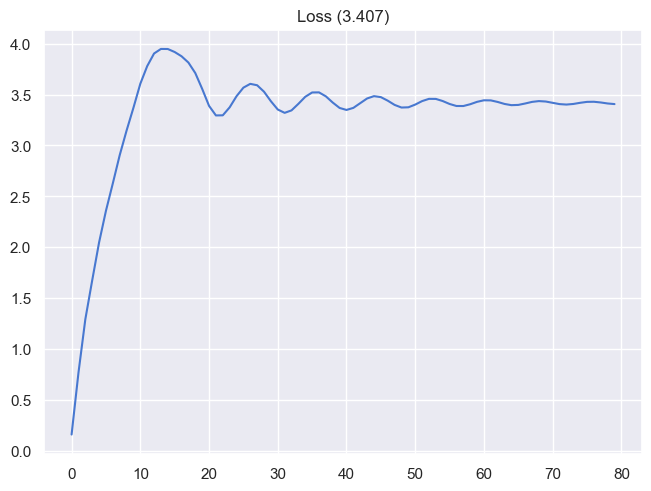

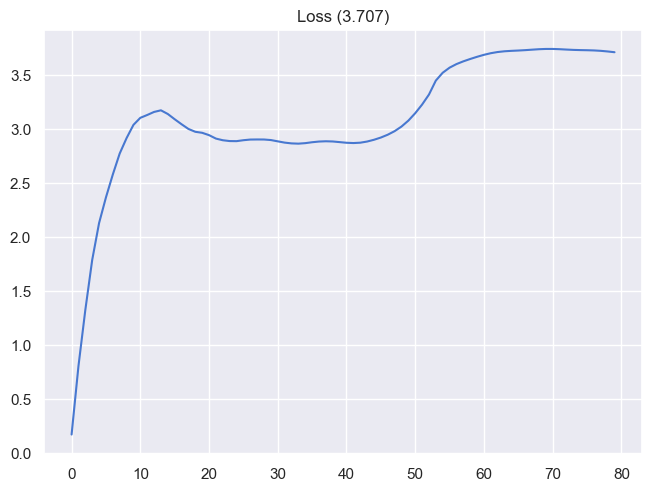

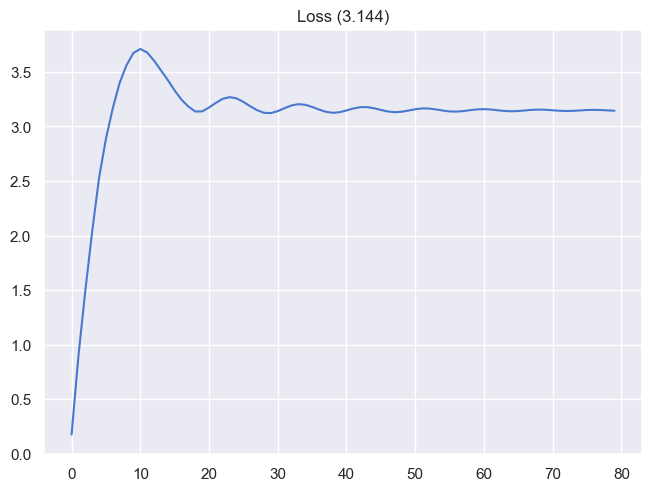

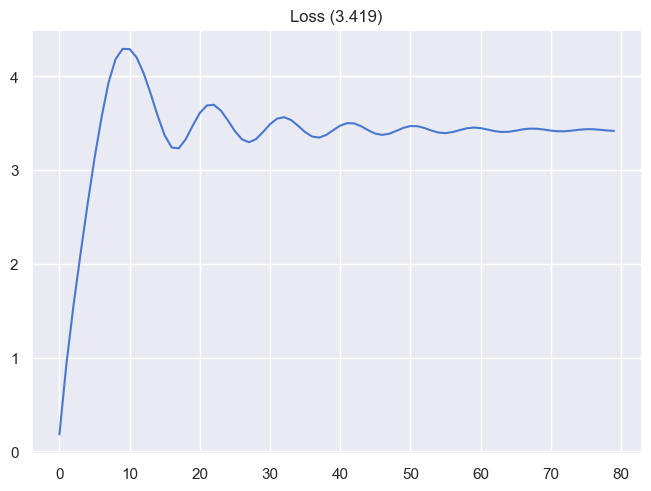

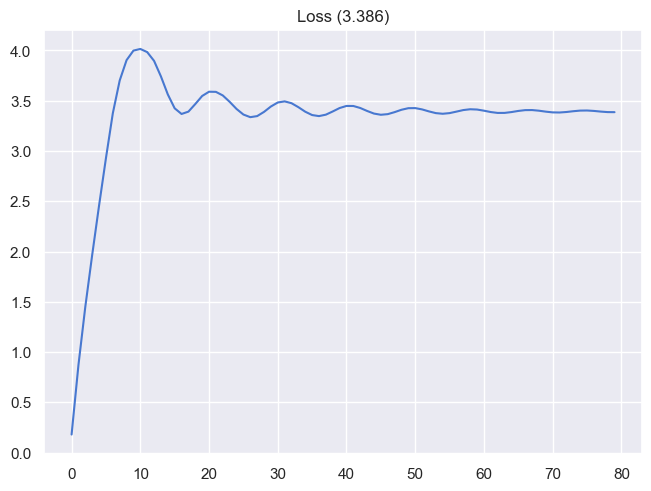

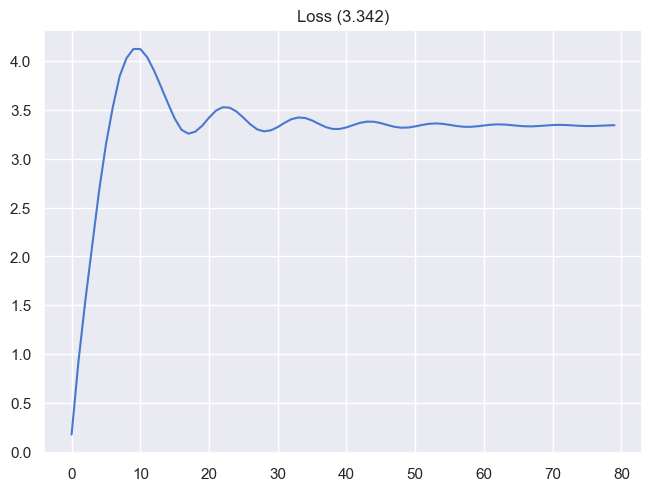

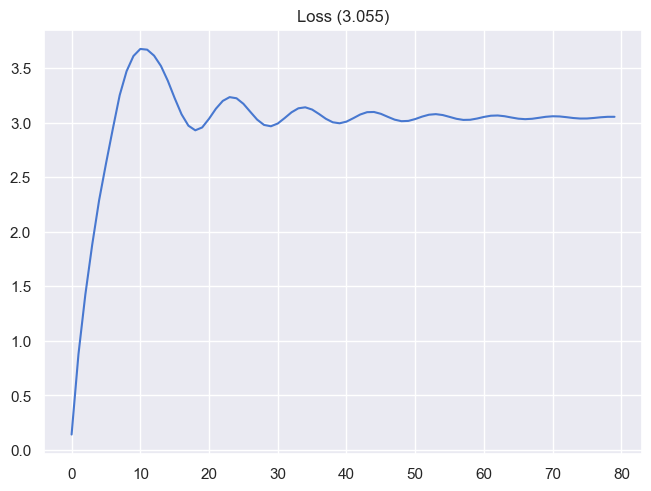

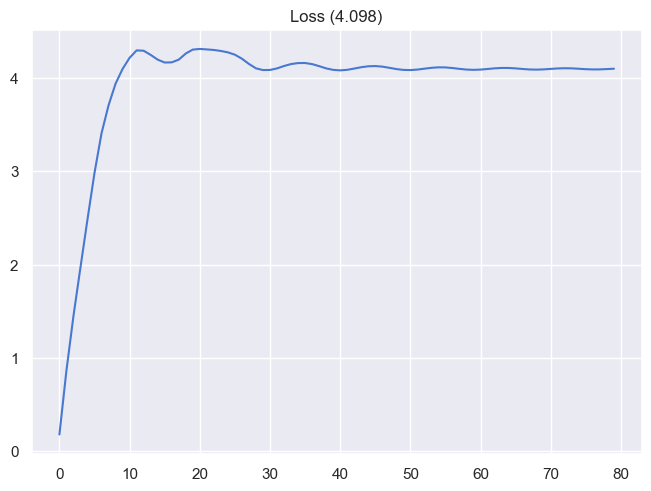

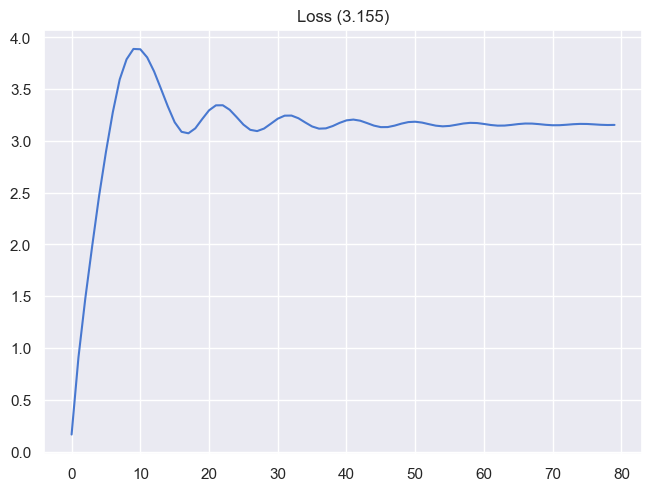

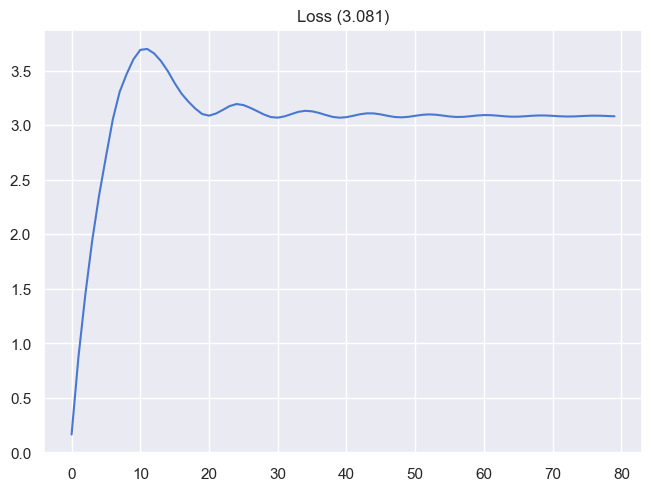

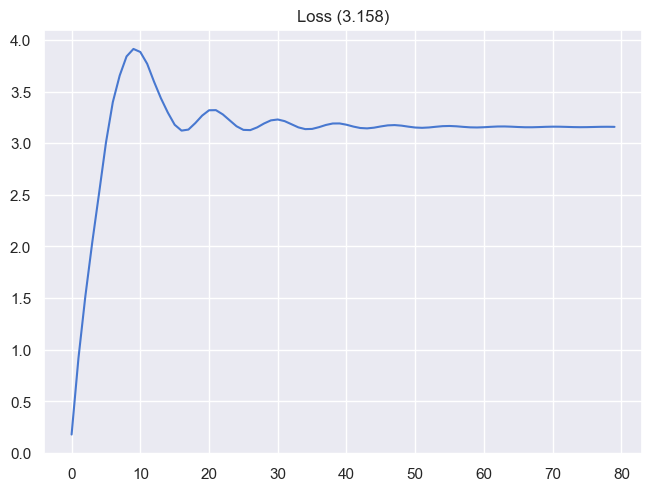

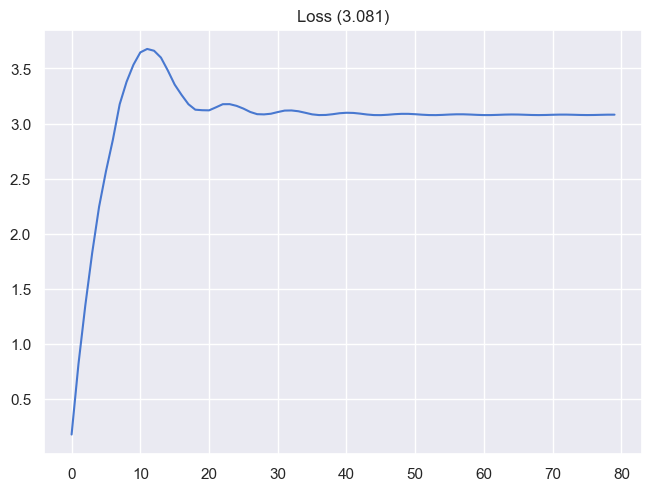

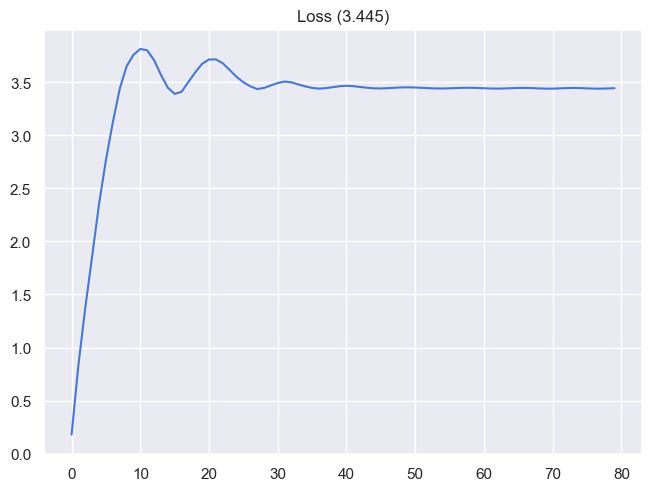

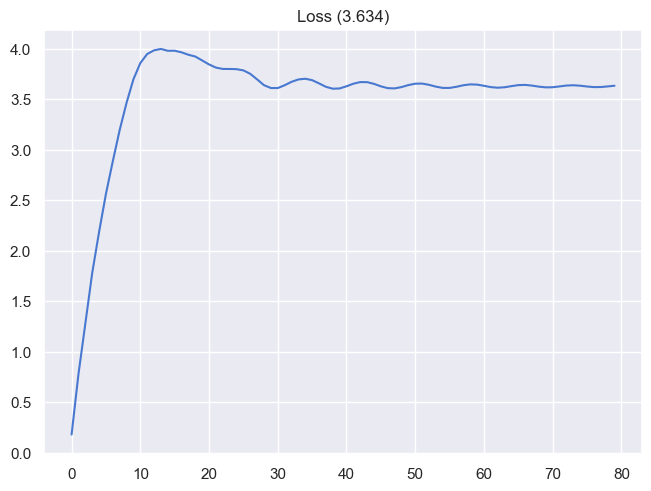

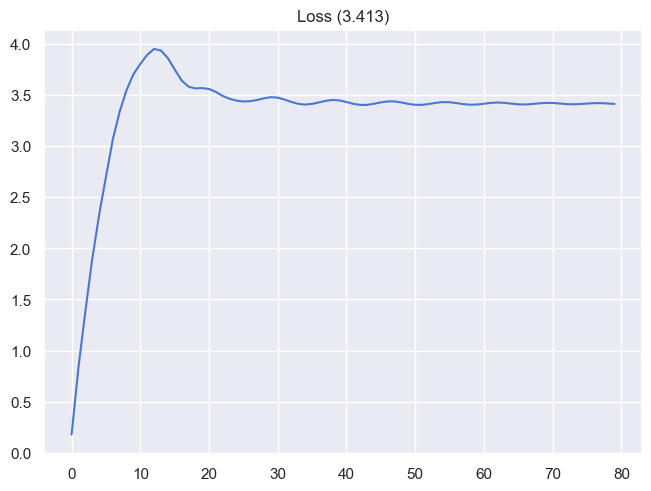

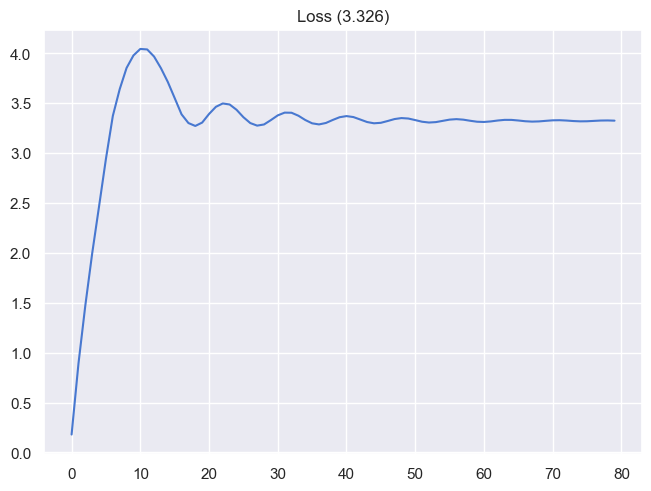

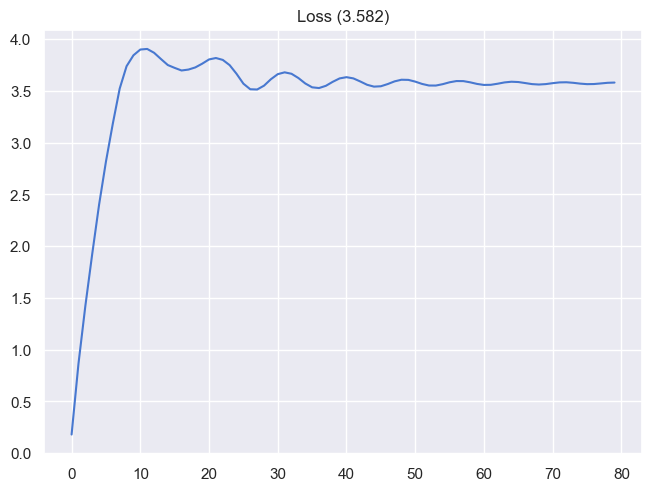

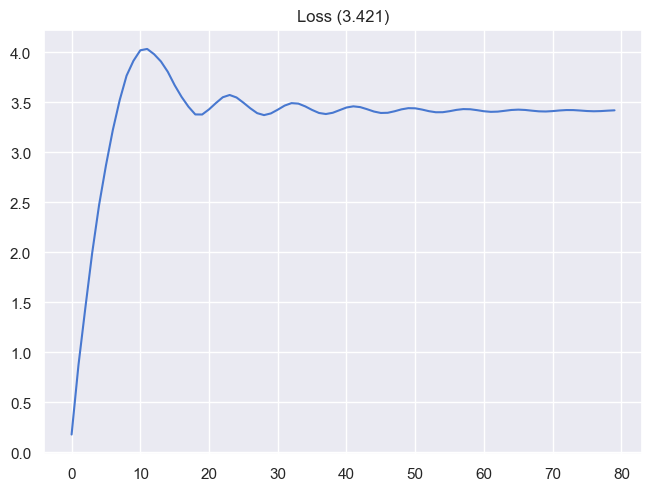

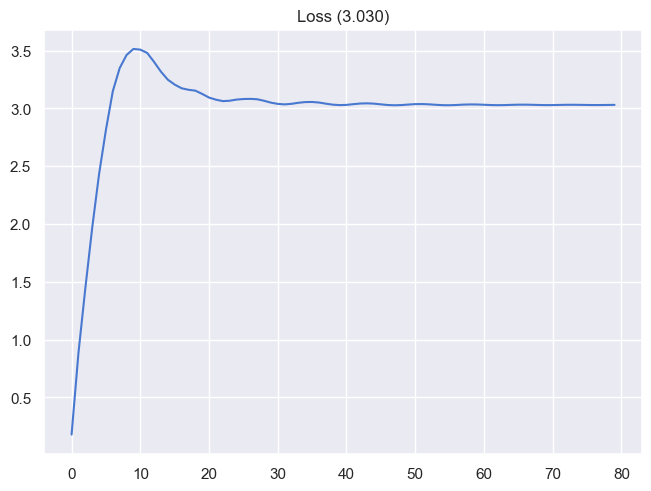

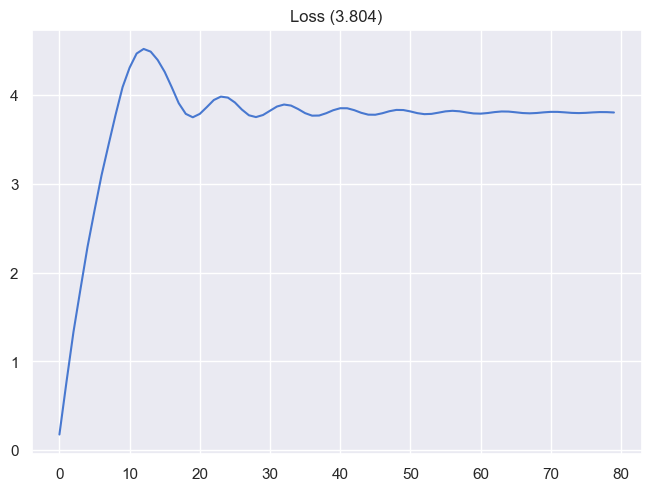

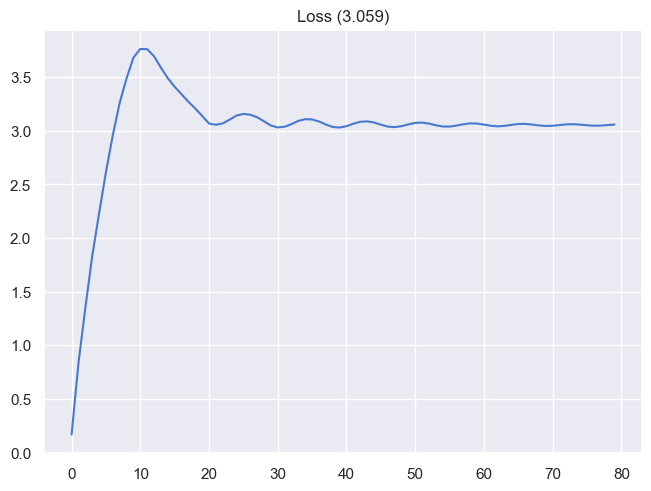

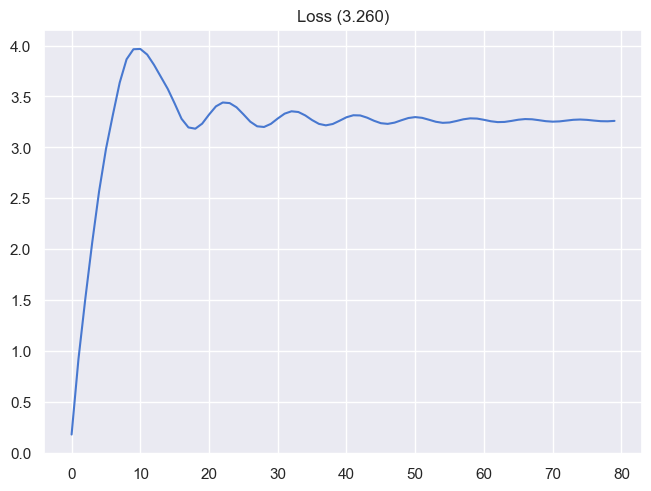

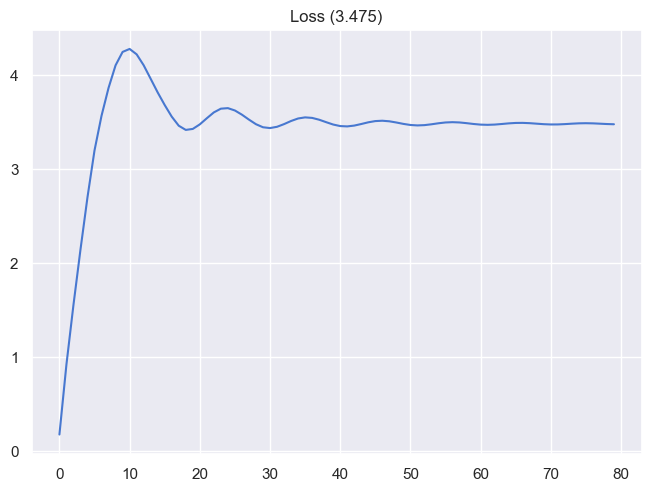

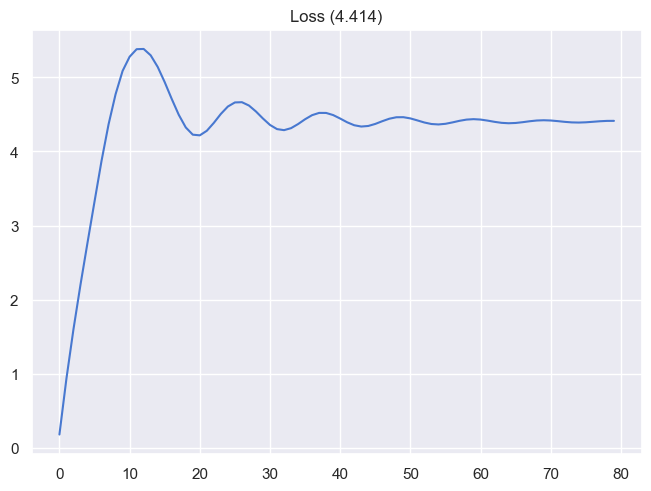

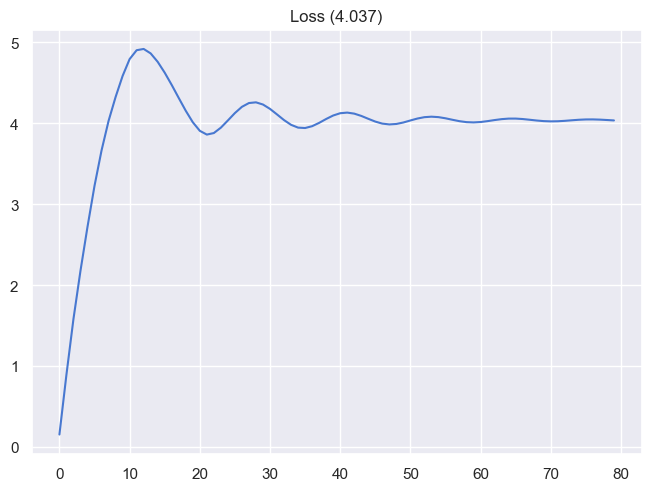

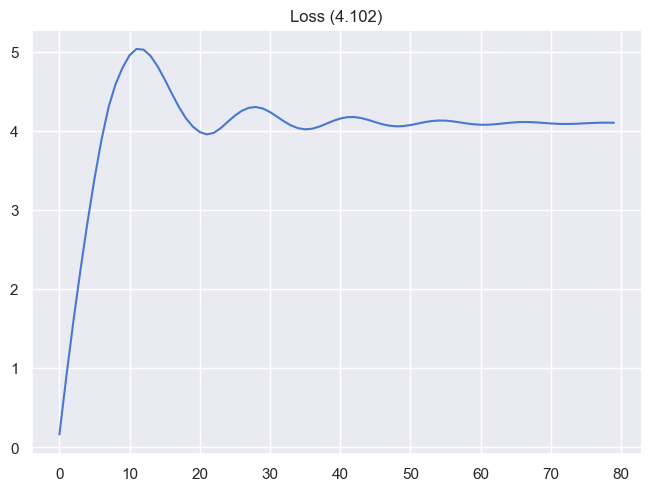

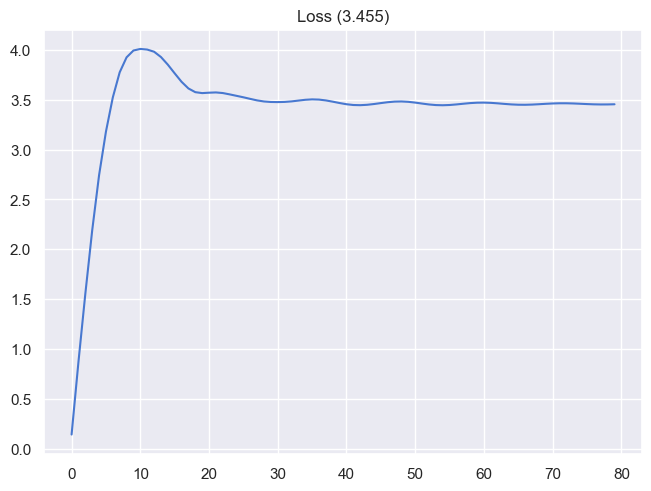

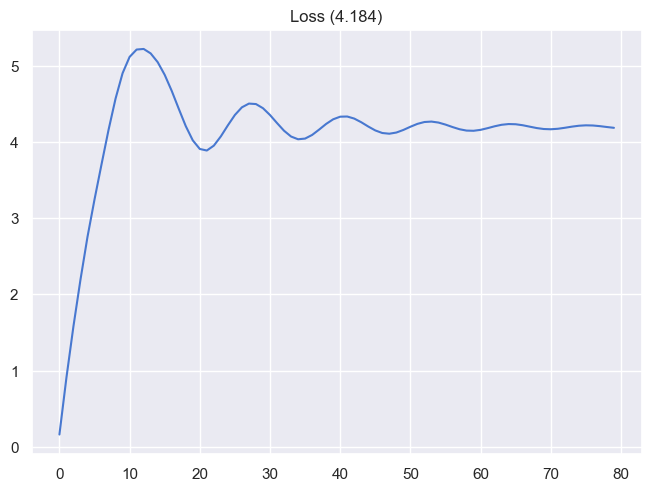

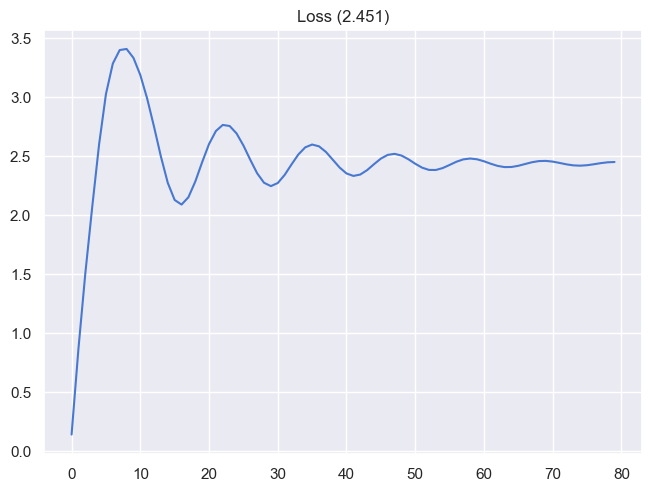

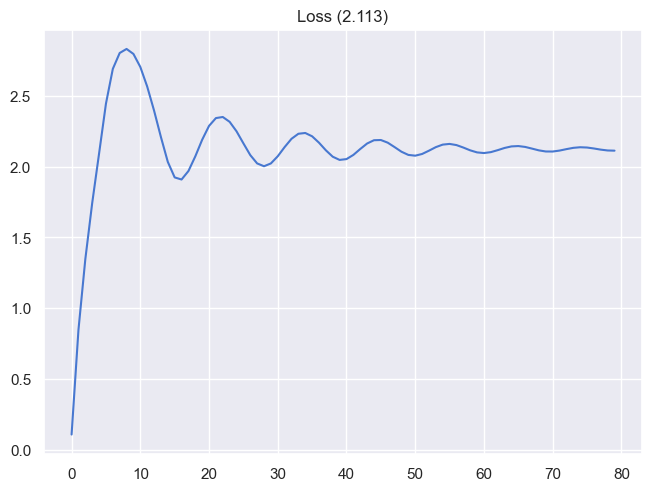

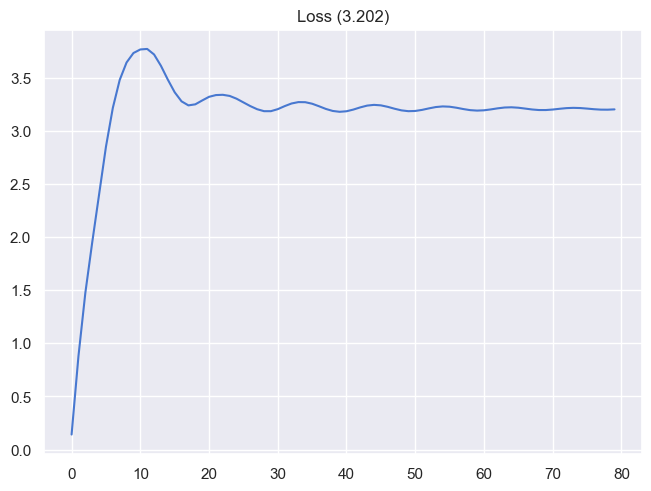

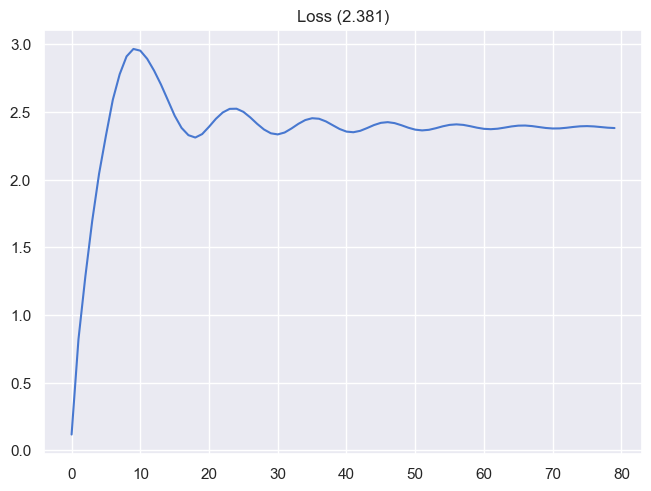

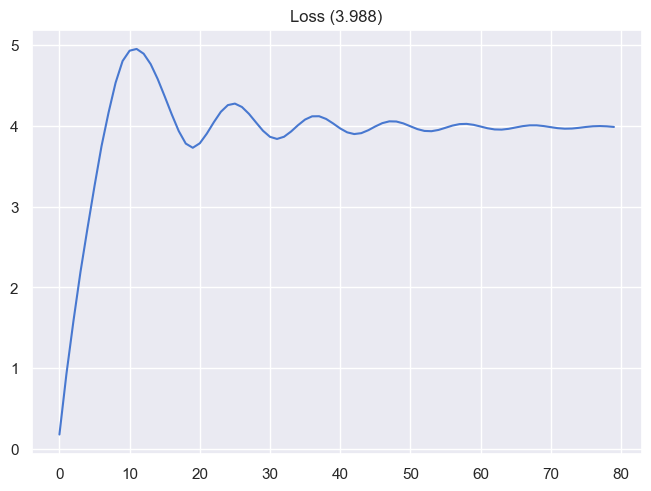

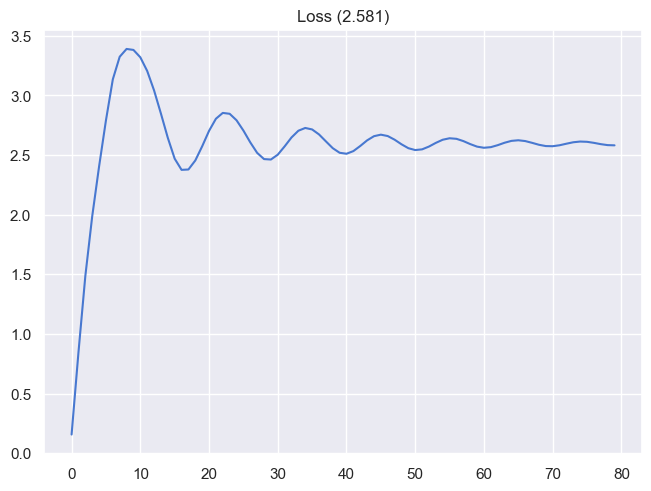

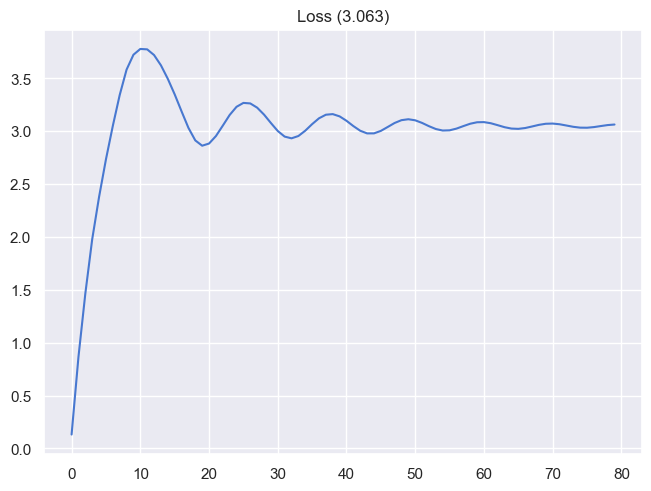

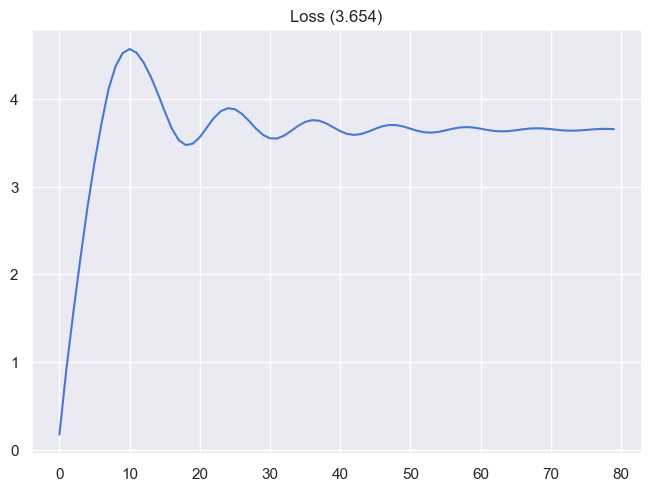

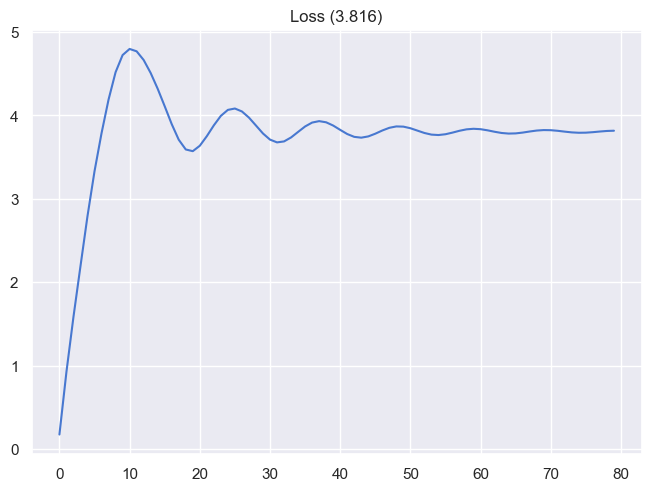

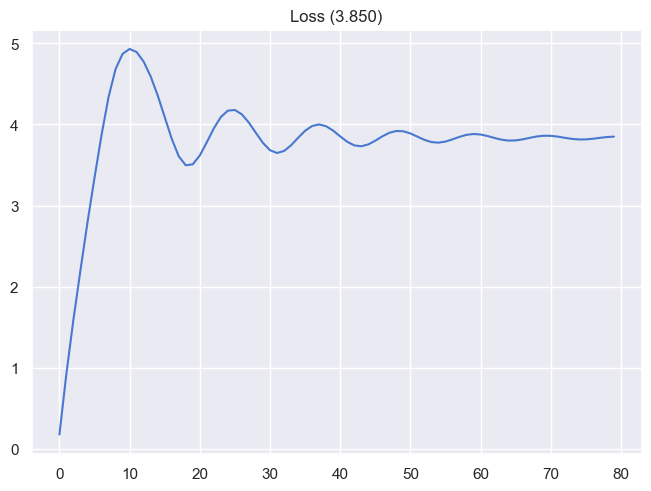

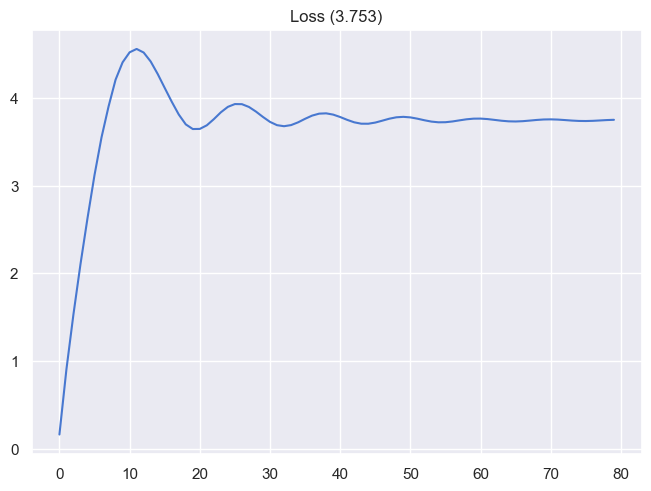

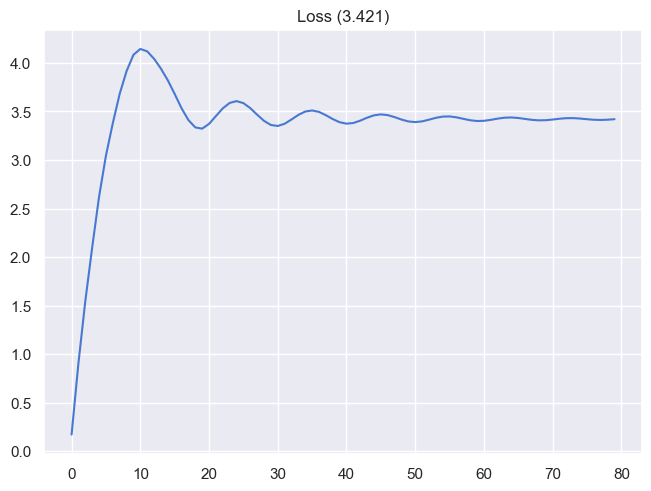

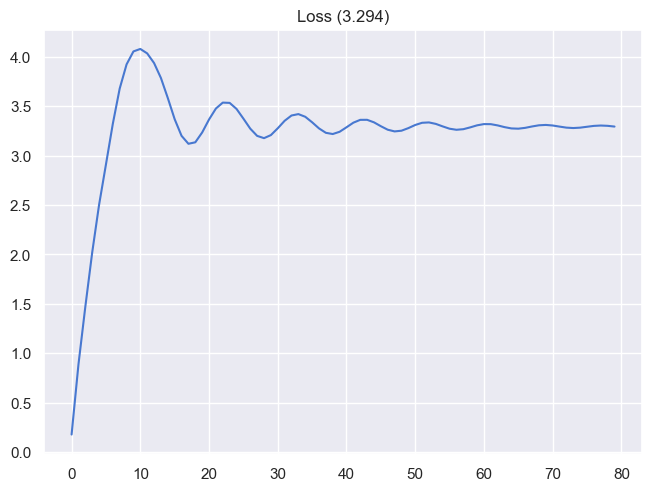

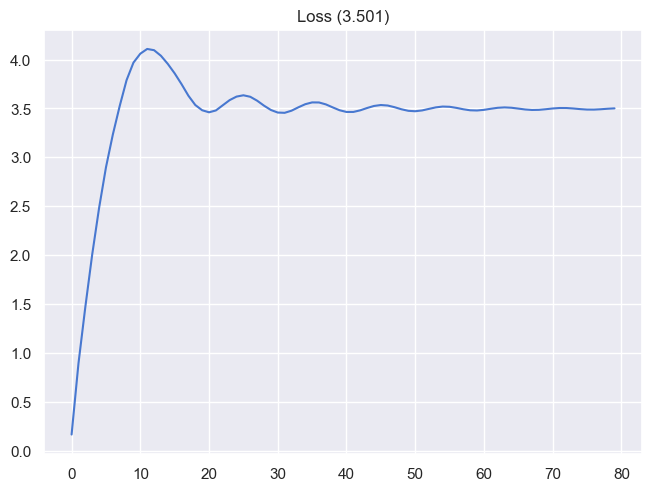

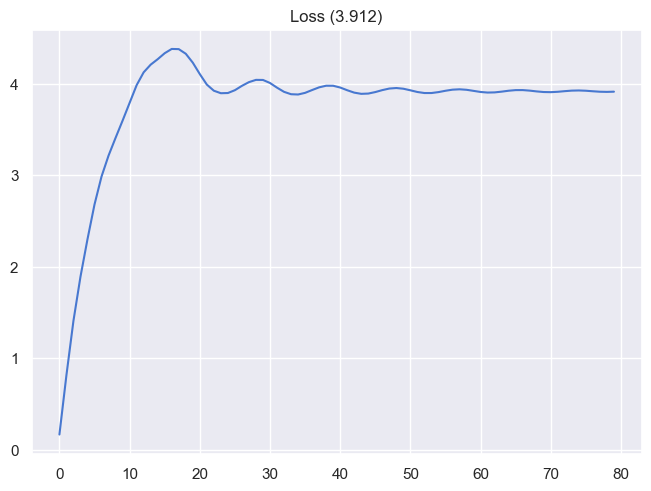

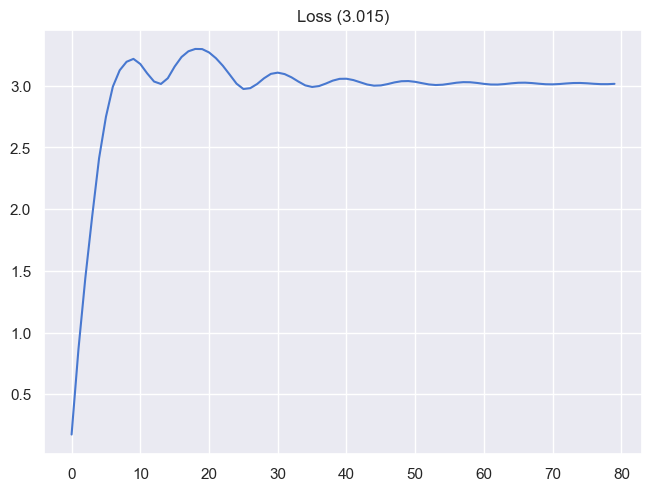

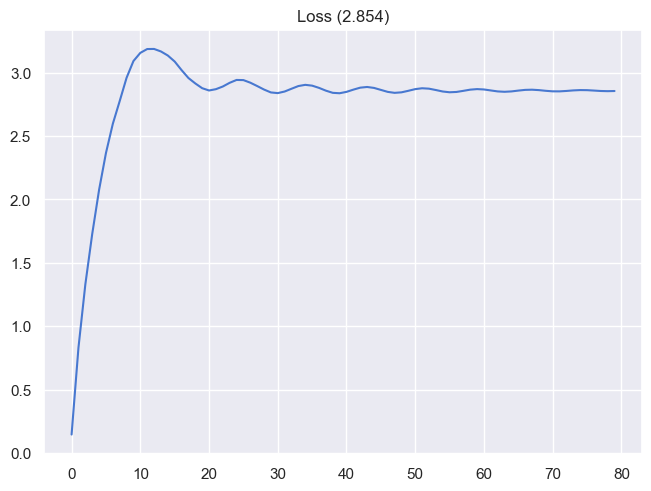

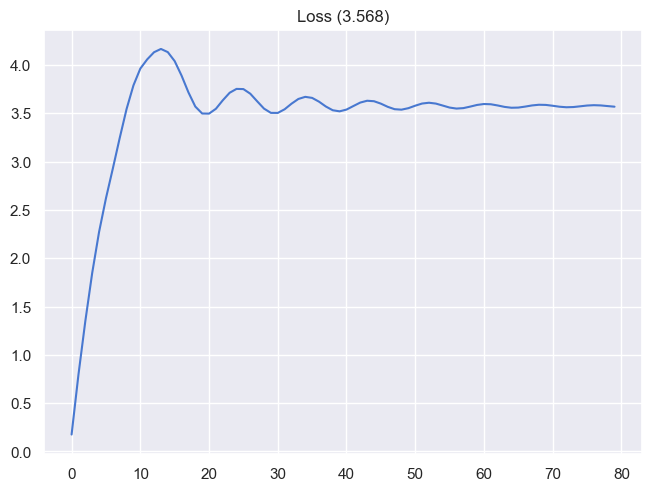

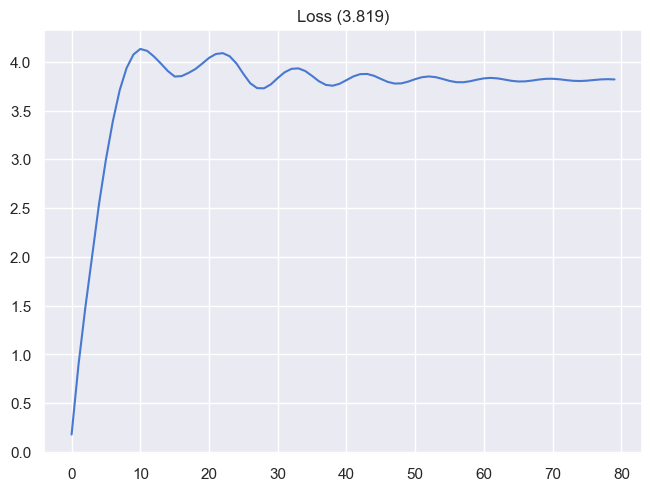

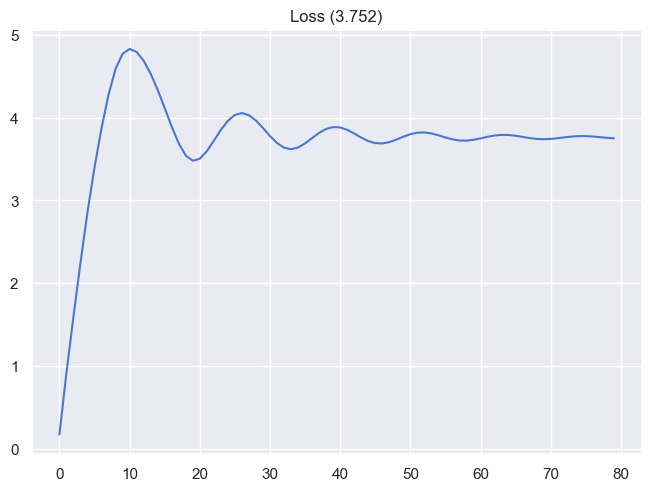

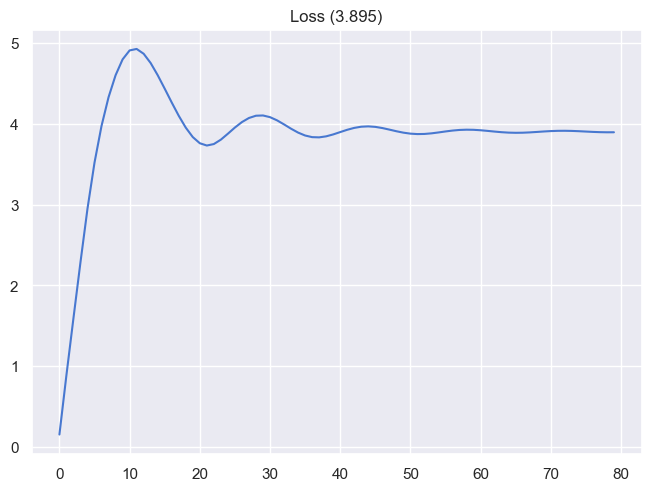

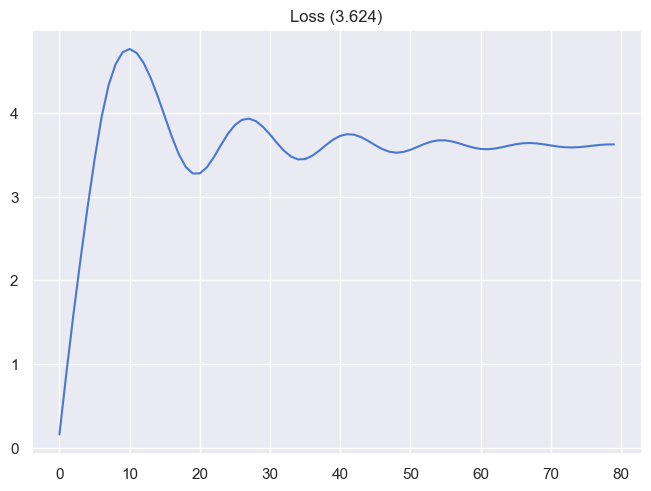

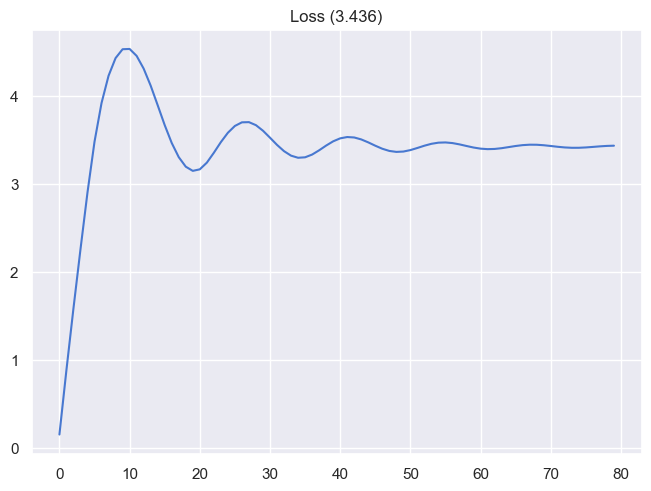

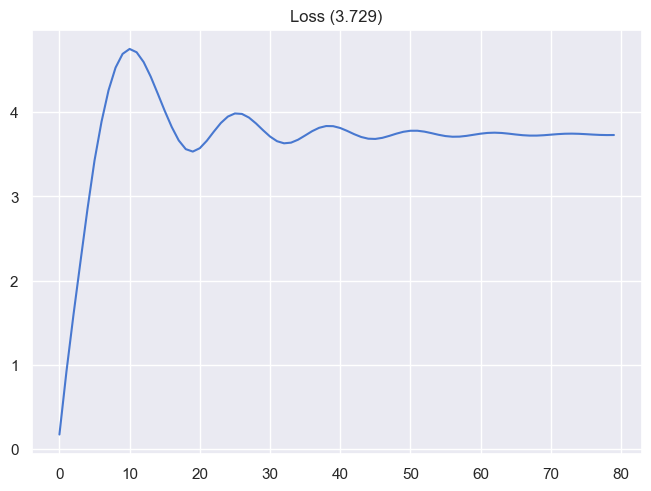

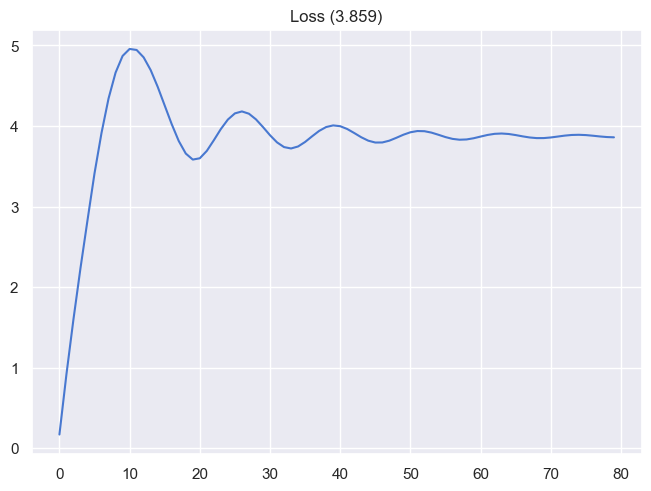

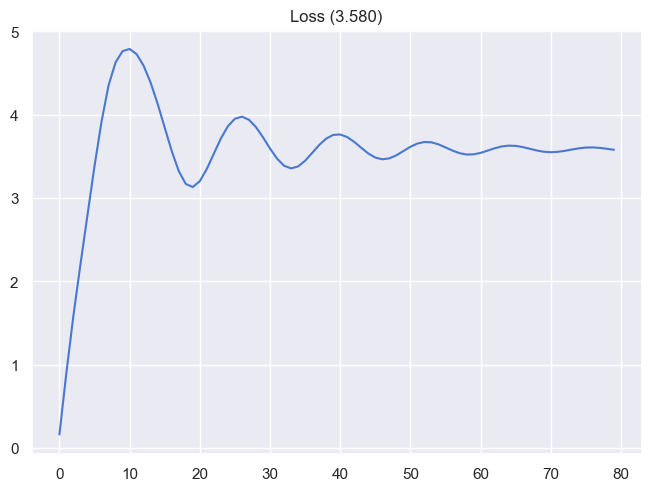

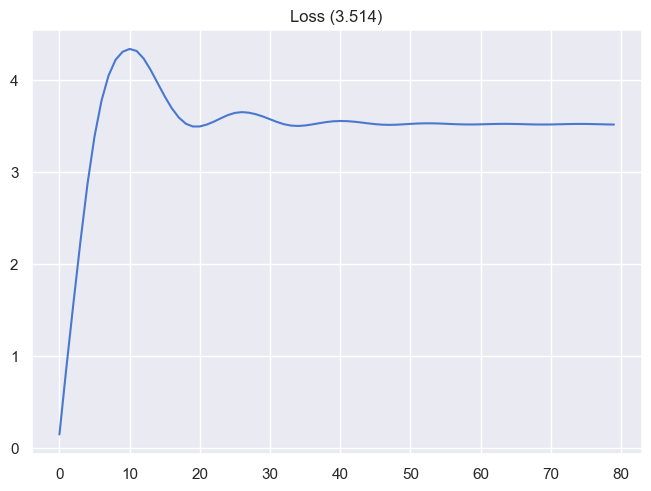

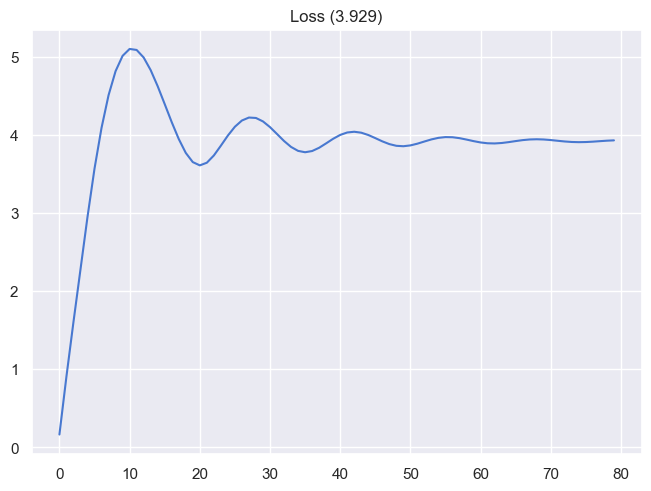

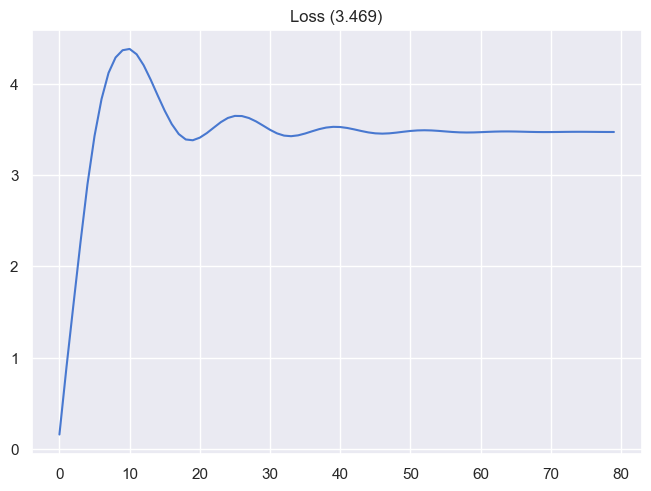

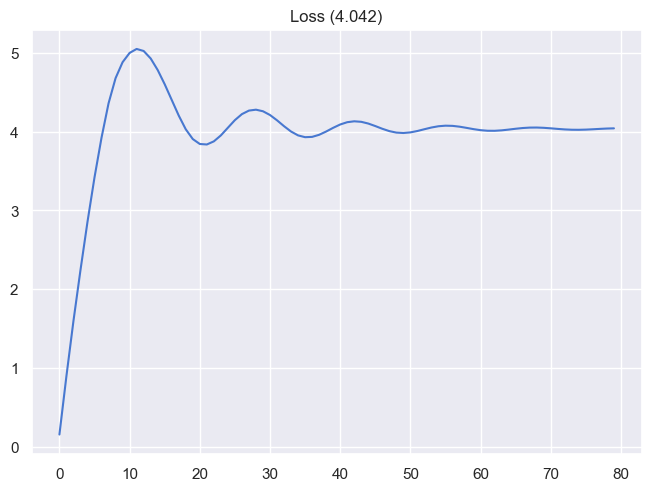

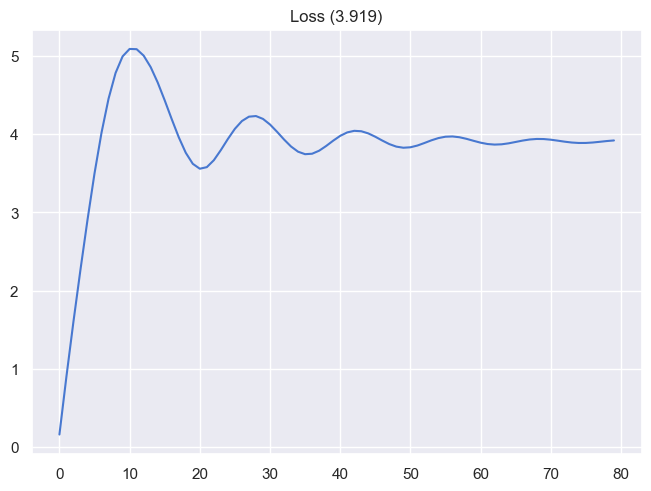

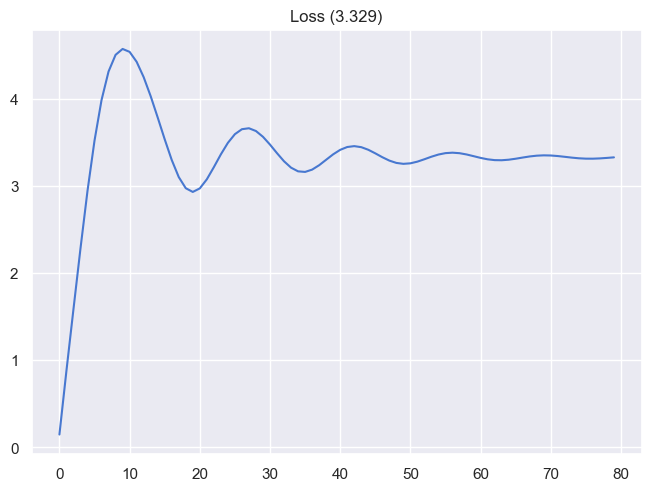

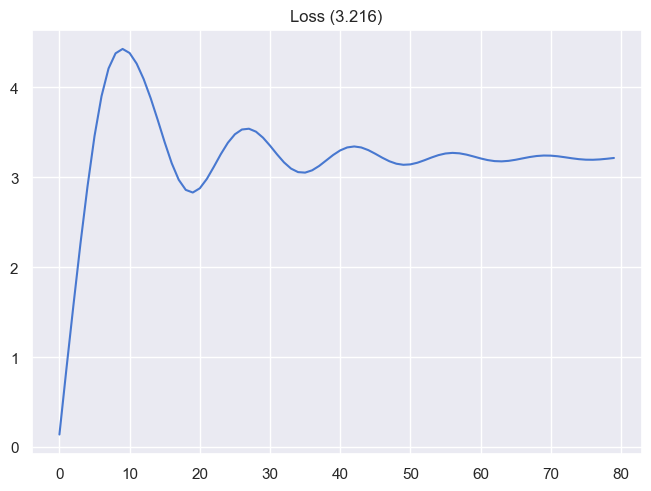

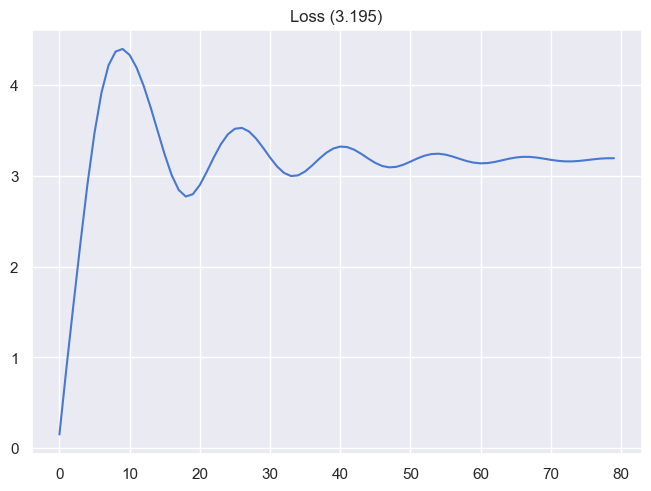

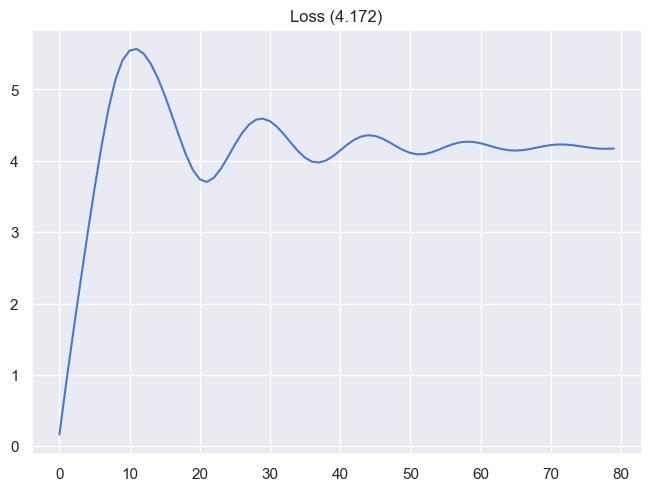

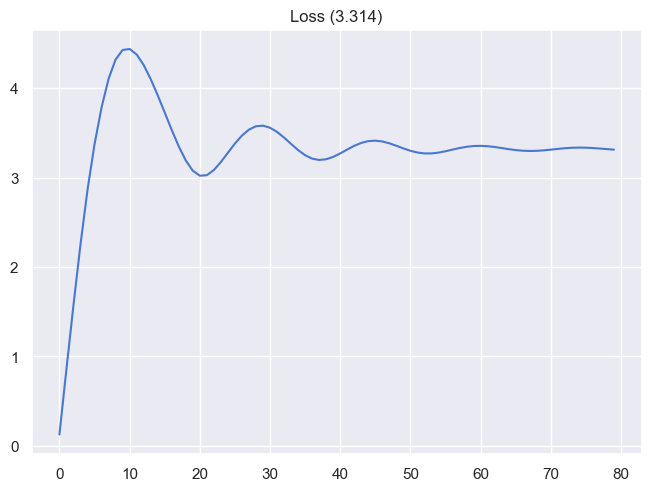

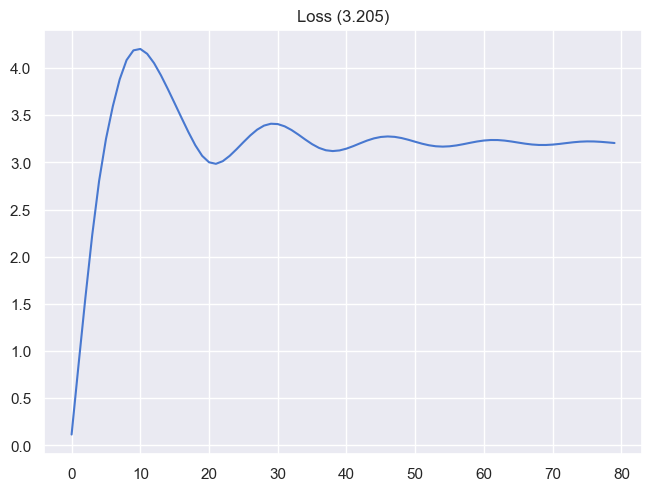

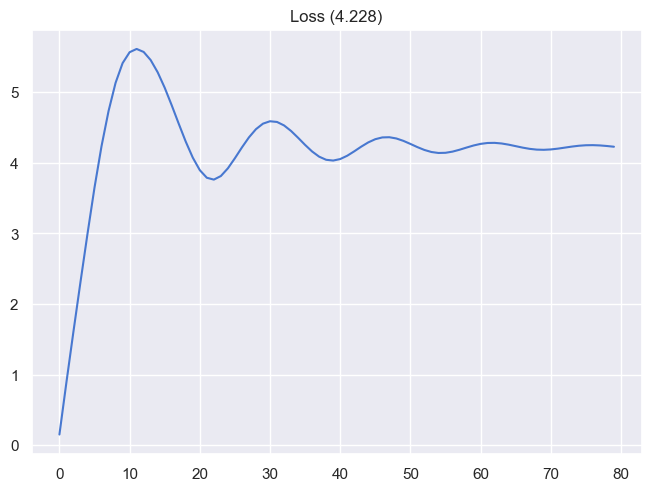

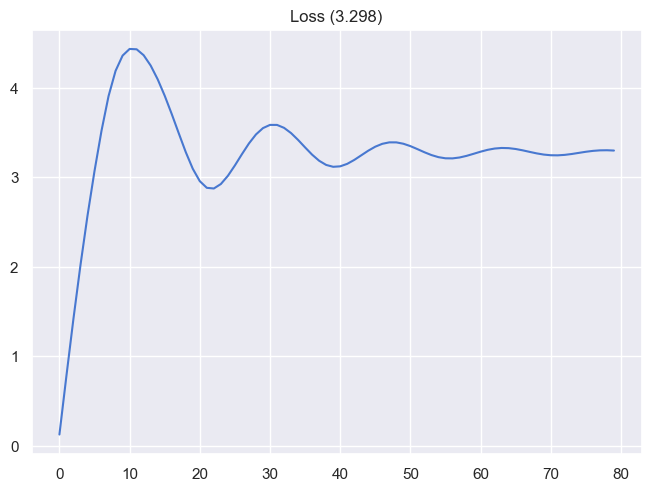

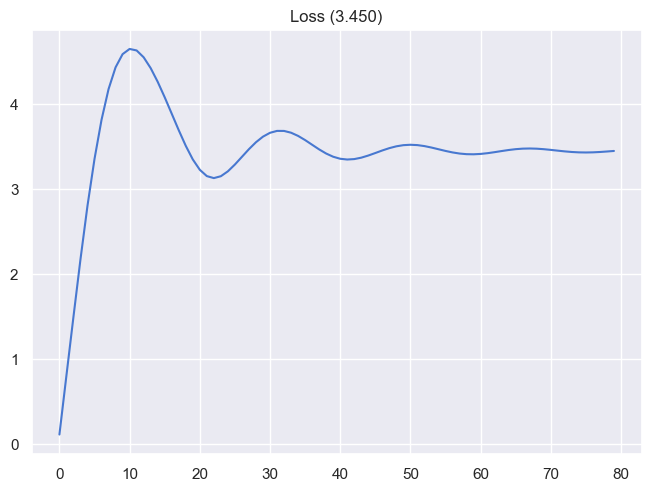

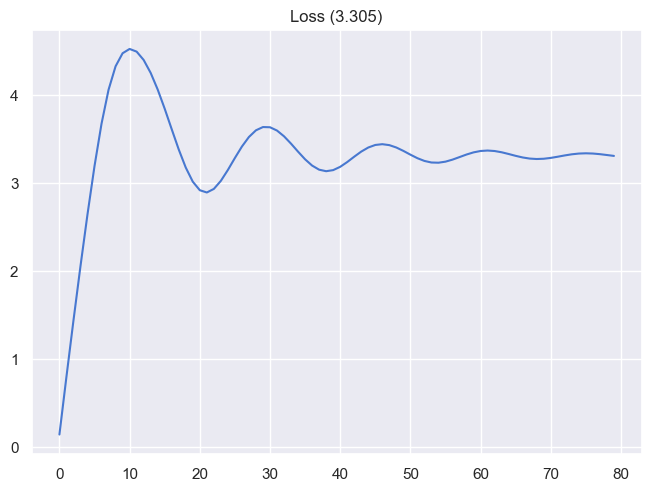

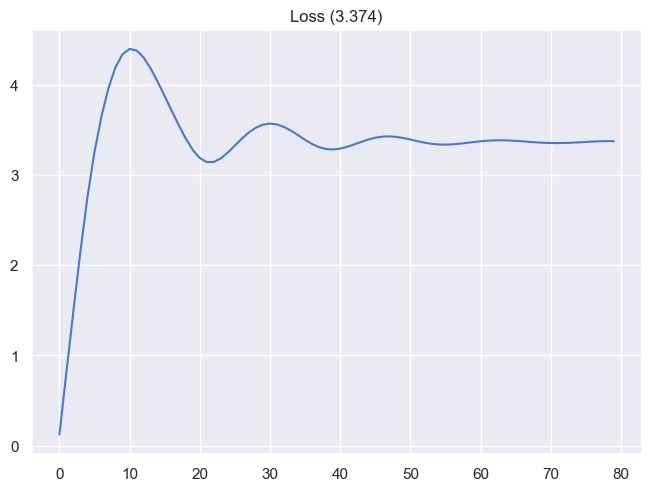

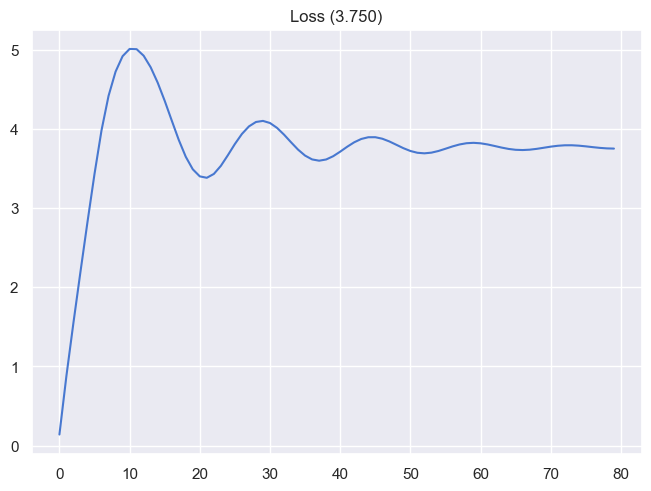

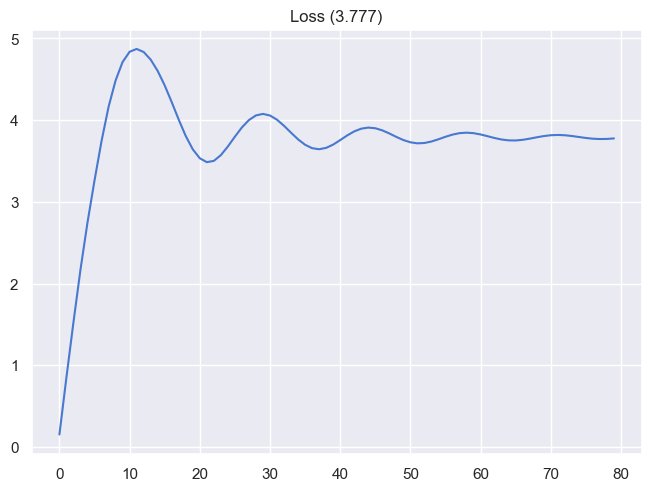

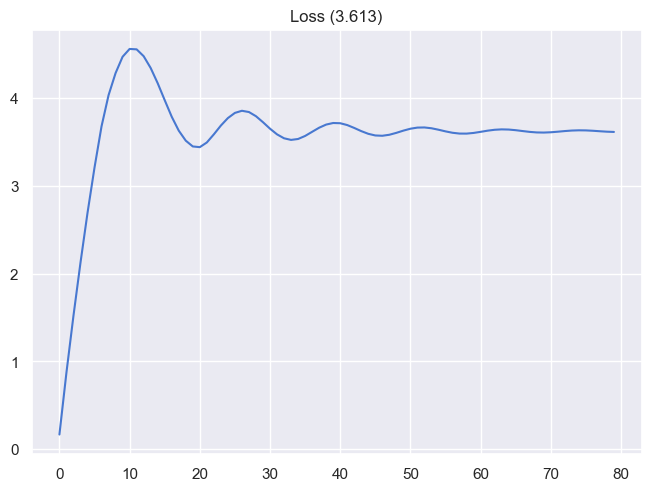

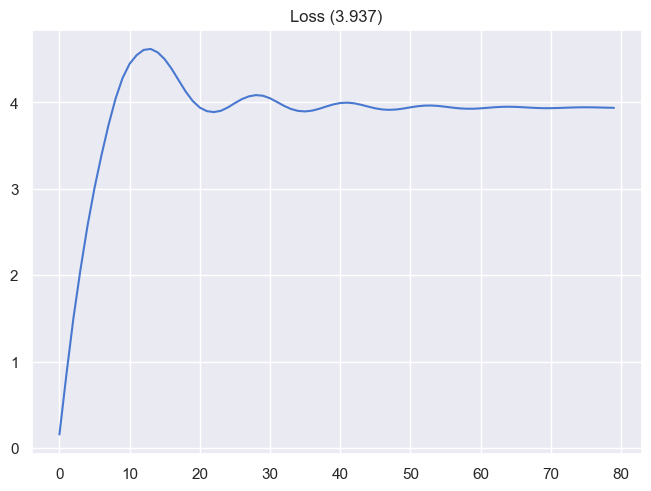

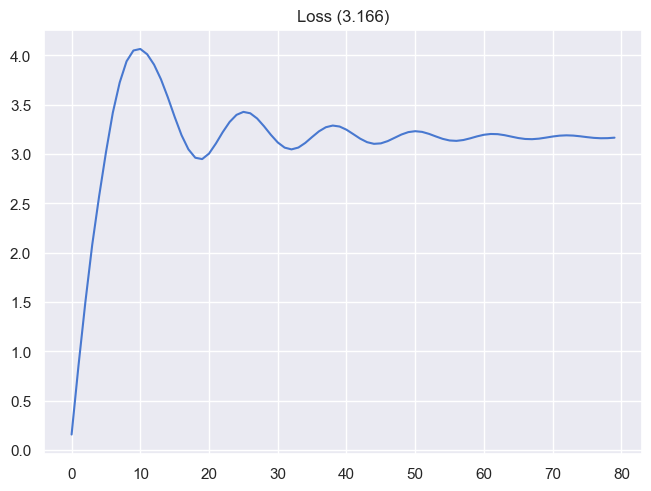

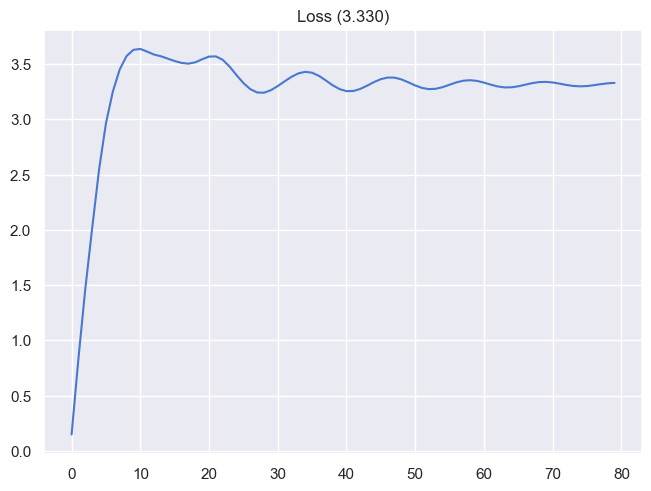

In [54]:
#normal distribution test
class Example6(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.02`.
    2. Performs recourse on the selected samples.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''
    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        y_pred = y_prob.flatten() < 0.5
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))
        print("weights: ",weight)
        recourse(model, sub_sample, 80, weight,loss_list=[])

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()

        training(model, train, 20)


weight = pt.from_numpy(np.random.normal(0.3,0.1,train.x.shape[1]))
print("outside: ",weight)
# print("train.x:",train.x.shape)
# pt.randn(train.x.shape[1])
ex6 = Example6(model, pca, train, test, sample)
ani6 = ex6.animate_all(200)
ani6.save('ex6.gif')

outside:  tensor([0.9015, 0.8319, 2.2337, 0.6196, 1.2635, 2.6035, 1.2170, 2.0327, 1.0852,
        1.2473, 0.3584, 0.7642, 2.8848, 1.3117, 0.8956, 1.5107, 0.9659, 0.3892,
        4.6153, 2.9368], dtype=torch.float64)
weights:  tensor([0.9015, 0.8319, 2.2337, 0.6196, 1.2635, 2.6035, 1.2170, 2.0327, 1.0852,
        1.2473, 0.3584, 0.7642, 2.8848, 1.3117, 0.8956, 1.5107, 0.9659, 0.3892,
        4.6153, 2.9368], dtype=torch.float64)
weights:  tensor([0.9015, 0.8319, 2.2337, 0.6196, 1.2635, 2.6035, 1.2170, 2.0327, 1.0852,
        1.2473, 0.3584, 0.7642, 2.8848, 1.3117, 0.8956, 1.5107, 0.9659, 0.3892,
        4.6153, 2.9368], dtype=torch.float64)
weights:  tensor([0.9015, 0.8319, 2.2337, 0.6196, 1.2635, 2.6035, 1.2170, 2.0327, 1.0852,
        1.2473, 0.3584, 0.7642, 2.8848, 1.3117, 0.8956, 1.5107, 0.9659, 0.3892,
        4.6153, 2.9368], dtype=torch.float64)
weights:  tensor([0.9015, 0.8319, 2.2337, 0.6196, 1.2635, 2.6035, 1.2170, 2.0327, 1.0852,
        1.2473, 0.3584, 0.7642, 2.8848, 1.3117

KeyboardInterrupt: 

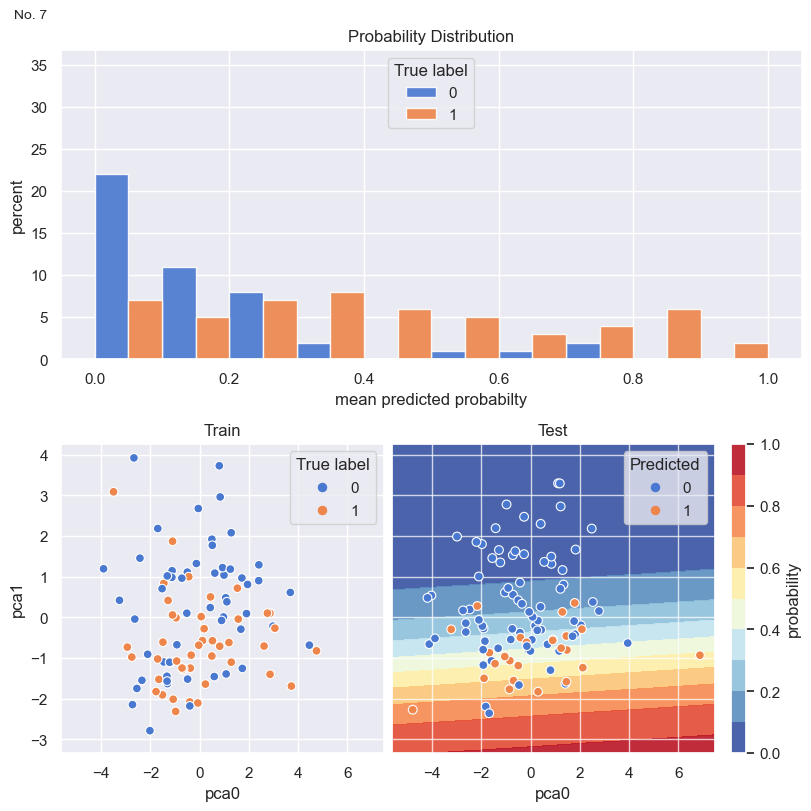

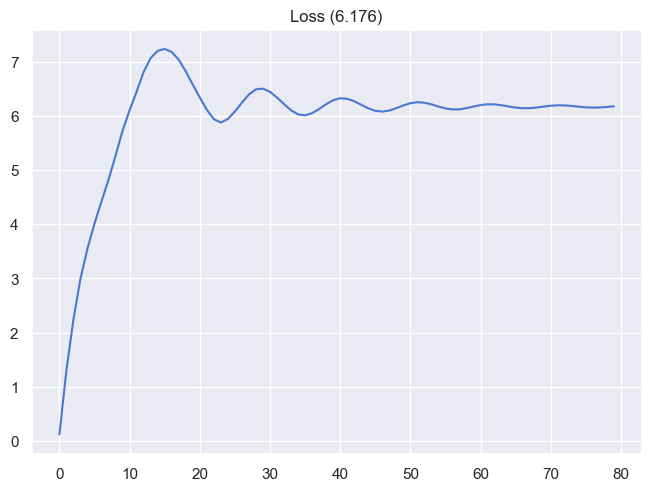

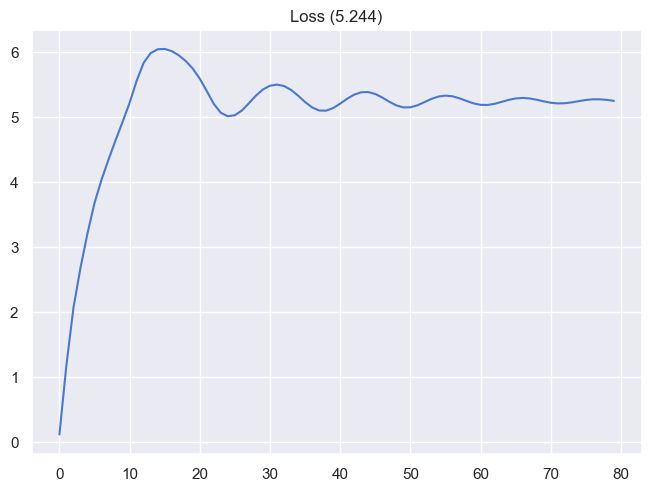

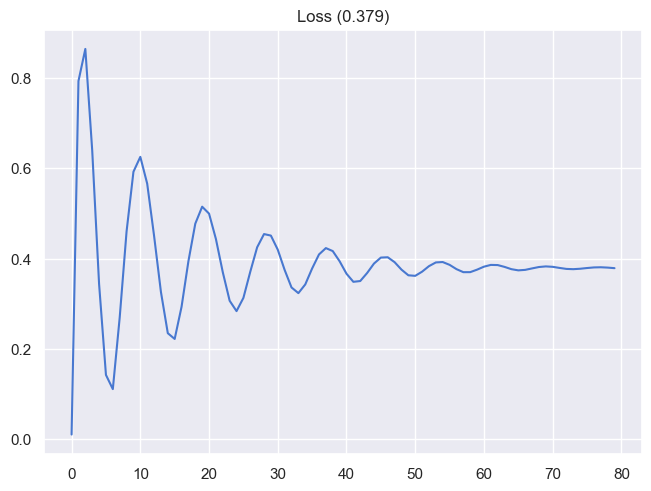

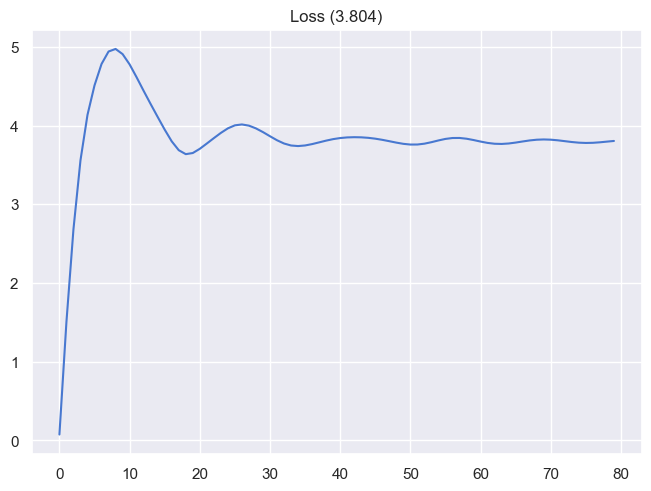

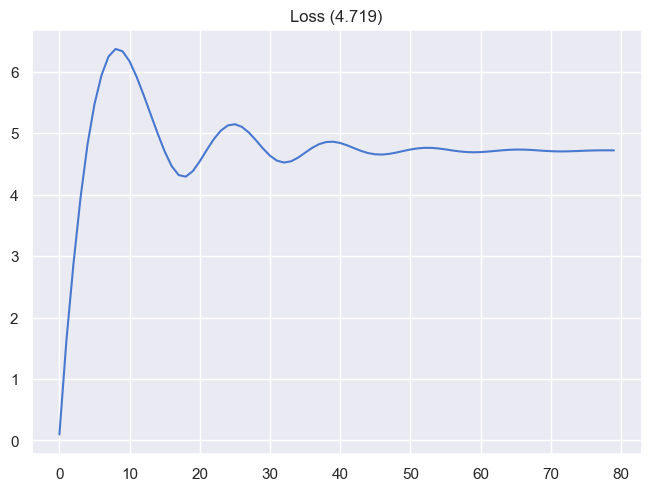

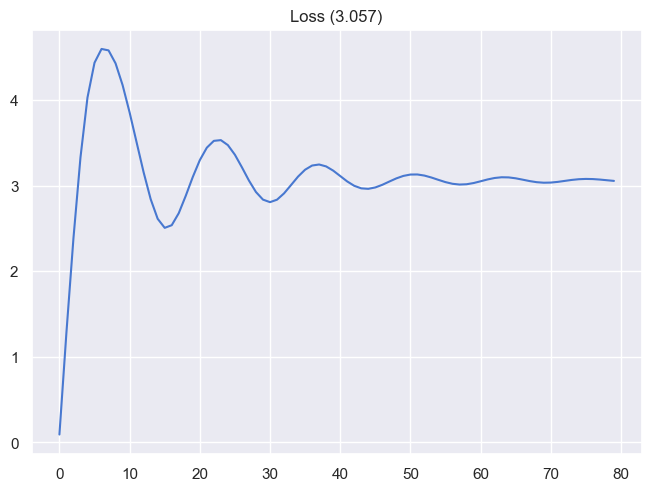

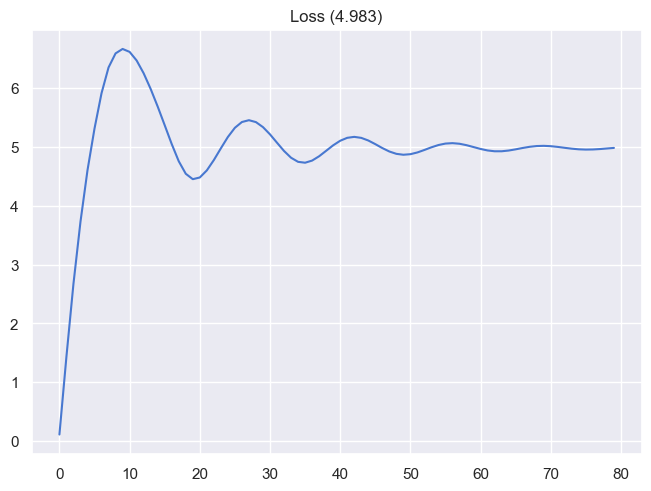

In [36]:
#gamma distribution test
class Example6(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.02`.
    2. Performs recourse on the selected samples.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''
    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        y_pred = y_prob.flatten() < 0.5
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))
        print("weights: ",weight)
        recourse(model, sub_sample, 80, weight,loss_list=[])

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()

        training(model, train, 20)


weight = pt.from_numpy(np.random.gamma(2,1,train.x.shape[1]))
print("outside: ",weight)
# print("train.x:",train.x.shape)
# pt.randn(train.x.shape[1])
ex6 = Example6(model, pca, train, test, sample)
ani6 = ex6.animate_all(200)
ani6.save('ex6.gif')

binomial y_pred tensor([False, False,  True, False, False,  True,  True, False, False, False])


x    y Predict  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   [1.0]   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   [1.0]   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   [1.0]   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   [1.0]   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   [1.0]   
..                                                 ...  ...     ...   
105  [0.0779372975230217, 1.11386239528656, -1.1041...  0.0   [0.0]   
106  [1.8908404111862183, 1.170678734779358, 0.4180...  1.0   [1.0]   
107  [2.121631383895874, 0.1580938994884491, 0.7297...  0.0   [0.0]   
108  [-1.2159669399261475, -0.041672736406326294, -...  1.0   [1.0]   
109  [-0.7950521111488342, -0.4017942547798157, -0....  0.0   [0.0]   

     flip_times  startRounds  updateRounds  EFT EFTList  
0           0.0          0.0           1.0  0.0      []  
1           0.0          0.0           1.0  0.0      []  
2           0.0          0.0           1.0  0.0      []  
3           0.0          0.0           1.0  0.0      []  
4           0.0          0.0           1.0  0.0      []  
..          ...          ...           ...  ...     ...  
105         0.0          0.0           1.0  0.0      []  
106         0.0          0.0           1.0  0.0      []  
107         0.0          0.0           1.0  0.0      []  
108         0.0          0.0           1.0  0.0      []  
109         0.0          0.0           1.0  0.0      []  

[110 rows x 8 columns]

binomial y_pred tensor([False,  True,  True, False, False,  True,  True,  True, False, False])


x    y     Predict  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0  [1.0, 1.0]   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0  [1.0, 1.0]   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0  [1.0, 1.0]   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0  [1.0, 0.0]   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0  [1.0, 1.0]   
..                                                 ...  ...         ...   
115  [-0.19752933084964752, -1.2595627307891846, -0...  1.0       [0.0]   
116  [2.121631383895874, 0.1580938994884491, 0.7297...  0.0       [0.0]   
117  [-0.8929905295372009, 1.6021312475204468, -0.3...  0.0       [0.0]   
118  [-1.4467906951904297, -0.33535706996917725, 1....  1.0       [1.0]   
119  [-0.022377334535121918, -0.21068492531776428, ...  1.0       [0.0]   

     flip_times  startRounds  updateRounds  EFT EFTList  
0           0.0          0.0           2.0  0.0   [0.0]  
1           0.0          0.0           2.0  0.0   [0.0]  
2           0.0          0.0           2.0  0.0   [0.0]  
3           1.0          0.0           2.0  1.0   [1.0]  
4           0.0          0.0           2.0  0.0   [0.0]  
..          ...          ...           ...  ...     ...  
115         0.0          1.0           1.0  0.0   [0.0]  
116         0.0          1.0           1.0  0.0   [0.0]  
117         0.0          1.0           1.0  0.0   [0.0]  
118         0.0          1.0           1.0  0.0   [0.0]  
119         0.0          1.0           1.0  0.0   [0.0]  

[120 rows x 8 columns]

binomial y_pred tensor([ True,  True, False, False, False, False, False,  True, False, False])


x    y          Predict  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0  [1.0, 1.0, 0.0]   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0  [1.0, 1.0, 1.0]   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0  [1.0, 1.0, 1.0]   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0  [1.0, 0.0, 1.0]   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0  [1.0, 1.0, 1.0]   
..                                                 ...  ...              ...   
125  [-0.14312639832496643, 2.0644943714141846, -1....  0.0            [0.0]   
126  [-0.37439003586769104, -1.5144140720367432, -0...  0.0            [0.0]   
127  [0.78657066822052, 1.7073811292648315, 0.36712...  1.0            [1.0]   
128  [-0.2530868351459503, -0.5911468267440796, 0.1...  0.0            [1.0]   
129  [-1.925642967224121, -0.4310844838619232, 1.27...  1.0            [1.0]   

     flip_times  startRounds  updateRounds  EFT     EFTList  
0           1.0          0.0           3.0  0.5  [0.0, 0.5]  
1           0.0          0.0           3.0  0.0  [0.0, 0.0]  
2           0.0          0.0           3.0  0.0  [0.0, 0.0]  
3           2.0          0.0           3.0  1.0  [1.0, 1.0]  
4           0.0          0.0           3.0  0.0  [0.0, 0.0]  
..          ...          ...           ...  ...         ...  
125         0.0          2.0           1.0  0.0  [0.0, 0.0]  
126         0.0          2.0           1.0  0.0  [0.0, 0.0]  
127         0.0          2.0           1.0  0.0  [0.0, 0.0]  
128         0.0          2.0           1.0  0.0  [0.0, 0.0]  
129         0.0          2.0           1.0  0.0  [0.0, 0.0]  

[130 rows x 8 columns]

binomial y_pred tensor([False, False, False,  True, False, False, False,  True, False, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
135  [0.0370066799223423, -0.02008102834224701, 0.8...  0.0   
136  [2.019371509552002, 1.1144042015075684, 0.1199...  1.0   
137  [0.8583512306213379, 0.9979543089866638, 0.166...  1.0   
138  [0.39704665541648865, -0.31267717480659485, 0....  0.0   
139  [-0.14215117692947388, 1.2171299457550049, -0....  1.0   

                  Predict  flip_times  startRounds  updateRounds       EFT  \
0    [1.0, 1.0, 0.0, 0.0]         1.0          0.0           4.0  0.333333   
1    [1.0, 1.0, 1.0, 1.0]         0.0          0.0           4.0  0.000000   
2    [1.0, 1.0, 1.0, 1.0]         0.0          0.0           4.0  0.000000   
3    [1.0, 0.0, 1.0, 0.0]         3.0          0.0           4.0  1.000000   
4    [1.0, 1.0, 1.0, 1.0]         0.0          0.0           4.0  0.000000   
..                    ...         ...          ...           ...       ...   
135                 [1.0]         0.0          3.0           1.0  0.000000   
136                 [0.0]         0.0          3.0           1.0  0.000000   
137                 [0.0]         0.0          3.0           1.0  0.000000   
138                 [0.0]         0.0          3.0           1.0  0.000000   
139                 [1.0]         0.0          3.0           1.0  0.000000   

                            EFTList  
0    [0.0, 0.5, 0.3333333333333333]  
1                   [0.0, 0.0, 0.0]  
2                   [0.0, 0.0, 0.0]  
3                   [1.0, 1.0, 1.0]  
4                   [0.0, 0.0, 0.0]  
..                              ...  
135                 [0.0, 0.0, 0.0]  
136                 [0.0, 0.0, 0.0]  
137                 [0.0, 0.0, 0.0]  
138                 [0.0, 0.0, 0.0]  
139                 [0.0, 0.0, 0.0]  

[140 rows x 8 columns]

binomial y_pred tensor([False,  True,  True, False, False,  True,  True, False,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
145  [0.39704665541648865, -0.31267717480659485, 0....  0.0   
146  [0.7854825854301453, 1.4801831245422363, -0.34...  0.0   
147  [-0.7950521111488342, -0.4017942547798157, -0....  0.0   
148  [1.8920564651489258, -1.4714992046356201, -0.5...  1.0   
149  [-1.0168944597244263, -1.700072169303894, -0.8...  0.0   

                       Predict  flip_times  startRounds  updateRounds   EFT  \
0    [1.0, 1.0, 0.0, 0.0, 0.0]         1.0          0.0           5.0  0.25   
1    [1.0, 1.0, 1.0, 1.0, 1.0]         0.0          0.0           5.0  0.00   
2    [1.0, 1.0, 1.0, 1.0, 1.0]         0.0          0.0           5.0  0.00   
3    [1.0, 0.0, 1.0, 0.0, 1.0]         4.0          0.0           5.0  1.00   
4    [1.0, 1.0, 1.0, 1.0, 1.0]         0.0          0.0           5.0  0.00   
..                         ...         ...          ...           ...   ...   
145                      [0.0]         0.0          4.0           1.0  0.00   
146                      [1.0]         0.0          4.0           1.0  0.00   
147                      [0.0]         0.0          4.0           1.0  0.00   
148                      [1.0]         0.0          4.0           1.0  0.00   
149                      [1.0]         0.0          4.0           1.0  0.00   

                                  EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25]  
1                    [0.0, 0.0, 0.0, 0.0]  
2                    [0.0, 0.0, 0.0, 0.0]  
3                    [1.0, 1.0, 1.0, 1.0]  
4                    [0.0, 0.0, 0.0, 0.0]  
..                                    ...  
145                  [0.0, 0.0, 0.0, 0.0]  
146                  [0.0, 0.0, 0.0, 0.0]  
147                  [0.0, 0.0, 0.0, 0.0]  
148                  [0.0, 0.0, 0.0, 0.0]  
149                  [0.0, 0.0, 0.0, 0.0]  

[150 rows x 8 columns]

binomial y_pred tensor([False, False, False, False, False, False, False,  True,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
155  [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
156  [0.0488484650850296, -0.23657293617725372, -0....  0.0   
157  [0.8074191808700562, -0.08900053799152374, 0.5...  0.0   
158  [-2.191253900527954, -0.45976462960243225, -0....  0.0   
159  [0.4784587025642395, 0.05013802647590637, 0.90...  1.0   

                            Predict  flip_times  startRounds  updateRounds  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]         1.0          0.0           6.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0]         1.0          0.0           6.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         0.0          0.0           6.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0]         4.0          0.0           6.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         0.0          0.0           6.0   
..                              ...         ...          ...           ...   
155                           [0.0]         0.0          5.0           1.0   
156                           [0.0]         0.0          5.0           1.0   
157                           [0.0]         0.0          5.0           1.0   
158                           [0.0]         0.0          5.0           1.0   
159                           [1.0]         0.0          5.0           1.0   

     EFT                                    EFTList  
0    0.2  [0.0, 0.5, 0.3333333333333333, 0.25, 0.2]  
1    0.2                  [0.0, 0.0, 0.0, 0.0, 0.2]  
2    0.0                  [0.0, 0.0, 0.0, 0.0, 0.0]  
3    0.8                  [1.0, 1.0, 1.0, 1.0, 0.8]  
4    0.0                  [0.0, 0.0, 0.0, 0.0, 0.0]  
..   ...                                        ...  
155  0.0                  [0.0, 0.0, 0.0, 0.0, 0.0]  
156  0.0                  [0.0, 0.0, 0.0, 0.0, 0.0]  
157  0.0                  [0.0, 0.0, 0.0, 0.0, 0.0]  
158  0.0                  [0.0, 0.0, 0.0, 0.0, 0.0]  
159  0.0                  [0.0, 0.0, 0.0, 0.0, 0.0]  

[160 rows x 8 columns]

binomial y_pred tensor([False,  True,  True, False, False,  True, False,  True,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
165  [1.8908404111862183, 1.170678734779358, 0.4180...  1.0   
166  [-0.7133108973503113, 1.7347627878189087, 0.43...  0.0   
167  [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
168  [0.0863986387848854, -1.3315123319625854, 2.34...  1.0   
169  [-0.7950521111488342, -0.4017942547798157, -0....  0.0   

                                 Predict  flip_times  startRounds  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]         1.0          0.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]         2.0          0.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         0.0          0.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]         5.0          0.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         0.0          0.0   
..                                   ...         ...          ...   
165                                [1.0]         0.0          6.0   
166                                [0.0]         0.0          6.0   
167                                [0.0]         0.0          6.0   
168                                [1.0]         0.0          6.0   
169                                [0.0]         0.0          6.0   

     updateRounds       EFT                                            EFTList  
0             7.0  0.166667  [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1             7.0  0.333333      [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333]  
2             7.0  0.000000                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
3             7.0  0.833333      [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334]  
4             7.0  0.000000                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
..            ...       ...                                                ...  
165           1.0  0.000000                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
166           1.0  0.000000                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
167           1.0  0.000000                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
168           1.0  0.000000                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
169           1.0  0.000000                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  

[170 rows x 8 columns]

binomial y_pred tensor([False, False, False, False, False,  True, False, False,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
175  [-0.03914402797818184, 1.0752215385437012, -0....  0.0   
176  [-1.2159669399261475, -0.041672736406326294, -...  1.0   
177  [-1.1341276168823242, -1.3362696170806885, -0....  1.0   
178  [0.39704665541648865, -0.31267717480659485, 0....  0.0   
179  [1.2692556381225586, 0.1633346825838089, 0.881...  0.0   

                                      Predict  flip_times  startRounds  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]         1.0          0.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0]         3.0          0.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         0.0          0.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]         5.0          0.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         0.0          0.0   
..                                        ...         ...          ...   
175                                     [0.0]         0.0          7.0   
176                                     [1.0]         0.0          7.0   
177                                     [1.0]         0.0          7.0   
178                                     [1.0]         0.0          7.0   
179                                     [0.0]         0.0          7.0   

     updateRounds       EFT                                            EFTList  
0             8.0  0.142857  [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1             8.0  0.428571  [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2             8.0  0.000000                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
3             8.0  0.714286  [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4             8.0  0.000000                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
..            ...       ...                                                ...  
175           1.0  0.000000                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
176           1.0  0.000000                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
177           1.0  0.000000                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
178           1.0  0.000000                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
179           1.0  0.000000                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  

[180 rows x 8 columns]

binomial y_pred tensor([ True, False, False,  True, False, False, False, False, False, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
185  [0.1485310196876526, -0.9968671202659607, -0.2...  1.0   
186  [0.9379895925521851, 1.0759341716766357, 0.616...  1.0   
187  [-0.3852560222148895, -0.8501690626144409, 0.7...  1.0   
188  [-1.4168235063552856, -0.6032968759536743, 0.7...  0.0   
189  [0.39704665541648865, -0.31267717480659485, 0....  0.0   

                                           Predict  flip_times  startRounds  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]         1.0          0.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0]         4.0          0.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         0.0          0.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]         5.0          0.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]         1.0          0.0   
..                                             ...         ...          ...   
185                                          [0.0]         0.0          8.0   
186                                          [1.0]         0.0          8.0   
187                                          [0.0]         0.0          8.0   
188                                          [1.0]         0.0          8.0   
189                                          [0.0]         0.0          8.0   

     updateRounds    EFT                                            EFTList  
0             9.0  0.125  [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1             9.0  0.500  [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2             9.0  0.000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
3             9.0  0.625  [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4             9.0  0.125         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125]  
..            ...    ...                                                ...  
185           1.0  0.000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
186           1.0  0.000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
187           1.0  0.000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
188           1.0  0.000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
189           1.0  0.000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  

[190 rows x 8 columns]

binomial y_pred tensor([ True, False, False,  True, False, False, False,  True,  True,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
195  [-0.7548661828041077, 0.022339239716529846, 0....  0.0   
196  [-2.351223945617676, -0.11792437732219696, -0....  0.0   
197  [0.7854825854301453, 1.4801831245422363, -0.34...  0.0   
198  [0.2066597044467926, 0.6290826201438904, 1.129...  0.0   
199  [-0.7950521111488342, -0.4017942547798157, -0....  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         4.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         0.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         6.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         2.0   
..                                                 ...         ...   
195                                              [0.0]         0.0   
196                                              [1.0]         0.0   
197                                              [1.0]         0.0   
198                                              [0.0]         0.0   
199                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          10.0  0.111111   
1            0.0          10.0  0.444444   
2            0.0          10.0  0.000000   
3            0.0          10.0  0.666667   
4            0.0          10.0  0.222222   
..           ...           ...       ...   
195          9.0           1.0  0.000000   
196          9.0           1.0  0.000000   
197          9.0           1.0  0.000000   
198          9.0           1.0  0.000000   
199          9.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
195      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
196      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
197      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
198      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
199      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  

[200 rows x 8 columns]

binomial y_pred tensor([False,  True, False, False,  True, False, False, False, False,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
205  [-2.1027016639709473, 0.4215136468410492, 0.33...  1.0   
206  [-0.3852560222148895, -0.8501690626144409, 0.7...  1.0   
207  [0.5484632849693298, -0.1604500412940979, 0.76...  0.0   
208  [1.2175480127334595, 0.31977805495262146, 1.39...  1.0   
209  [-0.19752933084964752, -1.2595627307891846, -0...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         2.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         4.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         0.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         2.0   
..                                                 ...         ...   
205                                              [1.0]         0.0   
206                                              [0.0]         0.0   
207                                              [0.0]         0.0   
208                                              [0.0]         0.0   
209                                              [0.0]         0.0   

     startRounds  updateRounds  EFT  \
0            0.0          11.0  0.2   
1            0.0          11.0  0.4   
2            0.0          11.0  0.0   
3            0.0          11.0  0.7   
4            0.0          11.0  0.2   
..           ...           ...  ...   
205         10.0           1.0  0.0   
206         10.0           1.0  0.0   
207         10.0           1.0  0.0   
208         10.0           1.0  0.0   
209         10.0           1.0  0.0   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
205  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
206  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
207  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
208  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
209  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[210 rows x 8 columns]

binomial y_pred tensor([ True, False,  True, False, False, False,  True,  True,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
215  [-1.0168944597244263, -1.700072169303894, -0.8...  0.0   
216  [0.8158390522003174, 0.5027148723602295, -0.44...  1.0   
217  [1.2175480127334595, 0.31977805495262146, 1.39...  1.0   
218  [2.5878305435180664, 2.68530535697937, -0.3894...  0.0   
219  [0.30193063616752625, 1.0386543273925781, -0.4...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         3.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         4.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         0.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         3.0   
..                                                 ...         ...   
215                                              [0.0]         0.0   
216                                              [0.0]         0.0   
217                                              [0.0]         0.0   
218                                              [0.0]         0.0   
219                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          12.0  0.272727   
1            0.0          12.0  0.363636   
2            0.0          12.0  0.000000   
3            0.0          12.0  0.636364   
4            0.0          12.0  0.272727   
..           ...           ...       ...   
215         11.0           1.0  0.000000   
216         11.0           1.0  0.000000   
217         11.0           1.0  0.000000   
218         11.0           1.0  0.000000   
219         11.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
215  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
216  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
217  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
218  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
219  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[220 rows x 8 columns]

binomial y_pred tensor([ True, False, False, False,  True, False,  True,  True,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
225  [0.6403371095657349, 0.9779082536697388, 1.213...  0.0   
226  [-1.522334337234497, 0.012169682420790195, -2....  0.0   
227  [-1.925642967224121, -0.4310844838619232, 1.27...  1.0   
228  [-0.7930728197097778, 1.0084487199783325, 1.18...  1.0   
229  [1.2175480127334595, 0.31977805495262146, 1.39...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         3.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         4.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         1.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         4.0   
..                                                 ...         ...   
225                                              [0.0]         0.0   
226                                              [0.0]         0.0   
227                                              [1.0]         0.0   
228                                              [0.0]         0.0   
229                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          13.0  0.250000   
1            0.0          13.0  0.333333   
2            0.0          13.0  0.083333   
3            0.0          13.0  0.583333   
4            0.0          13.0  0.333333   
..           ...           ...       ...   
225         12.0           1.0  0.000000   
226         12.0           1.0  0.000000   
227         12.0           1.0  0.000000   
228         12.0           1.0  0.000000   
229         12.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
225  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
226  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
227  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
228  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
229  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[230 rows x 8 columns]

binomial y_pred tensor([ True, False,  True, False, False, False,  True,  True, False,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
235  [0.7020303010940552, 0.4283529222011566, -0.46...  0.0   
236  [1.6772005558013916, 0.21907156705856323, 0.38...  0.0   
237  [0.6403371095657349, 0.9779082536697388, 1.213...  0.0   
238  [-0.23778893053531647, -0.5849044322967529, 0....  1.0   
239  [-0.18789292871952057, -1.5266544818878174, -2...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         3.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         4.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         1.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         5.0   
..                                                 ...         ...   
235                                              [0.0]         0.0   
236                                              [0.0]         0.0   
237                                              [0.0]         0.0   
238                                              [1.0]         0.0   
239                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          14.0  0.230769   
1            0.0          14.0  0.307692   
2            0.0          14.0  0.076923   
3            0.0          14.0  0.538462   
4            0.0          14.0  0.384615   
..           ...           ...       ...   
235         13.0           1.0  0.000000   
236         13.0           1.0  0.000000   
237         13.0           1.0  0.000000   
238         13.0           1.0  0.000000   
239         13.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
235  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
236  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
237  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
238  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
239  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[240 rows x 8 columns]

binomial y_pred tensor([ True, False,  True,  True, False, False, False,  True, False,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
245  [-0.3117977976799011, -1.7473630905151367, 0.2...  1.0   
246  [1.4538590908050537, -0.31241732835769653, -0....  1.0   
247  [-0.3423808515071869, -0.1938551515340805, 0.5...  0.0   
248  [-0.37439003586769104, -1.5144140720367432, -0...  0.0   
249  [1.0480836629867554, 0.794426679611206, -0.609...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         3.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         4.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         1.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         5.0   
..                                                 ...         ...   
245                                              [0.0]         0.0   
246                                              [0.0]         0.0   
247                                              [0.0]         0.0   
248                                              [0.0]         0.0   
249                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          15.0  0.214286   
1            0.0          15.0  0.285714   
2            0.0          15.0  0.071429   
3            0.0          15.0  0.500000   
4            0.0          15.0  0.357143   
..           ...           ...       ...   
245         14.0           1.0  0.000000   
246         14.0           1.0  0.000000   
247         14.0           1.0  0.000000   
248         14.0           1.0  0.000000   
249         14.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
245  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
246  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
247  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
248  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
249  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[250 rows x 8 columns]

binomial y_pred tensor([False, False, False,  True,  True,  True,  True, False,  True,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
255  [0.759442150592804, 0.27982160449028015, 0.565...  1.0   
256  [-0.26178768277168274, -0.03193388879299164, 0...  1.0   
257  [0.7020303010940552, 0.4283529222011566, -0.46...  0.0   
258  [-0.6081535220146179, -1.2433587312698364, -0....  1.0   
259  [2.121631383895874, 0.1580938994884491, 0.7297...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         3.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         4.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         1.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         5.0   
..                                                 ...         ...   
255                                              [0.0]         0.0   
256                                              [0.0]         0.0   
257                                              [0.0]         0.0   
258                                              [1.0]         0.0   
259                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          16.0  0.200000   
1            0.0          16.0  0.266667   
2            0.0          16.0  0.066667   
3            0.0          16.0  0.466667   
4            0.0          16.0  0.333333   
..           ...           ...       ...   
255         15.0           1.0  0.000000   
256         15.0           1.0  0.000000   
257         15.0           1.0  0.000000   
258         15.0           1.0  0.000000   
259         15.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
255  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
256  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
257  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
258  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
259  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[260 rows x 8 columns]

binomial y_pred tensor([False, False,  True,  True, False, False,  True, False,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
265  [1.6772005558013916, 0.21907156705856323, 0.38...  0.0   
266  [1.5926899909973145, -1.670881986618042, -0.51...  1.0   
267  [0.05304703116416931, 0.8849626779556274, -1.4...  1.0   
268  [0.6964829564094543, 0.10022523254156113, 0.21...  0.0   
269  [0.9379895925521851, 1.0759341716766357, 0.616...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         4.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         4.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         2.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         5.0   
..                                                 ...         ...   
265                                              [0.0]         0.0   
266                                              [1.0]         0.0   
267                                              [0.0]         0.0   
268                                              [0.0]         0.0   
269                                              [1.0]         0.0   

     startRounds  updateRounds     EFT  \
0            0.0          17.0  0.2500   
1            0.0          17.0  0.2500   
2            0.0          17.0  0.1250   
3            0.0          17.0  0.4375   
4            0.0          17.0  0.3125   
..           ...           ...     ...   
265         16.0           1.0  0.0000   
266         16.0           1.0  0.0000   
267         16.0           1.0  0.0000   
268         16.0           1.0  0.0000   
269         16.0           1.0  0.0000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
265  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
266  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
267  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
268  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
269  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[270 rows x 8 columns]

binomial y_pred tensor([ True,  True,  True, False,  True,  True, False,  True, False,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
275  [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
276  [-1.2159669399261475, -0.041672736406326294, -...  1.0   
277  [1.1244174242019653, 0.9911531209945679, -0.44...  1.0   
278  [0.9078524112701416, -0.16648557782173157, -0....  0.0   
279  [1.2692556381225586, 0.1633346825838089, 0.881...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         5.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         4.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         3.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         5.0   
..                                                 ...         ...   
275                                              [0.0]         0.0   
276                                              [1.0]         0.0   
277                                              [0.0]         0.0   
278                                              [0.0]         0.0   
279                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          18.0  0.294118   
1            0.0          18.0  0.235294   
2            0.0          18.0  0.176471   
3            0.0          18.0  0.411765   
4            0.0          18.0  0.294118   
..           ...           ...       ...   
275         17.0           1.0  0.000000   
276         17.0           1.0  0.000000   
277         17.0           1.0  0.000000   
278         17.0           1.0  0.000000   
279         17.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
275  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
276  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
277  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
278  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
279  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[280 rows x 8 columns]

binomial y_pred tensor([False,  True, False, False, False, False,  True, False, False,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
285  [0.6964829564094543, 0.10022523254156113, 0.21...  0.0   
286  [0.39704665541648865, -0.31267717480659485, 0....  0.0   
287  [-0.8128235936164856, -2.074486255645752, 1.62...  0.0   
288  [-0.4676095247268677, 1.378357172012329, -0.41...  1.0   
289  [0.9172489047050476, 1.168365240097046, 0.1266...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         6.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         5.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         3.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         5.0   
..                                                 ...         ...   
285                                              [0.0]         0.0   
286                                              [0.0]         0.0   
287                                              [0.0]         0.0   
288                                              [1.0]         0.0   
289                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          19.0  0.333333   
1            0.0          19.0  0.277778   
2            0.0          19.0  0.166667   
3            0.0          19.0  0.388889   
4            0.0          19.0  0.277778   
..           ...           ...       ...   
285         18.0           1.0  0.000000   
286         18.0           1.0  0.000000   
287         18.0           1.0  0.000000   
288         18.0           1.0  0.000000   
289         18.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
285  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
286  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
287  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
288  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
289  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[290 rows x 8 columns]

binomial y_pred tensor([False, False, False,  True, False, False, False,  True, False,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
295  [-1.9158689975738525, -0.43840888142585754, -0...  1.0   
296  [0.6119949817657471, 0.3672342896461487, -0.20...  1.0   
297  [1.0480836629867554, 0.794426679611206, -0.609...  0.0   
298  [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
299  [-0.7133108973503113, 1.7347627878189087, 0.43...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         6.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         5.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         4.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         6.0   
..                                                 ...         ...   
295                                              [1.0]         0.0   
296                                              [0.0]         0.0   
297                                              [1.0]         0.0   
298                                              [1.0]         0.0   
299                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          20.0  0.315789   
1            0.0          20.0  0.263158   
2            0.0          20.0  0.210526   
3            0.0          20.0  0.368421   
4            0.0          20.0  0.315789   
..           ...           ...       ...   
295         19.0           1.0  0.000000   
296         19.0           1.0  0.000000   
297         19.0           1.0  0.000000   
298         19.0           1.0  0.000000   
299         19.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
295  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
296  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
297  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
298  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
299  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[300 rows x 8 columns]

binomial y_pred tensor([False, False,  True, False, False, False,  True, False, False,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
305  [0.6403371095657349, 0.9779082536697388, 1.213...  0.0   
306  [-2.1027016639709473, 0.4215136468410492, 0.33...  1.0   
307  [1.2175480127334595, 0.31977805495262146, 1.39...  1.0   
308  [0.780222475528717, 0.2059607207775116, 0.7508...  1.0   
309  [-1.4168235063552856, -0.6032968759536743, 0.7...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         6.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         6.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         5.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         6.0   
..                                                 ...         ...   
305                                              [0.0]         0.0   
306                                              [0.0]         0.0   
307                                              [0.0]         0.0   
308                                              [0.0]         0.0   
309                                              [0.0]         0.0   

     startRounds  updateRounds   EFT  \
0            0.0          21.0  0.30   
1            0.0          21.0  0.30   
2            0.0          21.0  0.25   
3            0.0          21.0  0.35   
4            0.0          21.0  0.30   
..           ...           ...   ...   
305         20.0           1.0  0.00   
306         20.0           1.0  0.00   
307         20.0           1.0  0.00   
308         20.0           1.0  0.00   
309         20.0           1.0  0.00   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
305  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
306  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
307  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
308  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
309  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[310 rows x 8 columns]

binomial y_pred tensor([False,  True,  True,  True, False, False,  True,  True,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
315  [-1.925642967224121, -0.4310844838619232, 1.27...  1.0   
316  [-1.4467906951904297, -0.33535706996917725, 1....  1.0   
317  [1.8920564651489258, -1.4714992046356201, -0.5...  1.0   
318  [0.1485310196876526, -0.9968671202659607, -0.2...  1.0   
319  [-0.7133108973503113, 1.7347627878189087, 0.43...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         7.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         6.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         5.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         6.0   
..                                                 ...         ...   
315                                              [1.0]         0.0   
316                                              [0.0]         0.0   
317                                              [1.0]         0.0   
318                                              [1.0]         0.0   
319                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          22.0  0.333333   
1            0.0          22.0  0.285714   
2            0.0          22.0  0.238095   
3            0.0          22.0  0.333333   
4            0.0          22.0  0.285714   
..           ...           ...       ...   
315         21.0           1.0  0.000000   
316         21.0           1.0  0.000000   
317         21.0           1.0  0.000000   
318         21.0           1.0  0.000000   
319         21.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
315  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
316  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
317  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
318  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
319  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[320 rows x 8 columns]

binomial y_pred tensor([False, False, False, False, False, False, False,  True,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
325  [0.780222475528717, 0.2059607207775116, 0.7508...  1.0   
326  [-0.5038936734199524, -1.4821275472640991, 0.3...  1.0   
327  [0.16769152879714966, 0.508087694644928, -0.32...  0.0   
328  [0.08189667761325836, 0.05966189503669739, 2.0...  1.0   
329  [0.2066597044467926, 0.6290826201438904, 1.129...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         8.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         6.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         6.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         7.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         6.0   
..                                                 ...         ...   
325                                              [0.0]         0.0   
326                                              [0.0]         0.0   
327                                              [1.0]         0.0   
328                                              [0.0]         0.0   
329                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          23.0  0.363636   
1            0.0          23.0  0.272727   
2            0.0          23.0  0.272727   
3            0.0          23.0  0.318182   
4            0.0          23.0  0.272727   
..           ...           ...       ...   
325         22.0           1.0  0.000000   
326         22.0           1.0  0.000000   
327         22.0           1.0  0.000000   
328         22.0           1.0  0.000000   
329         22.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
325  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
326  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
327  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
328  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
329  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[330 rows x 8 columns]

binomial y_pred tensor([False, False,  True, False,  True,  True,  True,  True,  True,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
335  [-1.9158689975738525, -0.43840888142585754, -0...  1.0   
336  [0.0779372975230217, 1.11386239528656, -1.1041...  0.0   
337  [0.16769152879714966, 0.508087694644928, -0.32...  0.0   
338  [-0.5482150912284851, 1.381719708442688, -0.24...  0.0   
339  [-1.055855631828308, 1.028813362121582, -1.528...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         9.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         7.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         7.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         8.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         6.0   
..                                                 ...         ...   
335                                              [1.0]         0.0   
336                                              [1.0]         0.0   
337                                              [0.0]         0.0   
338                                              [1.0]         0.0   
339                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          24.0  0.391304   
1            0.0          24.0  0.304348   
2            0.0          24.0  0.304348   
3            0.0          24.0  0.347826   
4            0.0          24.0  0.260870   
..           ...           ...       ...   
335         23.0           1.0  0.000000   
336         23.0           1.0  0.000000   
337         23.0           1.0  0.000000   
338         23.0           1.0  0.000000   
339         23.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
335  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
336  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
337  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
338  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
339  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[340 rows x 8 columns]

binomial y_pred tensor([ True, False,  True, False, False,  True, False, False, False,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
345  [1.2175480127334595, 0.31977805495262146, 1.39...  1.0   
346  [-0.5054495334625244, 0.17281228303909302, -0....  1.0   
347  [0.8583512306213379, 0.9979543089866638, 0.166...  1.0   
348  [0.16769152879714966, 0.508087694644928, -0.32...  0.0   
349  [-1.1151034832000732, -0.3470640480518341, -1....  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         9.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         7.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         7.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...         9.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         6.0   
..                                                 ...         ...   
345                                              [0.0]         0.0   
346                                              [0.0]         0.0   
347                                              [1.0]         0.0   
348                                              [1.0]         0.0   
349                                              [1.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          25.0  0.375000   
1            0.0          25.0  0.291667   
2            0.0          25.0  0.291667   
3            0.0          25.0  0.375000   
4            0.0          25.0  0.250000   
..           ...           ...       ...   
345         24.0           1.0  0.000000   
346         24.0           1.0  0.000000   
347         24.0           1.0  0.000000   
348         24.0           1.0  0.000000   
349         24.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
345  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
346  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
347  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
348  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
349  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[350 rows x 8 columns]

binomial y_pred tensor([False, False, False,  True, False, False, False,  True,  True,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
355  [-0.5482150912284851, 1.381719708442688, -0.24...  0.0   
356  [0.759442150592804, 0.27982160449028015, 0.565...  1.0   
357  [-0.022377334535121918, -0.21068492531776428, ...  1.0   
358  [-0.2530868351459503, -0.5911468267440796, 0.1...  0.0   
359  [-0.2284725457429886, -0.3633120059967041, 0.9...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        10.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         7.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         7.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        10.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         6.0   
..                                                 ...         ...   
355                                              [1.0]         0.0   
356                                              [0.0]         0.0   
357                                              [1.0]         0.0   
358                                              [1.0]         0.0   
359                                              [0.0]         0.0   

     startRounds  updateRounds   EFT  \
0            0.0          26.0  0.40   
1            0.0          26.0  0.28   
2            0.0          26.0  0.28   
3            0.0          26.0  0.40   
4            0.0          26.0  0.24   
..           ...           ...   ...   
355         25.0           1.0  0.00   
356         25.0           1.0  0.00   
357         25.0           1.0  0.00   
358         25.0           1.0  0.00   
359         25.0           1.0  0.00   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
355  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
356  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
357  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
358  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
359  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[360 rows x 8 columns]

binomial y_pred tensor([False, False, False,  True, False, False,  True, False, False,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
365  [2.121631383895874, 0.1580938994884491, 0.7297...  0.0   
366  [0.9964319467544556, -1.4920862913131714, 0.40...  1.0   
367  [-0.4676095247268677, 1.378357172012329, -0.41...  1.0   
368  [2.5878305435180664, 2.68530535697937, -0.3894...  0.0   
369  [-0.3852560222148895, -0.8501690626144409, 0.7...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         7.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         7.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        11.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         6.0   
..                                                 ...         ...   
365                                              [0.0]         0.0   
366                                              [1.0]         0.0   
367                                              [0.0]         0.0   
368                                              [0.0]         0.0   
369                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          27.0  0.423077   
1            0.0          27.0  0.269231   
2            0.0          27.0  0.269231   
3            0.0          27.0  0.423077   
4            0.0          27.0  0.230769   
..           ...           ...       ...   
365         26.0           1.0  0.000000   
366         26.0           1.0  0.000000   
367         26.0           1.0  0.000000   
368         26.0           1.0  0.000000   
369         26.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
365  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
366  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
367  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
368  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
369  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[370 rows x 8 columns]

binomial y_pred tensor([False, False, False, False, False, False,  True, False, False,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
375  [-1.2159669399261475, -0.041672736406326294, -...  1.0   
376  [-0.3852560222148895, -0.8501690626144409, 0.7...  1.0   
377  [0.6119949817657471, 0.3672342896461487, -0.20...  1.0   
378  [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
379  [-0.2284725457429886, -0.3633120059967041, 0.9...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         7.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         8.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        11.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         6.0   
..                                                 ...         ...   
375                                              [1.0]         0.0   
376                                              [1.0]         0.0   
377                                              [0.0]         0.0   
378                                              [0.0]         0.0   
379                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          28.0  0.407407   
1            0.0          28.0  0.259259   
2            0.0          28.0  0.296296   
3            0.0          28.0  0.407407   
4            0.0          28.0  0.222222   
..           ...           ...       ...   
375         27.0           1.0  0.000000   
376         27.0           1.0  0.000000   
377         27.0           1.0  0.000000   
378         27.0           1.0  0.000000   
379         27.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
375  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
376  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
377  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
378  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
379  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[380 rows x 8 columns]

binomial y_pred tensor([False, False, False,  True,  True, False,  True, False, False, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
385  [0.0779372975230217, 1.11386239528656, -1.1041...  0.0   
386  [0.7020303010940552, 0.4283529222011566, -0.46...  0.0   
387  [-1.0168944597244263, -1.700072169303894, -0.8...  0.0   
388  [0.8074191808700562, -0.08900053799152374, 0.5...  0.0   
389  [0.9172489047050476, 1.168365240097046, 0.1266...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         7.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...         9.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        12.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         7.0   
..                                                 ...         ...   
385                                              [0.0]         0.0   
386                                              [0.0]         0.0   
387                                              [1.0]         0.0   
388                                              [0.0]         0.0   
389                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          29.0  0.392857   
1            0.0          29.0  0.250000   
2            0.0          29.0  0.321429   
3            0.0          29.0  0.428571   
4            0.0          29.0  0.250000   
..           ...           ...       ...   
385         28.0           1.0  0.000000   
386         28.0           1.0  0.000000   
387         28.0           1.0  0.000000   
388         28.0           1.0  0.000000   
389         28.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
385  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
386  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
387  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
388  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
389  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[390 rows x 8 columns]

binomial y_pred tensor([False, False, False,  True, False, False,  True, False,  True,  True])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
395  [-1.9158689975738525, -0.43840888142585754, -0...  1.0   
396  [0.9379895925521851, 1.0759341716766357, 0.616...  1.0   
397  [-2.1027016639709473, 0.4215136468410492, 0.33...  1.0   
398  [1.4538590908050537, -0.31241732835769653, -0....  1.0   
399  [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         7.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        10.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        13.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         7.0   
..                                                 ...         ...   
395                                              [1.0]         0.0   
396                                              [0.0]         0.0   
397                                              [1.0]         0.0   
398                                              [0.0]         0.0   
399                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          30.0  0.379310   
1            0.0          30.0  0.241379   
2            0.0          30.0  0.344828   
3            0.0          30.0  0.448276   
4            0.0          30.0  0.241379   
..           ...           ...       ...   
395         29.0           1.0  0.000000   
396         29.0           1.0  0.000000   
397         29.0           1.0  0.000000   
398         29.0           1.0  0.000000   
399         29.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
395  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
396  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
397  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
398  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
399  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[400 rows x 8 columns]

binomial y_pred tensor([False, False, False,  True,  True,  True,  True, False,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
405  [0.5484632849693298, -0.1604500412940979, 0.76...  0.0   
406  [1.256520390510559, -0.7665912508964539, -1.08...  1.0   
407  [0.0863986387848854, -1.3315123319625854, 2.34...  1.0   
408  [0.78657066822052, 1.7073811292648315, 0.36712...  1.0   
409  [0.08189667761325836, 0.05966189503669739, 2.0...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         7.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        11.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        13.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         7.0   
..                                                 ...         ...   
405                                              [0.0]         0.0   
406                                              [0.0]         0.0   
407                                              [0.0]         0.0   
408                                              [0.0]         0.0   
409                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          31.0  0.366667   
1            0.0          31.0  0.233333   
2            0.0          31.0  0.366667   
3            0.0          31.0  0.433333   
4            0.0          31.0  0.233333   
..           ...           ...       ...   
405         30.0           1.0  0.000000   
406         30.0           1.0  0.000000   
407         30.0           1.0  0.000000   
408         30.0           1.0  0.000000   
409         30.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
405  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
406  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
407  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
408  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
409  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[410 rows x 8 columns]

binomial y_pred tensor([False, False, False,  True, False,  True,  True, False,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
415  [-0.7930728197097778, 1.0084487199783325, 1.18...  1.0   
416  [-0.37439003586769104, -1.5144140720367432, -0...  0.0   
417  [0.8074191808700562, -0.08900053799152374, 0.5...  0.0   
418  [0.05304703116416931, 0.8849626779556274, -1.4...  1.0   
419  [0.6403371095657349, 0.9779082536697388, 1.213...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         8.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        11.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        13.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         7.0   
..                                                 ...         ...   
415                                              [1.0]         0.0   
416                                              [0.0]         0.0   
417                                              [0.0]         0.0   
418                                              [0.0]         0.0   
419                                              [1.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          32.0  0.354839   
1            0.0          32.0  0.258065   
2            0.0          32.0  0.354839   
3            0.0          32.0  0.419355   
4            0.0          32.0  0.225806   
..           ...           ...       ...   
415         31.0           1.0  0.000000   
416         31.0           1.0  0.000000   
417         31.0           1.0  0.000000   
418         31.0           1.0  0.000000   
419         31.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
415  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
416  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
417  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
418  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
419  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[420 rows x 8 columns]

binomial y_pred tensor([False, False,  True,  True, False,  True, False,  True, False, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
425  [0.0779372975230217, 1.11386239528656, -1.1041...  0.0   
426  [2.019371509552002, 1.1144042015075684, 0.1199...  1.0   
427  [-1.1341276168823242, -1.3362696170806885, -0....  1.0   
428  [-0.022377334535121918, -0.21068492531776428, ...  1.0   
429  [1.4538590908050537, -0.31241732835769653, -0....  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         8.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        11.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        13.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         7.0   
..                                                 ...         ...   
425                                              [1.0]         0.0   
426                                              [1.0]         0.0   
427                                              [0.0]         0.0   
428                                              [0.0]         0.0   
429                                              [1.0]         0.0   

     startRounds  updateRounds      EFT  \
0            0.0          33.0  0.34375   
1            0.0          33.0  0.25000   
2            0.0          33.0  0.34375   
3            0.0          33.0  0.40625   
4            0.0          33.0  0.21875   
..           ...           ...      ...   
425         32.0           1.0  0.00000   
426         32.0           1.0  0.00000   
427         32.0           1.0  0.00000   
428         32.0           1.0  0.00000   
429         32.0           1.0  0.00000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
425  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
426  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
427  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
428  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
429  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[430 rows x 8 columns]

binomial y_pred tensor([ True, False,  True, False,  True,  True,  True,  True, False, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
435  [-2.351223945617676, -0.11792437732219696, -0....  0.0   
436  [0.9078524112701416, -0.16648557782173157, -0....  0.0   
437  [-1.4106119871139526, 0.7384451627731323, 1.30...  1.0   
438  [0.2447846233844757, -2.9538235664367676, 0.20...  1.0   
439  [-0.2530868351459503, -0.5911468267440796, 0.1...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         9.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        11.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        13.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         7.0   
..                                                 ...         ...   
435                                              [1.0]         0.0   
436                                              [1.0]         0.0   
437                                              [0.0]         0.0   
438                                              [0.0]         0.0   
439                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          34.0  0.333333   
1            0.0          34.0  0.272727   
2            0.0          34.0  0.333333   
3            0.0          34.0  0.393939   
4            0.0          34.0  0.212121   
..           ...           ...       ...   
435         33.0           1.0  0.000000   
436         33.0           1.0  0.000000   
437         33.0           1.0  0.000000   
438         33.0           1.0  0.000000   
439         33.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
435  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
436  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
437  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
438  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
439  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[440 rows x 8 columns]

binomial y_pred tensor([False,  True, False,  True, False, False, False, False,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
445  [-1.4467906951904297, -0.33535706996917725, 1....  1.0   
446  [0.08795009553432465, -1.0686280727386475, 0.1...  0.0   
447  [-0.3117977976799011, -1.7473630905151367, 0.2...  1.0   
448  [-0.2284725457429886, -0.3633120059967041, 0.9...  0.0   
449  [-0.2596779763698578, 1.002809762954712, 1.662...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         9.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        11.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        13.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         7.0   
..                                                 ...         ...   
445                                              [0.0]         0.0   
446                                              [0.0]         0.0   
447                                              [0.0]         0.0   
448                                              [0.0]         0.0   
449                                              [1.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          35.0  0.323529   
1            0.0          35.0  0.264706   
2            0.0          35.0  0.323529   
3            0.0          35.0  0.382353   
4            0.0          35.0  0.205882   
..           ...           ...       ...   
445         34.0           1.0  0.000000   
446         34.0           1.0  0.000000   
447         34.0           1.0  0.000000   
448         34.0           1.0  0.000000   
449         34.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
445  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
446  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
447  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
448  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
449  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[450 rows x 8 columns]

binomial y_pred tensor([False, False,  True,  True,  True, False, False, False, False, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
455  [2.121631383895874, 0.1580938994884491, 0.7297...  0.0   
456  [-0.5054495334625244, 0.17281228303909302, -0....  1.0   
457  [-2.191253900527954, -0.45976462960243225, -0....  0.0   
458  [0.0863986387848854, -1.3315123319625854, 2.34...  1.0   
459  [0.1485310196876526, -0.9968671202659607, -0.2...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...         9.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        11.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        13.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         7.0   
..                                                 ...         ...   
455                                              [1.0]         0.0   
456                                              [0.0]         0.0   
457                                              [0.0]         0.0   
458                                              [0.0]         0.0   
459                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          36.0  0.314286   
1            0.0          36.0  0.257143   
2            0.0          36.0  0.314286   
3            0.0          36.0  0.371429   
4            0.0          36.0  0.200000   
..           ...           ...       ...   
455         35.0           1.0  0.000000   
456         35.0           1.0  0.000000   
457         35.0           1.0  0.000000   
458         35.0           1.0  0.000000   
459         35.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
455  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
456  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
457  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
458  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
459  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[460 rows x 8 columns]

binomial y_pred tensor([ True, False, False, False, False, False,  True,  True, False, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
465  [-0.14312639832496643, 2.0644943714141846, -1....  0.0   
466  [1.256520390510559, -0.7665912508964539, -1.08...  1.0   
467  [-1.4106119871139526, 0.7384451627731323, 1.30...  1.0   
468  [-1.522334337234497, 0.012169682420790195, -2....  0.0   
469  [0.16769152879714966, 0.508087694644928, -0.32...  0.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...        10.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        11.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        13.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         7.0   
..                                                 ...         ...   
465                                              [1.0]         0.0   
466                                              [1.0]         0.0   
467                                              [0.0]         0.0   
468                                              [1.0]         0.0   
469                                              [0.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          37.0  0.305556   
1            0.0          37.0  0.277778   
2            0.0          37.0  0.305556   
3            0.0          37.0  0.361111   
4            0.0          37.0  0.194444   
..           ...           ...       ...   
465         36.0           1.0  0.000000   
466         36.0           1.0  0.000000   
467         36.0           1.0  0.000000   
468         36.0           1.0  0.000000   
469         36.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
465  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
466  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
467  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
468  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
469  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[470 rows x 8 columns]

binomial y_pred tensor([ True, False, False,  True, False,  True, False, False,  True, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
475  [0.4784587025642395, 0.05013802647590637, 0.90...  1.0   
476  [0.9172489047050476, 1.168365240097046, 0.1266...  1.0   
477  [0.5484632849693298, -0.1604500412940979, 0.76...  0.0   
478  [-1.4168235063552856, -0.6032968759536743, 0.7...  0.0   
479  [1.8908404111862183, 1.170678734779358, 0.4180...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        11.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...        10.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        11.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        13.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         8.0   
..                                                 ...         ...   
475                                              [0.0]         0.0   
476                                              [0.0]         0.0   
477                                              [0.0]         0.0   
478                                              [0.0]         0.0   
479                                              [1.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          38.0  0.297297   
1            0.0          38.0  0.270270   
2            0.0          38.0  0.297297   
3            0.0          38.0  0.351351   
4            0.0          38.0  0.216216   
..           ...           ...       ...   
475         37.0           1.0  0.000000   
476         37.0           1.0  0.000000   
477         37.0           1.0  0.000000   
478         37.0           1.0  0.000000   
479         37.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
475  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
476  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
477  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
478  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
479  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[480 rows x 8 columns]

binomial y_pred tensor([ True, False, False, False,  True, False, False, False, False, False])


x    y  \
0    [0.2136027067899704, 0.555422842502594, 0.2268...  1.0   
1    [-0.14215117692947388, 1.2171299457550049, -0....  1.0   
2    [-1.9007741212844849, -0.7378332018852234, -0....  1.0   
3    [-0.38684096932411194, -0.823643147945404, 2.3...  1.0   
4    [-0.18789292871952057, -1.5266544818878174, -2...  1.0   
..                                                 ...  ...   
485  [0.780222475528717, 0.2059607207775116, 0.7508...  1.0   
486  [-0.22821752727031708, -0.6645854711532593, 0....  1.0   
487  [1.256520390510559, -0.7665912508964539, -1.08...  1.0   
488  [0.8569755554199219, -0.18509764969348907, 0.9...  0.0   
489  [-0.4676095247268677, 1.378357172012329, -0.41...  1.0   

                                               Predict  flip_times  \
0    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        12.0   
1    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...        10.0   
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        11.0   
3    [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...        13.0   
4    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...         9.0   
..                                                 ...         ...   
485                                              [1.0]         0.0   
486                                              [0.0]         0.0   
487                                              [1.0]         0.0   
488                                              [1.0]         0.0   
489                                              [1.0]         0.0   

     startRounds  updateRounds       EFT  \
0            0.0          39.0  0.315789   
1            0.0          39.0  0.263158   
2            0.0          39.0  0.289474   
3            0.0          39.0  0.342105   
4            0.0          39.0  0.236842   
..           ...           ...       ...   
485         38.0           1.0  0.000000   
486         38.0           1.0  0.000000   
487         38.0           1.0  0.000000   
488         38.0           1.0  0.000000   
489         38.0           1.0  0.000000   

                                               EFTList  
0    [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16...  
1    [0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ...  
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2...  
..                                                 ...  
485  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
486  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
487  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
488  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
489  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[490 rows x 8 columns]

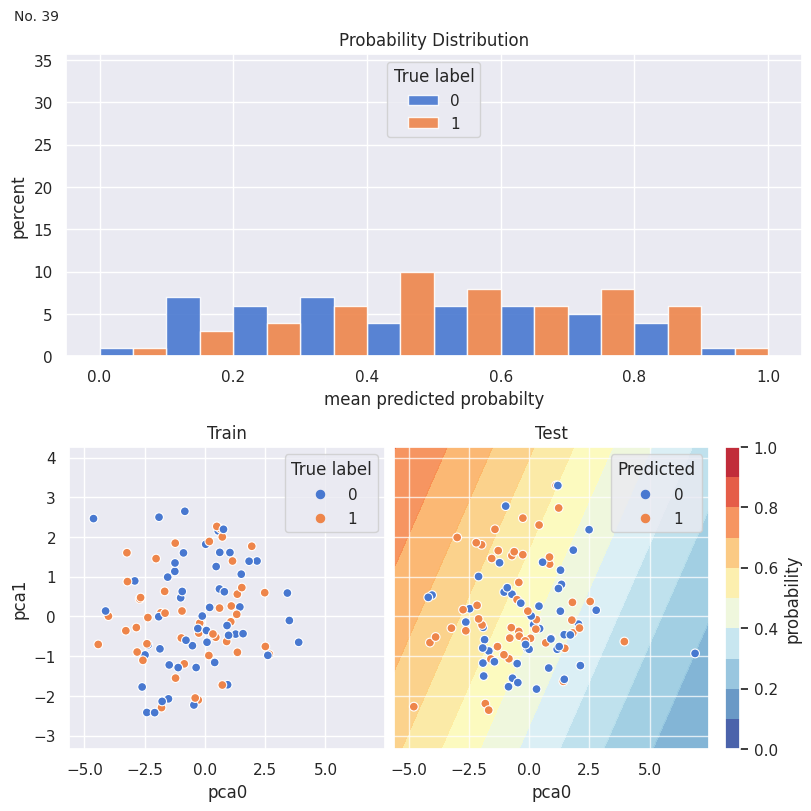

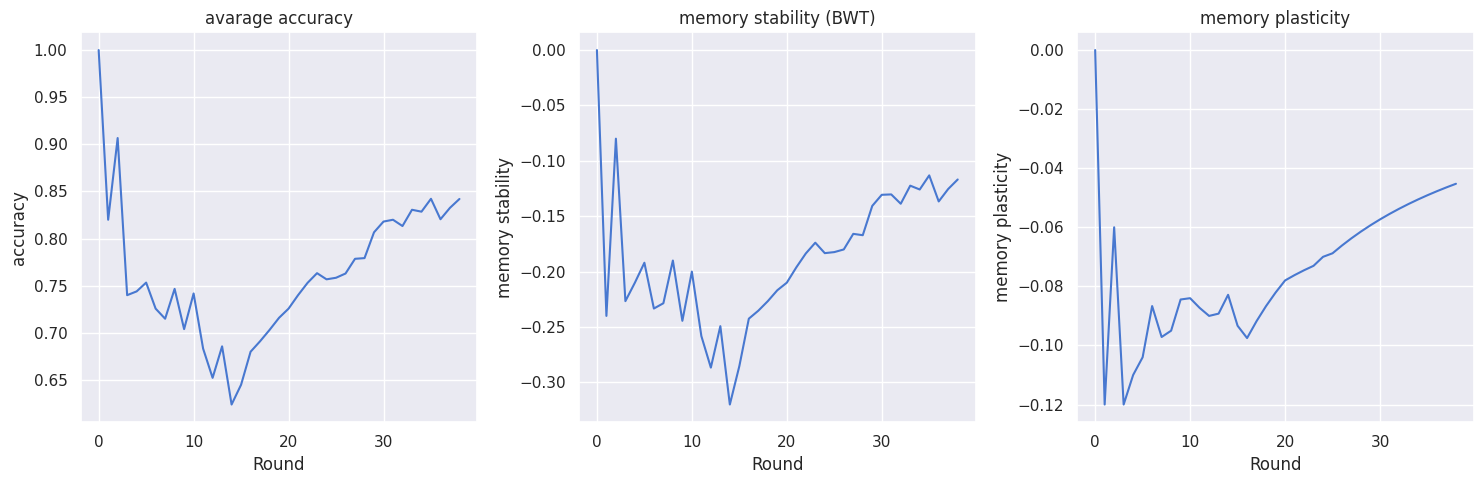

In [18]:
#主要都寫在裡面，其他的還沒加
class Example8(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.02`.
    2. Performs recourse on the selected samples with binomial distributed destination.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        modelParams = list(model.parameters())
        weights = deepcopy(modelParams[0].data.reshape(-1))
        bias = deepcopy(modelParams[1].data)
        # Selects a random subset of `sample` with a size of `train.size * 0.02`
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)
        # print("y_prob :",y_prob)
        y_pred = y_prob.flatten() < 0.5
        # print("y_pred :",y_pred)

        # Performs recourse on the selected samples with binomial distributed destination.
        binomialData = np.random.binomial(1,0.6,np.count_nonzero(y_pred)).astype(bool)
        # print("binomial data: ",binomialData)
        y_pred[y_pred == True] = pt.from_numpy(binomialData)
        print("binomial y_pred",y_pred)
        # print("x : ",x)
        # print("x[y_pred] : ",x[y_pred])
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))

        recourse(model, sub_sample, 5)

        x[y_pred] = sub_sample.x

        #Randomly relabels samples based on the model's probability scores.
        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        # print("y_prob : ",y_prob)
        # print("y_prob[y_pred] :",y_prob[y_pred])

        # Replaces a corresponding part of the training set with the updated samples.
        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()

        val_data = Dataset(train.x[j], train.y[j])
        self.validation_list.append(val_data)
        sample_model = LogisticRegression(val_data.x.shape[1], 1)
        sample_model.train()
        training(sample_model, val_data, 30)
        self.Aj_tide_list.append(self.calculate_accuracy(sample_model(val_data.x), val_data.y))

        # #紀錄新增進來的sample資料
        self.addEFTDataFrame(j)

        training(model, train, 20)

        #紀錄Fail_to_Recourse
        if len(x[y_pred]) > 0:
            with pt.no_grad():
                y_prob: pt.Tensor = model(x[y_pred])

            # print("x[y_pred] : ",x[y_pred])
            # print("after model update:")
            # print("y_prob:",y_prob)
            # print("y_prob[y_prob < 0.5]",y_prob[y_prob < 0.5])
            recourseFailCnt = len(y_prob[y_prob < 0.5])
            # print("recourseFailCnt",recourseFailCnt)
            recourseFailRate = recourseFailCnt / len(x[y_pred])
            # print("recourseFailRate : ",recourseFailRate)
            self.failToRecourse.append(recourseFailRate)
        else:
            print("no Recourse:")
            self.failToRecourse.append(0)



        self.EFTdataframe = self.EFTdataframe.assign(updateRounds = self.EFTdataframe['updateRounds'] + 1)
        self.round = self.round + 1

        #updated model predict the data with new sample
        data = np.vstack(self.EFTdataframe['x'])
        with pt.no_grad():
            y_pred = model(pt.tensor(data,dtype = pt.float))
        # print(y_pred)
        predictValue = deepcopy(y_pred.data)
        predictValue[predictValue > 0.5] = 1.0
        predictValue[predictValue < 0.5] = 0.0
        predictValue = predictValue.numpy().T.reshape(-1)
        # print("predictValue: ",predictValue)
        # print("data type: ",type(predictValue))
        for i in self.EFTdataframe.index:
            # for j in predictValue.numpy().T.reshape(-1):
            self.EFTdataframe.at[i,'Predict'].append(predictValue[i])


        # self.EFTdataframe.loc[predictValue.numpy().T.reshape(-1) != self.EFTdataframe['Predict'],['flip_times']] += 1
        for i in self.EFTdataframe.index:
            predictLength = len(self.EFTdataframe.at[i,'Predict'])
            # if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][predictLength - 2] != self.EFTdataframe.at[i,'Predict'][predictLength - 1]):
            if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][-2] != self.EFTdataframe.at[i,'Predict'][-1]):
                # self.EFTdataframe.loc[(self.EFTdataframe['rounds'] - self.EFTdataframe['startRounds'] > 1) and self.EFTdataframe['Predict'][self.round - 2] != self.EFTdataframe['Predict'][self.round - 1] ,['flip_times']] += 1
                self.EFTdataframe.at[i,'flip_times'] += 1

        # self.EFTdataframe = self.EFTdataframe.assign(Predict = predictValue)

        #update EFP values
        # self.EFTdataframe['EFT'] = self.EFTdataframe['flip_times'] / self.EFTdataframe['rounds']
        self.EFTdataframe.loc[(self.EFTdataframe['updateRounds'] - 1) > 0,['EFT']] = self.EFTdataframe['flip_times'] / (self.EFTdataframe['updateRounds'] - 1)

        for i in self.EFTdataframe.index:
            if len(self.EFTdataframe.at[i,'Predict']) > 1:
                # self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
                self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'EFT'])
        # else:
        #     self.EFTdataframe = self.EFTdataframe.assign(Predict = predictValue)
        # display(self.EFTdataframe[self.EFTdataframe['flip_times'] > 0])
        display(self.EFTdataframe)

        #calculate the PDt
        modelParams = list(model.parameters())
        modelParameter = np.concatenate((weights,bias))
        resultParameter = np.concatenate((modelParams[0].data.reshape(-1),modelParams[1].data))

        parameterL2 = np.linalg.norm(resultParameter - modelParameter)

        self.PDt.append(parameterL2)



ex8 = Example8(model, pca, train, test, sample)
ani8 = ex8.animate_all(240)
ani8.save('ex8.gif')

ex8.draw_PDt()
ex8.draw_EFT(240)
ex8.draw_R20_EFT(240,23)
ex8.draw_R20_EFT(240,40)
ex8.draw_R20_EFT(240,58)
print(ex8.failToRecourse)
ex8.draw_Fail_to_Recourse()
display(ex8.EFTdataframe)
ex1.plot_matricsA()

In [ ]:
a = [i for i in range(40,240,40)]
print(a)
print(len(a))
b = [i for i in range(1,len(a) + 1,1)]
print(b)

[40, 80, 120, 160, 200]
5
[1, 2, 3, 4, 5]
0
1
2
3
4
